<a href="https://colab.research.google.com/github/sukanyasaw/IS_test/blob/main/Classification_model_IS_rev9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
from numpy.ma.core import append
from scipy.stats import norm
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from statistics import mean

In [ ]:
def cv_comparison(models, X, y, cv):
  cv_accuracies = pd.DataFrame()
  accuracy = []
  precission = []
  recall = []
  f1score = []

  for model in models:
    acc = np.round(cross_val_score(model, X, y, scoring='accuracy', cv=cv),4)
    accuracy.append(acc)
    accuracy_avg = round(np.mean(accuracy), 4)

    pc = np.round(cross_val_score(model, X, y, scoring='precision_macro', cv=cv),4)
    precission.append(pc)
    precission_avg = round(np.mean(precission), 4)

    rc = np.round(cross_val_score(model, X, y, scoring='recall_macro', cv=cv),4)
    recall.append(rc)
    recall_avg = round(np.mean(recall), 4)

    f1 = np.round(cross_val_score(model, X, y, scoring='f1_macro', cv=cv),4) 
    # f1 for binary model (not sure to use f1_micro)
    f1score.append(f1)
    f1score_avg = round(np.mean(f1score), 4)

    cv_accuracies[str(model)] = [accuracy_avg,precission_avg,recall_avg,f1score_avg]

  cv_accuracies.index = ['Accuracy','Precission','Recall', 'F1']
  cv_accuracies.columns = ["SVM","kNN","MLPClassifier","DecissionTree","LogisticRegression"]
  return cv_accuracies, accuracy,precission,recall,f1score

# **1. Data Collection**

# Questionnaire dataset

In [ ]:
data = pd.read_excel("data.xlsx")

In [ ]:
df = data.copy()
df.head()  
# ทั้งหมดมี 54 columns

id  C1   C2              C3            C4  C5  C6  C7-1  C7-2  C8-1  ...  \
0  mb18   2  1.0  เทคนิคการแพทย์  กิจกรรมบำบัด   1   1     0     1   1.0  ...   
1  mb19   2  1.0    สื่อสารมวลชน   นิเทศศาสตร์   1   1     1     0   1.0  ...   
2  mb20   1  1.0      แพทยศาสตร์    แพทยศาสตร์   1   0     0     0   0.0  ...   
3  mb21   2  1.0    บริหารธุรกิจ      การบัญชี   2   2     0     2   2.0  ...   
4  mb22   2  1.0     เศรษฐศาสตร์   เศรษฐศาสตร์   1   1     0     1   1.0  ...   

   A1  A2   A3   A4 A5   W1   W2   W3   W4   W5  
0   4   4  5.0  4.0  5  4.0  5.0  4.0  5.0  NaN  
1   5   4  5.0  3.0  2  3.0  5.0  4.0  4.0  NaN  
2   4   4  5.0  3.0  4  4.0  4.0  3.0  5.0  NaN  
3   5   4  4.0  4.0  4  3.0  4.0  3.0  4.0  NaN  
4   5   5  5.0  5.0  5  4.0  5.0  4.0  5.0  NaN  

[5 rows x 54 columns]

In [ ]:
# drop column W1-5 เพราะเป็น comment เหลือ 49 columns
df = df.drop(columns=['W1','W2','W3','W4','W5'])
df.head()

id  C1   C2              C3            C4  C5  C6  C7-1  C7-2  C8-1  ...  \
0  mb18   2  1.0  เทคนิคการแพทย์  กิจกรรมบำบัด   1   1     0     1   1.0  ...   
1  mb19   2  1.0    สื่อสารมวลชน   นิเทศศาสตร์   1   1     1     0   1.0  ...   
2  mb20   1  1.0      แพทยศาสตร์    แพทยศาสตร์   1   0     0     0   0.0  ...   
3  mb21   2  1.0    บริหารธุรกิจ      การบัญชี   2   2     0     2   2.0  ...   
4  mb22   2  1.0     เศรษฐศาสตร์   เศรษฐศาสตร์   1   1     0     1   1.0  ...   

    K1   K2   K3   K4   K5 A1  A2   A3   A4  A5  
0  3.0  2.0  1.0  0.0  1.0  4   4  5.0  4.0   5  
1  3.0  1.0  2.0  0.0  1.0  5   4  5.0  3.0   2  
2  NaN  2.0  1.0  0.0  1.0  4   4  5.0  3.0   4  
3  2.0  1.0  1.0  2.0  2.0  5   4  4.0  4.0   4  
4  3.0  1.0  1.0  0.0  1.0  5   5  5.0  5.0   5  

[5 rows x 49 columns]

In [ ]:
# ข้อมูลมี 49 columns , 243 samples
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      243 non-null    object 
 1   C1      243 non-null    int64  
 2   C2      241 non-null    float64
 3   C3      243 non-null    object 
 4   C4      237 non-null    object 
 5   C5      243 non-null    int64  
 6   C6      243 non-null    int64  
 7   C7-1    243 non-null    int64  
 8   C7-2    243 non-null    int64  
 9   C8-1    241 non-null    float64
 10  C8-2    240 non-null    float64
 11  C8-3    240 non-null    float64
 12  C8-4    240 non-null    float64
 13  C9      237 non-null    float64
 14  C10     236 non-null    object 
 15  C11     203 non-null    object 
 16  C12     237 non-null    float64
 17  C13     233 non-null    float64
 18  C14-1   233 non-null    float64
 19  C14-2   233 non-null    float64
 20  C15-1   229 non-null    float64
 21  C15-2   230 non-null    float64
 22  C1

# **2.	Exploratory Data Analysis (EDA)**

# 2.1.	Detect Missing Value

In [ ]:
# สร้างฟังก์ชั่นแสดงจำนวน Missing value และร้อยละของ Missing value
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

In [ ]:
# แสดงจำนวนและร้อยละ Missing value ของแต่ละ column
missing_data = pd.DataFrame({'total_missing': df[show_missing()].isnull().sum(), 
                             '%_missing': round((df[show_missing()].isnull().sum()/243)*100,2)}) 
missing_data

total_missing  %_missing
C2                 2       0.82
C4                 6       2.47
C8-1               2       0.82
C8-2               3       1.23
C8-3               3       1.23
C8-4               3       1.23
C9                 6       2.47
C10                7       2.88
C11               40      16.46
C12                6       2.47
C13               10       4.12
C14-1             10       4.12
C14-2             10       4.12
C15-1             14       5.76
C15-2             13       5.35
C15-3             14       5.76
C15-4             14       5.76
R2                 3       1.23
R3                12       4.94
R4                19       7.82
R5                 6       2.47
B1                 2       0.82
B2                10       4.12
B3                 1       0.41
B4                 2       0.82
B5                 3       1.23
B6                 2       0.82
B7                 1       0.41
B8                 1       0.41
K1                 5       2.06
K2                 1       0.41
K3                 1       0.41
K4                 2       0.82
K5                 1       0.41
A3                 2       0.82
A4                 1       0.41

In [ ]:
# แสดงจำนวนและร้อยละ Missing value ของแต่ละ sample
missing_data_sample = pd.DataFrame({'total_missing': df[show_missing()].isnull().sum(axis=1), 
                             '%_missing': round((df[show_missing()].isnull().sum(axis=1)/52)*100,2)}) 

In [ ]:
# 10 อันดับแรกของ sample ที่มีจำนวนและร้อยละของ Missing value มากที่สุด (ทั้งหมด 49 columns)
missing_data_sample.sort_values(by='total_missing', ascending=False).head(10)

total_missing  %_missing
151             19      36.54
186             12      23.08
132             12      23.08
65              11      21.15
68              11      21.15
86              11      21.15
20               9      17.31
47               8      15.38
66               8      15.38
72               8      15.38

In [ ]:
# df2 = df เพื่อเพิ่ม column จำนวนและร้อยละของ missing value 
# เข้ามาอีก 2 columns กลายเป็น 51 columns
df2 = df.copy()
df2['Missing'] = df2.isnull().sum(axis=1)
df2['Missing_Percent']= round((df[show_missing()].isnull().sum(axis=1)/52)*100,2)
df2.head()

id  C1   C2              C3            C4  C5  C6  C7-1  C7-2  C8-1  ...  \
0  mb18   2  1.0  เทคนิคการแพทย์  กิจกรรมบำบัด   1   1     0     1   1.0  ...   
1  mb19   2  1.0    สื่อสารมวลชน   นิเทศศาสตร์   1   1     1     0   1.0  ...   
2  mb20   1  1.0      แพทยศาสตร์    แพทยศาสตร์   1   0     0     0   0.0  ...   
3  mb21   2  1.0    บริหารธุรกิจ      การบัญชี   2   2     0     2   2.0  ...   
4  mb22   2  1.0     เศรษฐศาสตร์   เศรษฐศาสตร์   1   1     0     1   1.0  ...   

    K3   K4   K5  A1 A2   A3   A4  A5  Missing  Missing_Percent  
0  1.0  0.0  1.0   4  4  5.0  4.0   5        0             0.00  
1  2.0  0.0  1.0   5  4  5.0  3.0   2        0             0.00  
2  1.0  0.0  1.0   4  4  5.0  3.0   4        1             1.92  
3  1.0  2.0  2.0   5  4  4.0  4.0   4        0             0.00  
4  1.0  0.0  1.0   5  5  5.0  5.0   5        0             0.00  

[5 rows x 51 columns]

In [ ]:
# sort ข้อมูลตามร้อยละของ Missing value จากมากไปหาน้อย
df2.sort_values(by='Missing_Percent', ascending=False).head(10)

id  C1   C2                             C3                    C4  C5  \
151  ma27   2  1.0                     นิติศาสตร์            นิติศาสตร์   2   
186   ga2   1  1.0                    มนุษยศาสตร์                   จีน   2   
132   ma8   2  1.0  วิทยาลัยศิลปะสื่อและเทคโนโลยี             แอนิเมชัน   2   
65    gb6   2  1.0                    มนุษยศาสตร์                อังกฤษ   1   
68    gb9   2  1.0   รัฐศาสตร์และรัฐประศาสนศาสตร์      รัฐประศาสนศาสตร์   2   
86   gb27   2  1.0                    ศึกษาศาสตร์  ภาษาไทยและต่างประเทศ   2   
20   mb38   2  1.0                     แพทยศาสตร์            แพทยศาสตร์   1   
47   mb14   2  1.0                 วิศวกรรมศาสตร์         วิศวกรรมไฟฟ้า   1   
66    gb7   2  1.0                 เทคนิคการแพทย์           รังสีเทคนิค   1   
72   gb13   2  1.0                   บริหารธุรกิจ             การจัดการ   2   

     C6  C7-1  C7-2  C8-1  ...   K3   K4   K5  A1 A2   A3   A4  A5  Missing  \
151   1     0     1   1.0  ...  NaN  NaN  NaN   4  4  3.0  4.0   5       19   
186   1     0     1   0.0  ...  1.0  0.0  1.0   4  4  4.0  3.0   5       12   
132   1     0     1   1.0  ...  2.0  0.0  0.0   4  4  5.0  5.0   5       12   
65    1     0     1   1.0  ...  1.0  0.0  1.0   3  5  5.0  3.0   3       11   
68    1     0     1   1.0  ...  1.0  0.0  1.0   4  3  4.0  2.0   3       11   
86    2     0     2   2.0  ...  0.0  0.0  1.0   5  5  4.0  3.0   1       11   
20    1     0     1   1.0  ...  1.0  0.0  1.0   4  4  5.0  3.0   5        9   
47    1     1     0   NaN  ...  1.0  0.0  1.0   4  3  4.0  3.0   5        8   
66    1     0     1   1.0  ...  2.0  0.0  1.0   4  5  5.0  3.0   5        8   
72    1     0     1   1.0  ...  2.0  2.0  2.0   3  4  3.0  1.0   3        8   

     Missing_Percent  
151            36.54  
186            23.08  
132            23.08  
65             21.15  
68             21.15  
86             21.15  
20             17.31  
47             15.38  
66             15.38  
72             15.38  

[10 rows x 51 columns]

In [ ]:
# เลือกตัดเฉพาะ ma27, ga2 เพราะข้อมูลหายเยอะ (ค่า y ก็หาย)
# ที่เหลือใช้การประมาณค่า missing value --> Imputation
print('Null samples = ',df2.isnull().any(axis=1).sum(),'samples = ',round(((df.isna().any(axis=1).sum())/243)*100,2),'%')

Null samples =  83 samples =  34.16 %


In [ ]:
# ลบแถว ma27, ga2
# เหลือ 241 samples
df2 = df2.drop(df2.index[[151,186]])
df2.sort_values(by='Missing_Percent', ascending=False).head(10)

id  C1   C2                             C3                    C4  C5  \
132   ma8   2  1.0  วิทยาลัยศิลปะสื่อและเทคโนโลยี             แอนิเมชัน   2   
68    gb9   2  1.0   รัฐศาสตร์และรัฐประศาสนศาสตร์      รัฐประศาสนศาสตร์   2   
86   gb27   2  1.0                    ศึกษาศาสตร์  ภาษาไทยและต่างประเทศ   2   
65    gb6   2  1.0                    มนุษยศาสตร์                อังกฤษ   1   
20   mb38   2  1.0                     แพทยศาสตร์            แพทยศาสตร์   1   
72   gb13   2  1.0                   บริหารธุรกิจ             การจัดการ   2   
47   mb14   2  1.0                 วิศวกรรมศาสตร์         วิศวกรรมไฟฟ้า   1   
51   mb52   2  1.0                 วิศวกรรมศาสตร์     วิศวกรรมเครื่องกล   3   
66    gb7   2  1.0                 เทคนิคการแพทย์           รังสีเทคนิค   1   
137  ma13   2  1.0                    เกษตรศาสตร์            สัตวศาสตร์   2   

     C6  C7-1  C7-2  C8-1  ...   K3   K4   K5  A1 A2   A3   A4  A5  Missing  \
132   1     0     1   1.0  ...  2.0  0.0  0.0   4  4  5.0  5.0   5       12   
68    1     0     1   1.0  ...  1.0  0.0  1.0   4  3  4.0  2.0   3       11   
86    2     0     2   2.0  ...  0.0  0.0  1.0   5  5  4.0  3.0   1       11   
65    1     0     1   1.0  ...  1.0  0.0  1.0   3  5  5.0  3.0   3       11   
20    1     0     1   1.0  ...  1.0  0.0  1.0   4  4  5.0  3.0   5        9   
72    1     0     1   1.0  ...  2.0  2.0  2.0   3  4  3.0  1.0   3        8   
47    1     1     0   NaN  ...  1.0  0.0  1.0   4  3  4.0  3.0   5        8   
51    1     0     1   NaN  ...  1.0  0.0  1.0   5  5  5.0  3.0   5        8   
66    1     0     1   1.0  ...  2.0  0.0  1.0   4  5  5.0  3.0   5        8   
137   2     1     1   1.0  ...  1.0  0.0  1.0   4  4  5.0  3.0   5        7   

     Missing_Percent  
132            23.08  
68             21.15  
86             21.15  
65             21.15  
20             17.31  
72             15.38  
47             15.38  
51             15.38  
66             15.38  
137            13.46  

[10 rows x 51 columns]

In [ ]:
# ตรวจสอบจำนวน samples ที่มี Missing value จาก 241 samples
print('Null samples = ',df2.isnull().any(axis=1).sum(),'samples = ',round(((df.isna().any(axis=1).sum())/243)*100,2),'%')

Null samples =  81 samples =  34.16 %


In [ ]:
# ลบ columns ที่แสดงจำนวนและร้อยละของ mising value ก่อนที่จะทำ Imputation 
# เหลือ 53 columns ,241 samples
df2 = df2.drop(columns=['Missing', 'Missing_Percent'])
df2.head()

id  C1   C2              C3            C4  C5  C6  C7-1  C7-2  C8-1  ...  \
0  mb18   2  1.0  เทคนิคการแพทย์  กิจกรรมบำบัด   1   1     0     1   1.0  ...   
1  mb19   2  1.0    สื่อสารมวลชน   นิเทศศาสตร์   1   1     1     0   1.0  ...   
2  mb20   1  1.0      แพทยศาสตร์    แพทยศาสตร์   1   0     0     0   0.0  ...   
3  mb21   2  1.0    บริหารธุรกิจ      การบัญชี   2   2     0     2   2.0  ...   
4  mb22   2  1.0     เศรษฐศาสตร์   เศรษฐศาสตร์   1   1     0     1   1.0  ...   

    K1   K2   K3   K4   K5 A1  A2   A3   A4  A5  
0  3.0  2.0  1.0  0.0  1.0  4   4  5.0  4.0   5  
1  3.0  1.0  2.0  0.0  1.0  5   4  5.0  3.0   2  
2  NaN  2.0  1.0  0.0  1.0  4   4  5.0  3.0   4  
3  2.0  1.0  1.0  2.0  2.0  5   4  4.0  4.0   4  
4  3.0  1.0  1.0  0.0  1.0  5   5  5.0  5.0   5  

[5 rows x 49 columns]

In [ ]:
# df2 = 53 columns ,241 samples
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 242
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      241 non-null    object 
 1   C1      241 non-null    int64  
 2   C2      239 non-null    float64
 3   C3      241 non-null    object 
 4   C4      235 non-null    object 
 5   C5      241 non-null    int64  
 6   C6      241 non-null    int64  
 7   C7-1    241 non-null    int64  
 8   C7-2    241 non-null    int64  
 9   C8-1    239 non-null    float64
 10  C8-2    238 non-null    float64
 11  C8-3    238 non-null    float64
 12  C8-4    238 non-null    float64
 13  C9      236 non-null    float64
 14  C10     235 non-null    object 
 15  C11     202 non-null    object 
 16  C12     236 non-null    float64
 17  C13     232 non-null    float64
 18  C14-1   232 non-null    float64
 19  C14-2   232 non-null    float64
 20  C15-1   228 non-null    float64
 21  C15-2   229 non-null    float64
 22  C1

In [ ]:
# ตรงนี้ยังเปลี่ยน type ไม่ได้เพราะมี Missing value
# df2.drop(['id','C3','C4','C10','C11','R4','B2'], axis=1).astype('int')

# 2.2.	Impute Missing Value (Mean, Mode)

In [ ]:
# Looking at values
def exploration(column):
    return df2[column].value_counts()

In [ ]:
# Imputing the missing values
def imputation(column, value):
    df2.loc[df2[column].isnull(),column] = value

**Impute Missing value : Occupant Characteristic**

In [ ]:
# C1 : Member
print('Missing Value = ',df2['C1'].isnull().sum())
exploration('C1')

Missing Value =  0


2    198
1     43
Name: C1, dtype: int64

2    198
1     43
Name: C1, dtype: int64

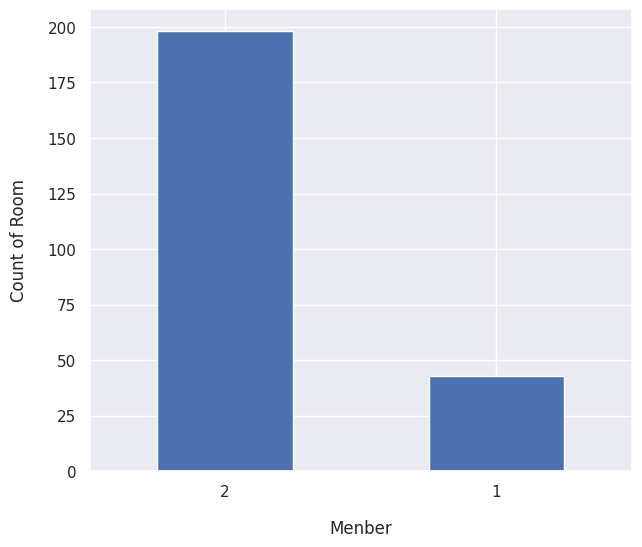

In [ ]:
# C1 : Member 
sns.set(font_scale=1.0)
df2['C1'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Menber", labelpad=14)
plt.ylabel("Count of Room", labelpad=14)
exploration('C1')

In [ ]:
# รวม Educate, Faculty, Major, Year ของสมาชิกทั้งหมดเป็นตารางแยกออกมาจาก df2
member1 = df2[['C2','C3','C4','C5']]
member1.rename(columns = {'C2':'educate', 'C3':'faculty', 'C4':'major', 'C5':'year'}, inplace = True)
member2 = df2[['C9','C10','C11','C12']]
member2.rename(columns = {'C9':'educate', 'C10':'faculty', 'C11':'major', 'C12':'year'}, inplace = True)
union_member = pd.concat([member1, member2])
union_member

<ipython-input-24-c98a8dc605f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  member1.rename(columns = {'C2':'educate', 'C3':'faculty', 'C4':'major', 'C5':'year'}, inplace = True)
<ipython-input-24-c98a8dc605f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  member2.rename(columns = {'C9':'educate', 'C10':'faculty', 'C11':'major', 'C12':'year'}, inplace = True)


educate                       faculty             major  year
0        1.0                เทคนิคการแพทย์      กิจกรรมบำบัด   1.0
1        1.0                  สื่อสารมวลชน       นิเทศศาสตร์   1.0
2        1.0                    แพทยศาสตร์        แพทยศาสตร์   1.0
3        1.0                  บริหารธุรกิจ          การบัญชี   2.0
4        1.0                   เศรษฐศาสตร์       เศรษฐศาสตร์   1.0
..       ...                           ...               ...   ...
238      1.0                   เศรษฐศาสตร์       เศรษฐศาสตร์   2.0
239      1.0                   เศรษฐศาสตร์       เศรษฐศาสตร์   1.0
240      1.0  รัฐศาสตร์และรัฐประศาสนศาสตร์  การระหว่างประเทศ   2.0
241      0.0                          None              None   0.0
242      1.0                  สื่อสารมวลชน               NaN   3.0

[482 rows x 4 columns]

In [ ]:
# Check Missing value of Educate
print('Missing Value = ',union_member['educate'].isnull().sum())
union_member['educate'].value_counts()

Missing Value =  7


1.0    429
0.0     43
2.0      3
Name: educate, dtype: int64

In [ ]:
# Impute Missing value of Educate
union_member.loc[union_member['educate'].isnull(),'educate'] = 1

In [ ]:
# Check Missing value of Faculty
print('Missing Value = ',union_member['faculty'].isnull().sum())
pd.DataFrame(union_member['faculty'].value_counts())

Missing Value =  6


faculty
วิศวกรรมศาสตร์                        75
บริหารธุรกิจ                          51
มนุษยศาสตร์                           47
None                                  43
วิทยาศาสตร์                           35
เศรษฐศาสตร์                           35
ศึกษาศาสตร์                           24
รัฐศาสตร์และรัฐประศาสนศาสตร์          20
นิติศาสตร์                            20
วิทยาลัยศิลปะสื่อและเทคโนโลยี         19
สื่อสารมวลชน                          18
เกษตรศาสตร์                           15
เภสัชศาสตร์                           11
สังคมศาสตร์                            9
แพทยศาสตร์                             9
สถาปัตยกรรมศาสตร์                      8
อุตสาหกรรมการเกษตร                     7
วิจิตรศิลป์                            6
เทคนิคการแพทย์                         6
อุตสาหกรรมเกษตร                        4
พยาบาลศาสตร์                           4
ทันตแพทยศาสตร์                         4
วิทยาลัยนานาชาตินวัตกรรมดิจิทัล        2
สัตวแพทยศาสตร์                         2
วิทยาลัยนานาชาตินวัตกรรมดิจิตอล        2

In [ ]:
# Impute Missing value of Faculty
union_member.loc[union_member['faculty'].isnull(),'faculty'] = 'วิศวกรรมศาสตร์'

In [ ]:
# Check Missing value of Major
print('Missing Value = ',union_member['major'].isnull().sum())
pd.DataFrame(union_member['major'].value_counts())

Missing Value =  45


major
None               43
เศรษฐศาสตร์        39
การบัญชี           25
นิติศาสตร์         20
วิศวกรรมไฟฟ้า      15
...               ...
สัตววิทยา           1
วิทยาการข้อมูล      1
พืชสวน              1
ปรัชญา              1
พืชไร่              1

[69 rows x 1 columns]

In [ ]:
# แสดง Factory ที่ major มี Missing Value
fama = pd.DataFrame(union_member[['faculty']].loc[union_member['major'].isnull()].value_counts())
fama.reset_index(inplace=True)
fama

faculty   0
0                      สื่อสารมวลชน  11
1                    วิศวกรรมศาสตร์  10
2                      บริหารธุรกิจ   5
3                       ศึกษาศาสตร์   4
4      รัฐศาสตร์และรัฐประศาสนศาสตร์   2
5                       วิจิตรศิลป์   2
6     วิทยาลัยศิลปะสื่อและเทคโนโลยี   2
7                       สังคมศาสตร์   2
8                อุตสาหกรรมการเกษตร   2
9                       มนุษยศาสตร์   1
10  วิทยาลัยนานาชาตินวัตกรรมดิจิตอล   1
11                สถาปัตยกรรมศาสตร์   1
12                      เกษตรศาสตร์   1
13                   เทคนิคการแพทย์   1

In [ ]:
# แสดงจำนวนของ Faculty และ Major
for i in range(len(fama)):
  fac = fama.iloc[i,0]
  t = pd.DataFrame(union_member[['faculty','major']].loc[union_member['faculty']==fac].value_counts())
  display(t)

0
faculty      major                
สื่อสารมวลชน นิเทศศาสตร์         6
             ภาพยนตร์และภาพนิ่ง  1

0
faculty        major                  
วิศวกรรมศาสตร์ วิศวกรรมไฟฟ้า        15
               วิศวกรรมอุตสาหการ    12
               วิศวกรรมเครื่องกล    12
               วิศวกรรมโยธา         12
               วิศวกรรมคอมพิวเตอร์  10
               วิศวกรรมหุ่นยนต์      5
               วิศวกรรมเหมืองแร่     3
               วิศวกรรมสิ่งแวดล้อม   2

0
faculty      major        
บริหารธุรกิจ การบัญชี   25
             การจัดการ  11
             การตลาด    10

0
faculty     major                  
ศึกษาศาสตร์ เคมี                  6
            การศึกษาพิเศษ         4
            ชีววิทยา              3
            สังคมศึกษา            3
            คณิตศาสตร์            2
            ภาษาไทยและต่างประเทศ  2

0
faculty                      major                
รัฐศาสตร์และรัฐประศาสนศาสตร์ การระหว่างประเทศ   11
                             การเมืองการปกครอง   4
                             รัฐประศาสนศาสตร์    3

0
faculty     major       
วิจิตรศิลป์ ทัศนศิลป์  4

0
faculty                       major                
วิทยาลัยศิลปะสื่อและเทคโนโลยี แอนิเมชัน          10
                              การจัดการสมัยใหม่   3
                              เกมดิจิทัล          3
                              วิศวกรรมซอฟต์แวร์   1

0
faculty     major        
สังคมศาสตร์ อาเซียน     4
            ภูมิศาสตร์  3

0
faculty            major                        
อุตสาหกรรมการเกษตร เทคโนโลยีการอาหาร           3
                   เทคโนโลยีอุตสาหการ การผลิต  2

0
faculty     major                       
มนุษยศาสตร์ การท่องเที่ยวและการโรงแรม  8
            ประวัติศาสตร์              6
            สารสนเทศศาสตร์             6
            อังกฤษ                     6
            ญี่ปุ่น                    4
            ไทย                        4
            จีน                        3
            มนุษยศาสตร์และความยั่งยืน  3
            จิตวิทยา                   2
            บรรณารักษ์                 2
            ปรัชญา                     1
            ฝรั่งเศษ                   1

0
faculty                         major          
วิทยาลัยนานาชาตินวัตกรรมดิจิตอล Data Science  1

0
faculty           major         
สถาปัตยกรรมศาสตร์ สถาปัตยกรรม  7

0
faculty     major                        
เกษตรศาสตร์ สัตวศาสตร์                  5
            เศรษฐศาสตร์                 4
            ปัฐพี                       2
            ทรัพยากรธรรมชาติและวนเกษตร  1
            พืชสวน                      1
            พืชไร่                      1

0
faculty        major            
เทคนิคการแพทย์ กิจกรรมบำบัด    2
               รังสีเทคนิค     2
               เทคนิคการแพทย์  1

In [ ]:
# Imputate Missing value of Major
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('สื่อสารมวลชน'),'major'] = 'นิเทศศาสตร์'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('วิศวกรรมศาสตร์'),'major'] = 'วิศวกรรมไฟฟ้า'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('บริหารธุรกิจ'),'major'] = 'การบัญชี'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('ศึกษาศาสตร์'),'major'] = 'เคมี'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('รัฐศาสตร์และรัฐประศาสนศาสตร์'),'major'] = 'การระหว่างประเทศ'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('วิจิตรศิลป์'),'major'] = 'ทัศนศิลป์'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('วิทยาลัยศิลปะสื่อและเทคโนโลยี'),'major'] = 'แอนิเมชัน'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('สังคมศาสตร์'),'major'] = 'อาเซียน'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('อุตสาหกรรมการเกษตร'),'major'] = 'เทคโนโลยีการอาหาร'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('มนุษยศาสตร์'),'major'] = 'การท่องเที่ยวและการโรงแรม'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('วิทยาลัยนานาชาตินวัตกรรมดิจิตอล'),'major'] = 'Data Science'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('สถาปัตยกรรมศาสตร์'),'major'] = 'สถาปัตยกรรม'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('เกษตรศาสตร์'),'major'] = 'สัตวศาสตร์'
union_member.loc[union_member['major'].isnull() & union_member['faculty'].str.contains('เทคนิคการแพทย์'),'major'] = 'กิจกรรมบำบัด'

In [ ]:
union_member.head()

educate         faculty         major  year
0      1.0  เทคนิคการแพทย์  กิจกรรมบำบัด   1.0
1      1.0    สื่อสารมวลชน   นิเทศศาสตร์   1.0
2      1.0      แพทยศาสตร์    แพทยศาสตร์   1.0
3      1.0    บริหารธุรกิจ      การบัญชี   2.0
4      1.0     เศรษฐศาสตร์   เศรษฐศาสตร์   1.0

In [ ]:
fa = pd.DataFrame(union_member[['faculty']].value_counts())
fa.reset_index(inplace=True)
fa.columns = ['faculty', 'count']
fa

faculty  count
0                    วิศวกรรมศาสตร์     81
1                      บริหารธุรกิจ     51
2                       มนุษยศาสตร์     47
3                              None     43
4                       เศรษฐศาสตร์     35
5                       วิทยาศาสตร์     35
6                       ศึกษาศาสตร์     24
7      รัฐศาสตร์และรัฐประศาสนศาสตร์     20
8                        นิติศาสตร์     20
9     วิทยาลัยศิลปะสื่อและเทคโนโลยี     19
10                     สื่อสารมวลชน     18
11                      เกษตรศาสตร์     15
12                      เภสัชศาสตร์     11
13                       แพทยศาสตร์      9
14                      สังคมศาสตร์      9
15                สถาปัตยกรรมศาสตร์      8
16               อุตสาหกรรมการเกษตร      7
17                   เทคนิคการแพทย์      6
18                      วิจิตรศิลป์      6
19                   ทันตแพทยศาสตร์      4
20                  อุตสาหกรรมเกษตร      4
21                     พยาบาลศาสตร์      4
22                   สัตวแพทยศาสตร์      2
23  วิทยาลัยนานาชาตินวัตกรรมดิจิทัล      2
24  วิทยาลัยนานาชาตินวัตกรรมดิจิตอล      2

In [ ]:
# # set font
# import matplotlib.font_manager as fm
# f = open(union_member, encoding='utf8')
# candidate_summaries = json.load(f)
# font_list = fm.createFontList(['THSarabunNew.ttf'])
# fm.fontManager.ttflist.extend(font_list)
# # plt.rcParams['font.family']='THSarabunNew.ttf'
# # plt.rcParams['font.family']='Tahoma'

# # Bar chart
# sns.set(font_scale=1.0)
# union_member['faculty'].value_counts().plot(kind='barh', figsize=(7, 8), rot=0)
# plt.xlabel("Menber", labelpad=1)
# plt.ylabel("Count of member", labelpad=14)


In [ ]:
# Check Missing value of Year
print('Missing Value = ',union_member['year'].isnull().sum())
union_member['year'].value_counts()

Missing Value =  5


2.0    202
1.0    175
3.0     52
0.0     43
4.0      5
Name: year, dtype: int64

In [ ]:
# Impute Missing value of Year
union_member.loc[union_member['year'].isnull(),'year'] = 2

In [ ]:
union_member.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 0 to 242
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   educate  482 non-null    float64
 1   faculty  482 non-null    object 
 2   major    482 non-null    object 
 3   year     482 non-null    float64
dtypes: float64(2), object(2)
memory usage: 18.8+ KB


In [ ]:
# union_member.to_excel('df2_rev5_union_member.xlsx', sheet_name = 'sheet1')

In [ ]:
# C6 : Number of computer of  the first student
print('Missing Value = ',df2['C6'].isnull().sum())
exploration('C6')

Missing Value =  0


1    194
0     23
2     22
3      2
Name: C6, dtype: int64

1    194
0     23
2     22
3      2
Name: C6, dtype: int64

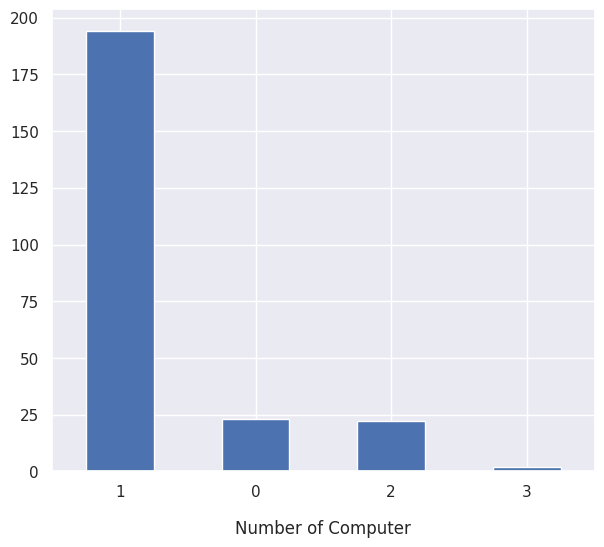

In [ ]:
# C6 : Number of computer of  the first student
sns.set(font_scale=1.0)
df2['C6'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Number of Computer", labelpad=14)
#plt.ylabel("Count of Room", labelpad=14)
exploration('C6')

In [ ]:
# C7-1 : Desktop of  the first student
print('Missing Value = ',df2['C7-1'].isnull().sum())
exploration('C7-1')

Missing Value =  0


0    221
1     20
Name: C7-1, dtype: int64

0    221
1     20
Name: C7-1, dtype: int64

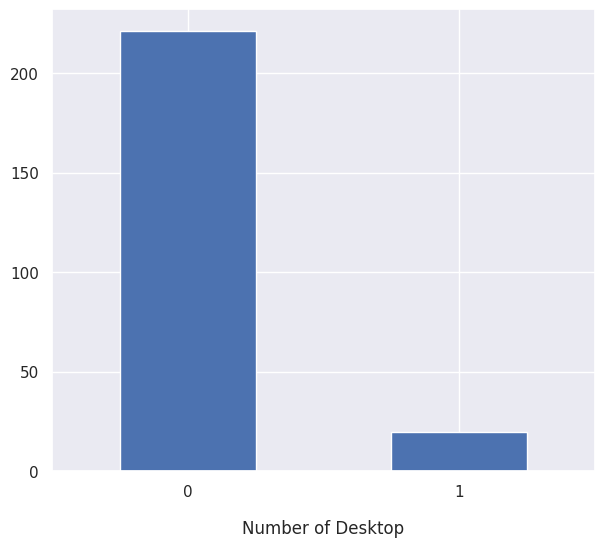

In [ ]:
# C7-1 : Desktop of  the first student
sns.set(font_scale=1.0)
df2['C7-1'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Number of Desktop", labelpad=14)
#plt.ylabel("Count of Room", labelpad=14)
exploration('C7-1')

In [ ]:
# C7-2 : Notebook of  the first student
print('Missing Value = ',df2['C7-2'].isnull().sum())
exploration('C7-2')

Missing Value =  0


1    195
0     32
2     13
3      1
Name: C7-2, dtype: int64

1    195
0     32
2     13
3      1
Name: C7-2, dtype: int64

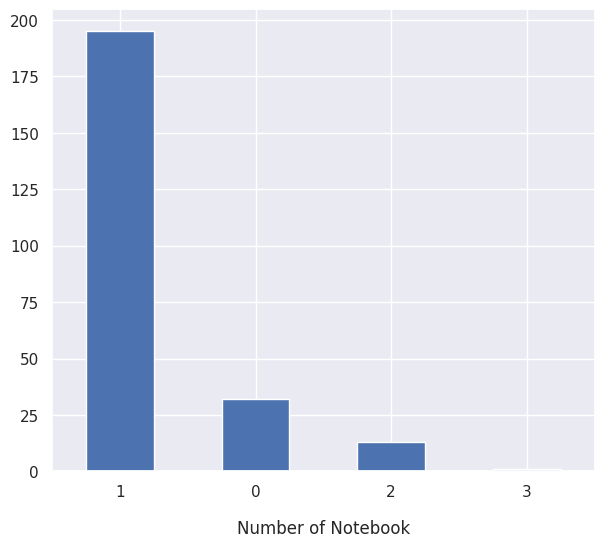

In [ ]:
# C7-2 : Notebook of  the first student
sns.set(font_scale=1.0)
df2['C7-2'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Number of Notebook", labelpad=14)
#plt.ylabel("Count of Room", labelpad=14)
exploration('C7-2')

In [ ]:
# C8-1, C8-2, C8-3, C8-4
pd.DataFrame(df2[['C8-1','C8-2','C8-3','C8-4']].loc[df2['C8-4'].isnull()])

C8-1  C8-2  C8-3  C8-4
47    NaN   NaN   NaN   NaN
51    NaN   NaN   NaN   NaN
137   1.0   NaN   NaN   NaN

In [ ]:
# C8-1 : Window system of  the first student
print('Missing Value = ',df2['C8-1'].isnull().sum())
exploration('C8-1')

Missing Value =  2


1.0    182
0.0     44
2.0     13
Name: C8-1, dtype: int64

In [ ]:
# C8-2 : Mac system of  the first student
print('Missing Value = ',df2['C8-2'].isnull().sum())
exploration('C8-2')

Missing Value =  3


0.0    208
1.0     30
Name: C8-2, dtype: int64

In [ ]:
# C8-3 : Linux system of  the first student
print('Missing Value = ',df2['C8-3'].isnull().sum())
exploration('C8-3')

Missing Value =  3


0.0    237
1.0      1
Name: C8-3, dtype: int64

In [ ]:
# C8-4 : Android system of  the first student
print('Missing Value = ',df2['C8-4'].isnull().sum())
exploration('C8-4')

Missing Value =  3


0.0    236
1.0      2
Name: C8-4, dtype: int64

In [ ]:
# ดูว่า system ที่ Null มาจากจำนวนคอมกี่เครื่อง
df2[['id','C6','C7-1','C7-2','C8-1','C8-2','C8-3','C8-4']].loc[df2['C8-4'].isnull()]

id  C6  C7-1  C7-2  C8-1  C8-2  C8-3  C8-4
47   mb14   1     1     0   NaN   NaN   NaN   NaN
51   mb52   1     0     1   NaN   NaN   NaN   NaN
137  ma13   2     1     1   1.0   NaN   NaN   NaN

In [ ]:
# ดูฐานนิยมของ system ที่มีจำนวนคอม 1 เครื่อง
pd.DataFrame(df2[['C8-1','C8-2','C8-3','C8-4']].loc[df2['C6'] == 1].value_counts())

0
C8-1 C8-2 C8-3 C8-4     
1.0  0.0  0.0  0.0   171
0.0  1.0  0.0  0.0    21

In [ ]:
# ดูฐานนิยมของ system ที่มีจำนวนคอม 2 เครื่อง
pd.DataFrame(df2[['C8-1','C8-2','C8-3','C8-4']].loc[df2['C6'] == 2].value_counts())

0
C8-1 C8-2 C8-3 C8-4    
2.0  0.0  0.0  0.0   12
1.0  1.0  0.0  0.0    8
     0.0  1.0  0.0    1

In [ ]:
# C8-1, C8-2, C8-3, C8-4 : impute
df2.loc[df2['C8-1'].isnull() & df2['C6']==1 ,'C8-1'] = 1
df2.loc[df2['C8-2'].isnull() & df2['C6']==1 ,'C8-2'] = 0
df2.loc[df2['C8-3'].isnull() & df2['C6']==1 ,'C8-3'] = 0
df2.loc[df2['C8-4'].isnull() & df2['C6']==1 ,'C8-4'] = 0

df2.loc[df2['id']=='ma13' ,'C8-1'] = 2
df2.loc[df2['id']=='ma13' ,'C8-2'] = 0
df2.loc[df2['id']=='ma13' ,'C8-3'] = 0
df2.loc[df2['id']=='ma13' ,'C8-4'] = 0

# check missing value again
pd.DataFrame(df2[['C8-1','C8-2','C8-3','C8-4']].loc[df2['C8-4'].isnull()])

Empty DataFrame
Columns: [C8-1, C8-2, C8-3, C8-4]
Index: []

In [ ]:
# C13 : Number of computer of  the second student
print('Missing Value = ',df2['C13'].isnull().sum())
exploration('C13')

Missing Value =  9


1.0    141
0.0     81
2.0      9
3.0      1
Name: C13, dtype: int64

In [ ]:
df2[['C1','C13']].loc[df2['C13'].isnull()]

C1  C13
20    2  NaN
28    2  NaN
56    2  NaN
65    2  NaN
66    2  NaN
68    2  NaN
72    2  NaN
86    2  NaN
132   2  NaN

In [ ]:
df2[['C1','C13']].loc[df2['C1']==2].value_counts()

C1  C13
2   1.0    141
    0.0     38
    2.0      9
    3.0      1
dtype: int64

In [ ]:
# C13 : impute
imputation('C13',1)
# check missing value again
df2[['C1','C13']].loc[df2['C13'].isnull()]

Empty DataFrame
Columns: [C1, C13]
Index: []

1.0    150
0.0     81
2.0      9
3.0      1
Name: C13, dtype: int64

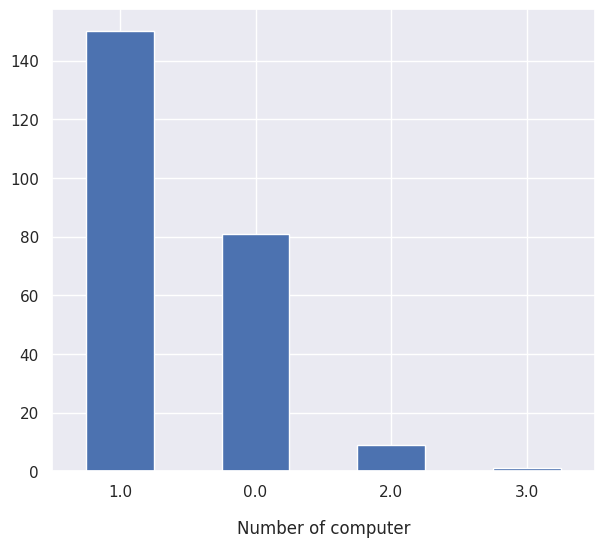

In [ ]:
# C13 = Number of computer of  the second student
sns.set(font_scale=1.0)
df2['C13'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Number of computer", labelpad=14)
#plt.ylabel("Count of Student", labelpad=14)
exploration('C13')

In [ ]:
# C14-1 : Desktop of  the second student
print('Missing Value = ',df2['C14-1'].isnull().sum())
exploration('C14-1')

Missing Value =  9


0.0    218
1.0     14
Name: C14-1, dtype: int64

In [ ]:
# C14-2 : Notebook of  the second student
print('Missing Value = ',df2['C14-2'].isnull().sum())
exploration('C14-2')

Missing Value =  9


1.0    136
0.0     90
2.0      6
Name: C14-2, dtype: int64

In [ ]:
df2[['C1','C13','C14-1','C14-2']].loc[df2['C14-2'].isnull()]

C1  C13  C14-1  C14-2
20    2  1.0    NaN    NaN
28    2  1.0    NaN    NaN
56    2  1.0    NaN    NaN
65    2  1.0    NaN    NaN
66    2  1.0    NaN    NaN
68    2  1.0    NaN    NaN
72    2  1.0    NaN    NaN
86    2  1.0    NaN    NaN
132   2  1.0    NaN    NaN

In [ ]:
# Desktop, Notebook of first member
pd.DataFrame(df2[['C6','C7-1','C7-2']].value_counts())

0
C6 C7-1 C7-2     
1  0    1     185
0  0    0      23
2  0    2      12
   1    1      10
1  1    0       9
3  0    3       1
   1    2       1

In [ ]:
# Desktop, Notebook of second member
pd.DataFrame(df2[['C13','C14-1','C14-2']].value_counts())

0
C13 C14-1 C14-2     
1.0 0.0   1.0    132
0.0 0.0   0.0     81
1.0 1.0   0.0      9
2.0 0.0   2.0      5
    1.0   1.0      4
3.0 1.0   2.0      1

In [ ]:
# C14-1, C14-2 : impute
imputation('C14-1',0)
imputation('C14-2',1)

# check missing value again
pd.DataFrame(df2[['C1','C13','C14-1','C14-2']].loc[df2['C14-2'].isnull()])

Empty DataFrame
Columns: [C1, C13, C14-1, C14-2]
Index: []

0.0    227
1.0     14
Name: C14-1, dtype: int64

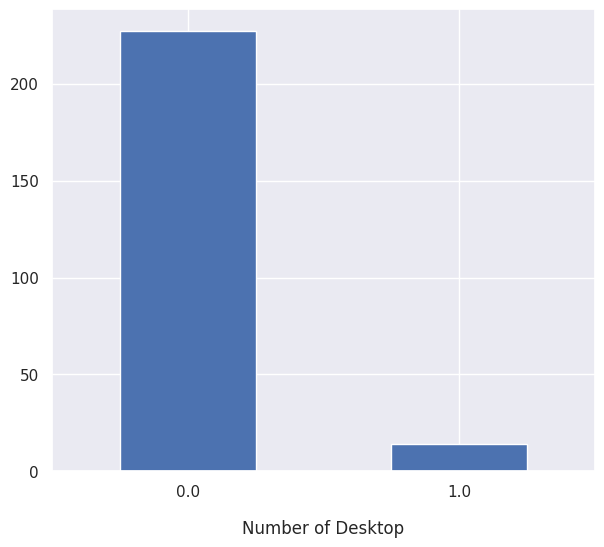

In [ ]:
# C14-1 : Desktop of  the second student
sns.set(font_scale=1.0)
df2['C14-1'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Number of Desktop", labelpad=14)
#plt.ylabel("Count of Room", labelpad=14)
exploration('C14-1')

1.0    145
0.0     90
2.0      6
Name: C14-2, dtype: int64

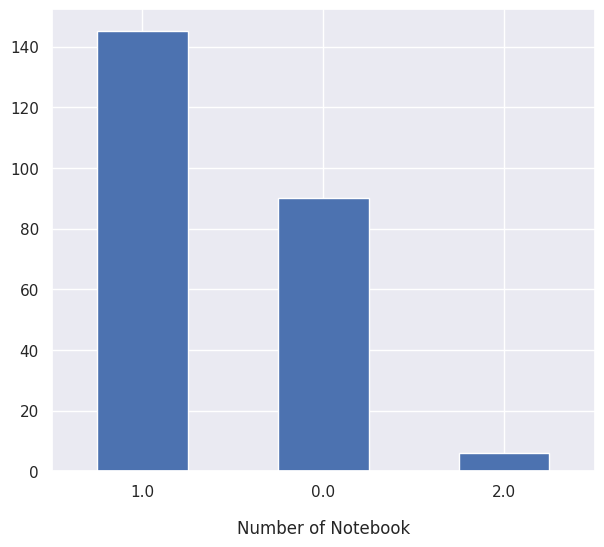

In [ ]:
# C14-2 : Notebook of  the second student
sns.set(font_scale=1.0)
df2['C14-2'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Number of Notebook", labelpad=14)
#plt.ylabel("Count of Room", labelpad=14)
exploration('C14-2')

In [ ]:
# C15-1 : Window of  the second student
print('Missing Value = ',df2['C15-1'].isnull().sum())
exploration('C15-1')

Missing Value =  13


1.0    130
0.0     95
2.0      3
Name: C15-1, dtype: int64

In [ ]:
# C15-2 : Mac of  the second student
print('Missing Value = ',df2['C15-2'].isnull().sum())
exploration('C15-2')

Missing Value =  12


0.0    211
1.0     17
2.0      1
Name: C15-2, dtype: int64

In [ ]:
# C15-3 : Linux of  the second student
print('Missing Value = ',df2['C15-3'].isnull().sum())
exploration('C15-3')

Missing Value =  13


0.0    228
Name: C15-3, dtype: int64

In [ ]:
# C15-4 : Android of  the second student
print('Missing Value = ',df2['C15-4'].isnull().sum())
exploration('C15-4')

Missing Value =  13


0.0    227
2.0      1
Name: C15-4, dtype: int64

In [ ]:
df2[['id','C13','C15-1','C15-2','C15-3','C15-4']].loc[df2['C15-4'].isnull()]

id  C13  C15-1  C15-2  C15-3  C15-4
20   mb38  1.0    NaN    NaN    NaN    NaN
28   mb46  1.0    NaN    NaN    NaN    NaN
47   mb14  2.0    NaN    NaN    NaN    NaN
50   mb17  1.0    NaN    NaN    NaN    NaN
51   mb52  1.0    NaN    NaN    NaN    NaN
56   mb57  1.0    NaN    NaN    NaN    NaN
65    gb6  1.0    NaN    NaN    NaN    NaN
66    gb7  1.0    NaN    NaN    NaN    NaN
68    gb9  1.0    NaN    NaN    NaN    NaN
72   gb13  1.0    NaN    NaN    NaN    NaN
86   gb27  1.0    NaN    NaN    NaN    NaN
132   ma8  1.0    NaN    NaN    NaN    NaN
137  ma13  2.0    NaN    1.0    NaN    NaN

In [ ]:
# computer system of first member
pd.DataFrame(df2[['C6','C8-1','C8-2','C8-3','C8-4']].value_counts())

0
C6 C8-1 C8-2 C8-3 C8-4     
1  1.0  0.0  0.0  0.0   173
0  0.0  0.0  0.0  0.0    23
1  0.0  1.0  0.0  0.0    21
2  2.0  0.0  0.0  0.0    13
   1.0  1.0  0.0  0.0     8
        0.0  1.0  0.0     1
3  1.0  1.0  0.0  1.0     1
   2.0  0.0  0.0  1.0     1

In [ ]:
# computer system of second member
pd.DataFrame(df2[['C13','C15-1','C15-2','C15-3','C15-4']].value_counts())

0
C13 C15-1 C15-2 C15-3 C15-4     
1.0 1.0   0.0   0.0   0.0    126
0.0 0.0   0.0   0.0   0.0     81
1.0 0.0   1.0   0.0   0.0     13
2.0 1.0   1.0   0.0   0.0      3
    2.0   0.0   0.0   0.0      3
    0.0   2.0   0.0   0.0      1
3.0 1.0   0.0   0.0   2.0      1

In [ ]:
# C15-1, C15-2, C15-3, C15-4 : impute
df2.loc[df2['C15-1'].isnull() & df2['C13']==1 ,'C15-1'] = 1
df2.loc[df2['C15-2'].isnull() & df2['C13']==1 ,'C15-2'] = 0
df2.loc[df2['C15-3'].isnull() & df2['C13']==1 ,'C15-3'] = 0
df2.loc[df2['C15-4'].isnull() & df2['C13']==1 ,'C15-4'] = 0

df2.loc[df2['id']=='mb14' ,'C15-1'] = 2
df2.loc[df2['id']=='mb14' ,'C15-2'] = 0
df2.loc[df2['id']=='mb14' ,'C15-3'] = 0
df2.loc[df2['id']=='mb14' ,'C15-4'] = 0

df2.loc[df2['id']=='ma13' ,'C15-1'] = 1
df2.loc[df2['id']=='ma13' ,'C15-2'] = 1
df2.loc[df2['id']=='ma13' ,'C15-3'] = 0
df2.loc[df2['id']=='ma13' ,'C15-4'] = 0

# check missing value again
df2[['id','C13','C15-1','C15-2','C15-3','C15-4']].loc[df2['C15-4'].isnull()]

Empty DataFrame
Columns: [id, C13, C15-1, C15-2, C15-3, C15-4]
Index: []

**Impute Missing value : Room type**

In [ ]:
# R1 : Drom type
print('Missing Value = ',df2['R1'].isnull().sum())
exploration('R1')

Missing Value =  0


0    122
1    119
Name: R1, dtype: int64

0    122
1    119
Name: R1, dtype: int64

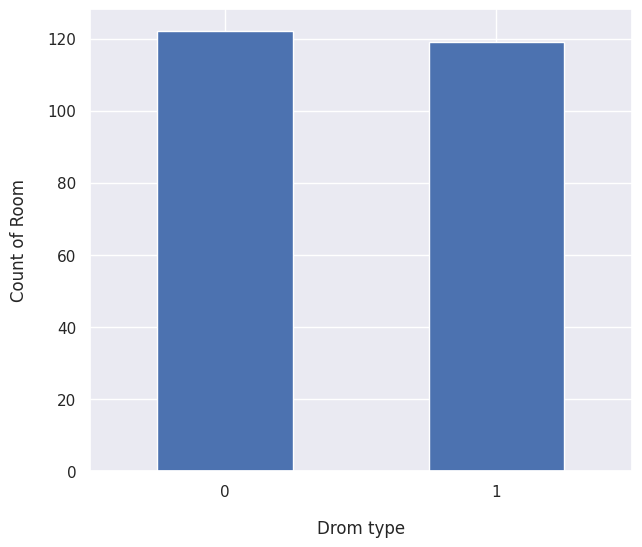

In [ ]:
# R1 : Drom type
sns.set(font_scale=1.0)
df2['R1'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Drom type", labelpad=14)
plt.ylabel("Count of Room", labelpad=14)
exploration('R1')

In [ ]:
# R2 : Floor
print('Missing Value = ',df2['R2'].isnull().sum())
exploration('R2')

Missing Value =  2


3.0    60
5.0    51
2.0    49
4.0    42
1.0    37
Name: R2, dtype: int64

In [ ]:
# R2 : Floor
imputation('R2',3)
print('Missing Value = ',df2['R2'].isnull().sum())

Missing Value =  0


3.0    62
5.0    51
2.0    49
4.0    42
1.0    37
Name: R2, dtype: int64

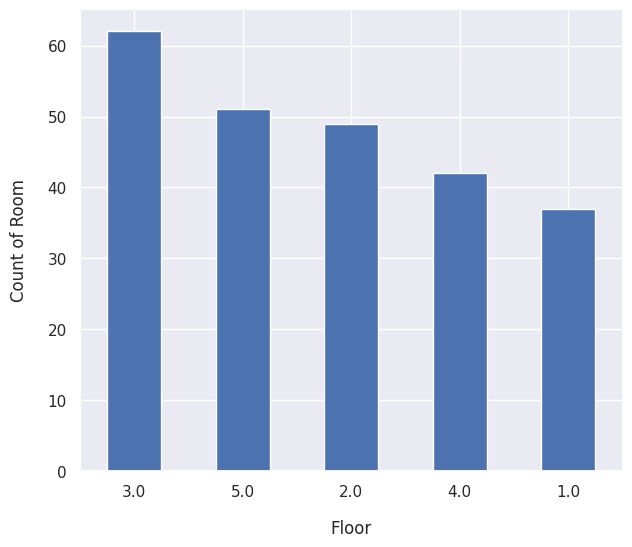

In [ ]:
# R2 : Floor
sns.set(font_scale=1.0)
df2['R2'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Floor", labelpad=14)
plt.ylabel("Count of Room", labelpad=14)
exploration('R2')

In [ ]:
# R3 : Fridge
print('Missing Value = ',df2['R3'].isnull().sum())
exploration('R3')

Missing Value =  11


0.0    198
1.0     32
Name: R3, dtype: int64

In [ ]:
# R3 : Fridge
imputation('R3',0)
print('Missing Value = ',df2['R3'].isnull().sum())

Missing Value =  0


0.0    209
1.0     32
Name: R3, dtype: int64

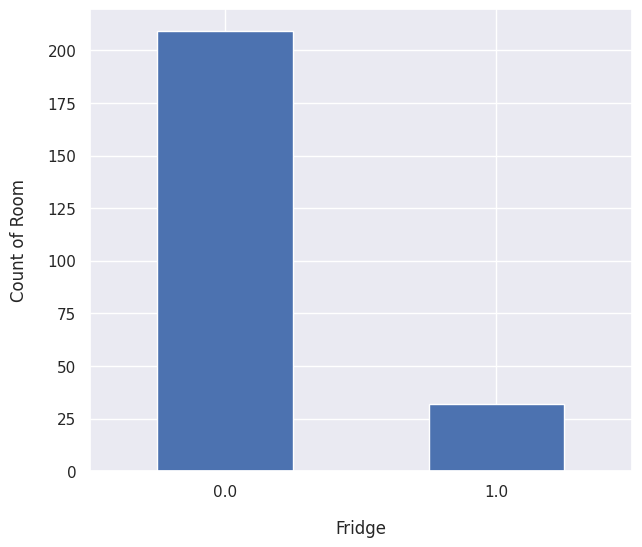

In [ ]:
# R3 : Fridge
sns.set(font_scale=1.0)
df2['R3'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Fridge", labelpad=14)
plt.ylabel("Count of Room", labelpad=14)
exploration('R3')

In [ ]:
# R5 : Electricity cost range
print('Missing Value = ',df2['R5'].isnull().sum())
exploration('R5')

Missing Value =  4


2.0    192
1.0     36
3.0      9
Name: R5, dtype: int64

In [ ]:
# R5 : Electricity cost range
imputation('R5',2)
print('Missing Value = ',df2['R5'].isnull().sum())

Missing Value =  0


2.0    196
1.0     36
3.0      9
Name: R5, dtype: int64

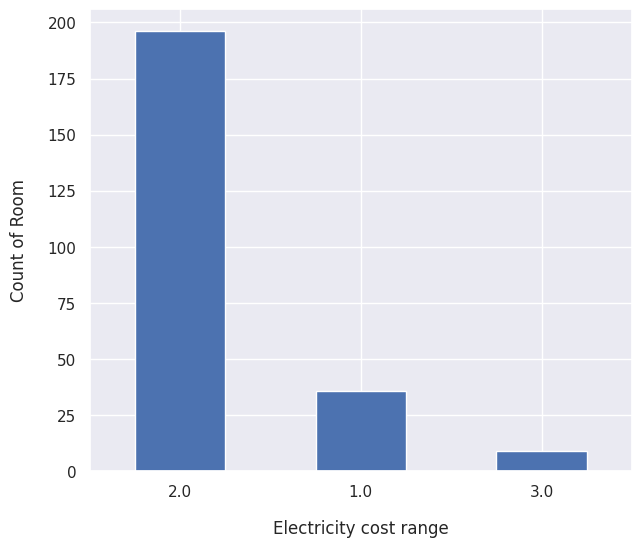

In [ ]:
# R5 : Electricity cost range
sns.set(font_scale=1.0)
df2['R5'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Electricity cost range", labelpad=14)
plt.ylabel("Count of Room", labelpad=14)
exploration('R5')

In [ ]:
# R4 : Electricity cost
print('Missing Value = ',df2['R4'].isnull().sum())

Missing Value =  17


In [ ]:
df2['R4'].describe()

count     224.000000
mean      466.687500
std       235.519863
min        36.000000
25%       300.000000
50%       447.000000
75%       600.000000
max      1600.000000
Name: R4, dtype: float64

In [ ]:
# Missing value = 17 samples
df2[['id','R5','R4']].loc[df2['R4'].isnull()]

id   R5  R4
5    mb23  2.0 NaN
16   mb34  2.0 NaN
20   mb38  2.0 NaN
24   mb42  2.0 NaN
30   mb48  2.0 NaN
39    mb6  2.0 NaN
70   gb11  2.0 NaN
72   gb13  2.0 NaN
80   gb21  2.0 NaN
111  gb52  3.0 NaN
120  gb61  2.0 NaN
127   ma3  2.0 NaN
137  ma13  2.0 NaN
152  ma28  1.0 NaN
159  ma35  1.0 NaN
161  ma37  2.0 NaN
177  ma53  2.0 NaN

In [ ]:
# R5 : range1 = น้อยกว่า 250 บาท
range1=pd.DataFrame(df2['R4'].loc[df2['R5']==1])
range1.describe()

R4
count   34.000000
mean   172.147059
std     59.412340
min     36.000000
25%    130.500000
50%    183.000000
75%    221.000000
max    250.000000

In [ ]:
# R5 : range2 = 251-950 บาท
range2=pd.DataFrame(df2['R4'].loc[df2['R5']==2])
range2.describe()

R4
count  182.000000
mean   490.379121
std    162.619184
min    200.000000
25%    348.000000
50%    483.000000
75%    600.000000
max    936.000000

In [ ]:
# R5 : range3 = 951-1,650 บาท
range3=pd.DataFrame(df2['R4'].loc[df2['R5']==3])
range3.describe()

R4
count     8.000000
mean   1179.500000
std     223.634268
min    1000.000000
25%    1000.000000
50%    1109.000000
75%    1263.500000
max    1600.000000

In [ ]:
# R4 : impute

# range1 : impute by mean
range1_mean = round(df2['R4'].loc[df2['R5']==1].describe()[1],2)
df2.loc[(df2['R4'].isnull()) & (df2['R5']==1),'R4'] = range1_mean

# range2 : impute by mean
range2_mean = round(df2['R4'].loc[df2['R5']==2].describe()[1],2)
df2.loc[(df2['R4'].isnull()) & (df2['R5']==2),'R4'] = range2_mean

# range2 : impute by mean
range3_mean = round(df2['R4'].loc[df2['R5']==3].describe()[1],2)
df2.loc[(df2['R4'].isnull()) & (df2['R5']==3),'R4'] = range3_mean

print('Missing Value = ',df2['R4'].isnull().sum())

Missing Value =  0


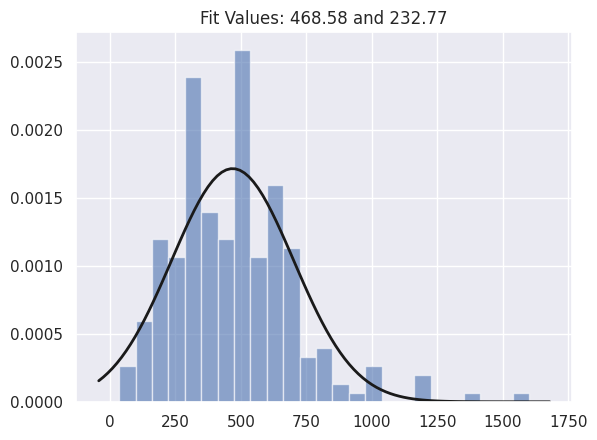

In [ ]:
# R4 : Electricity cost
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
  
# Generate some data for this 
# demonstration.
data = df2['R4']
  
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(data) 
  
# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

**Impute Missing value : Occupant Behavior**

In [ ]:
# B1 
print('Missing Value = ',df2['B1'].isnull().sum())
exploration('B1')

Missing Value =  1


1.0    99
3.0    82
4.0    33
2.0    26
Name: B1, dtype: int64

In [ ]:
# B1 : impute
imputation('B1',1)
print('Missing Value = ',df2['B1'].isnull().sum())

Missing Value =  0


1.0    100
3.0     82
4.0     33
2.0     26
Name: B1, dtype: int64

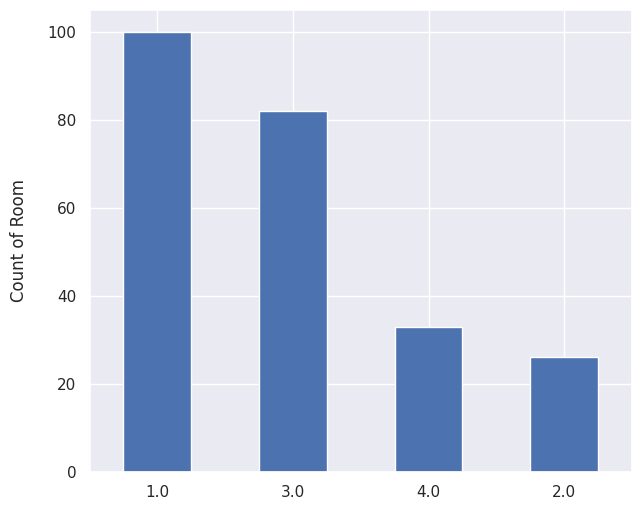

In [ ]:
# B1
sns.set(font_scale=1.0)
df2['B1'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B1')

In [ ]:
# B2
print('Missing Value = ',df2['B2'].isnull().sum())
exploration('B2')

Missing Value =  8


25.0    116
26.0     43
24.0     19
27.0     18
25.5     10
24.5      8
23.0      6
26.5      6
20.0      3
23.5      2
22.5      1
22.0      1
Name: B2, dtype: int64

In [ ]:
df2['B2'].describe()

count    233.000000
mean      25.148069
std        1.070050
min       20.000000
25%       25.000000
50%       25.000000
75%       26.000000
max       27.000000
Name: B2, dtype: float64

In [ ]:
# B2 : impute
imputation('B2',df2['B2'].describe()[1])
print('Missing Value = ',df2['B2'].isnull().sum())

Missing Value =  0


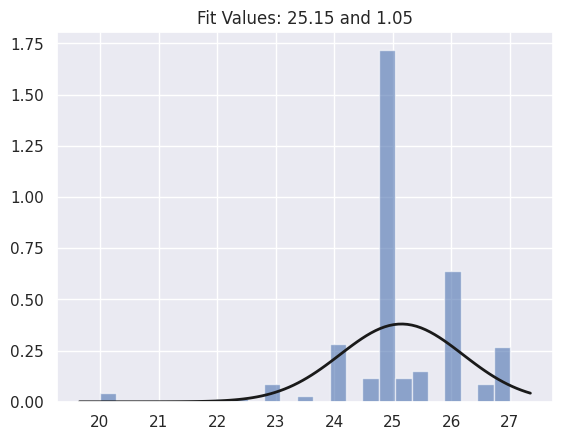

In [ ]:
# B2 : Tempearture
 
# Generate some data for this 
# demonstration.
data = df2['B2']
  
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(data) 
  
# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

In [ ]:
# B3 
print('Missing Value = ',df2['B3'].isnull().sum())
exploration('B3')

Missing Value =  0


5.0    93
4.0    46
1.0    40
3.0    34
2.0    28
Name: B3, dtype: int64

5.0    93
4.0    46
1.0    40
3.0    34
2.0    28
Name: B3, dtype: int64

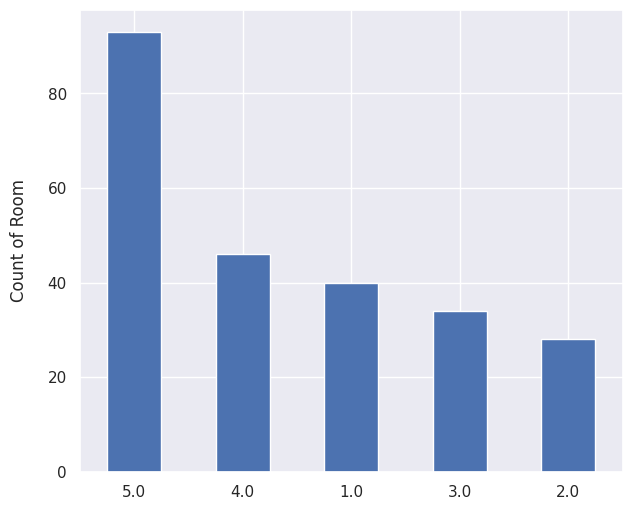

In [ ]:
# B3
sns.set(font_scale=1.0)
df2['B3'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B3')

In [ ]:
# B4 
print('Missing Value = ',df2['B4'].isnull().sum())
exploration('B4')

Missing Value =  1


1.0    153
2.0     41
3.0     28
4.0     13
5.0      5
Name: B4, dtype: int64

In [ ]:
# B4 : impute
imputation('B4',1)
print('Missing Value = ',df2['B4'].isnull().sum())

Missing Value =  0


1.0    154
2.0     41
3.0     28
4.0     13
5.0      5
Name: B4, dtype: int64

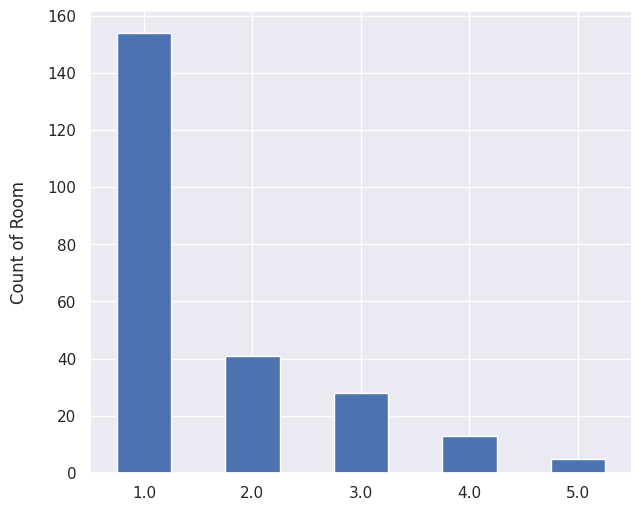

In [ ]:
# B4
sns.set(font_scale=1.0)
df2['B4'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B4')

In [ ]:
# B5 
print('Missing Value = ',df2['B5'].isnull().sum())
exploration('B5')

Missing Value =  2


1.0    197
2.0     15
3.0     13
4.0      7
5.0      7
Name: B5, dtype: int64

In [ ]:
# B5 : impute
imputation('B5',1)
print('Missing Value = ',df2['B5'].isnull().sum())

Missing Value =  0


1.0    199
2.0     15
3.0     13
4.0      7
5.0      7
Name: B5, dtype: int64

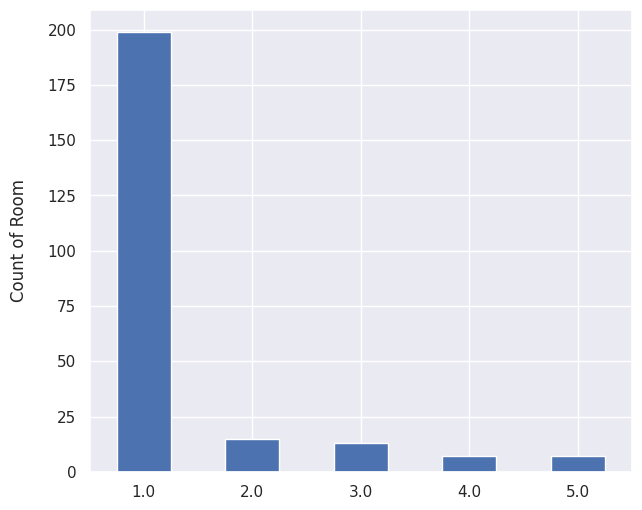

In [ ]:
# B5
sns.set(font_scale=1.0)
df2['B5'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B5')

In [ ]:
# B6
print('Missing Value = ',df2['B6'].isnull().sum())
exploration('B6')

Missing Value =  1


1.0    147
2.0     44
3.0     20
4.0     17
5.0     12
Name: B6, dtype: int64

In [ ]:
# B6 : impute
imputation('B6',1)
print('Missing Value = ',df2['B6'].isnull().sum())

Missing Value =  0


1.0    148
2.0     44
3.0     20
4.0     17
5.0     12
Name: B6, dtype: int64

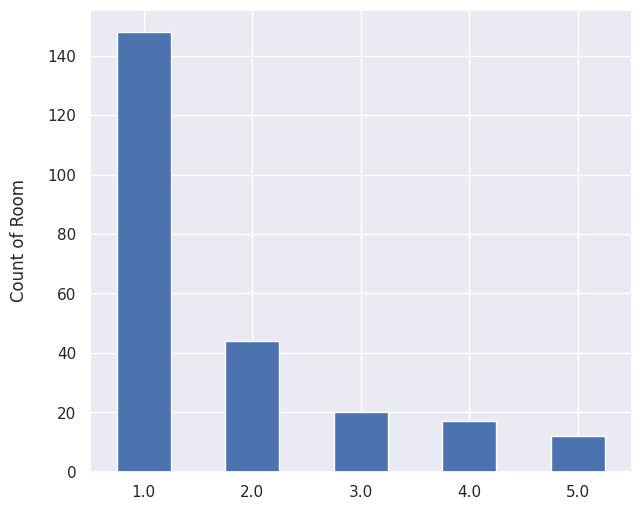

In [ ]:
# B6
sns.set(font_scale=1.0)
df2['B6'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B6')

In [ ]:
# B7
print('Missing Value = ',df2['B7'].isnull().sum())
exploration('B7')

Missing Value =  0


3.0    92
1.0    77
2.0    45
4.0    27
Name: B7, dtype: int64

3.0    92
1.0    77
2.0    45
4.0    27
Name: B7, dtype: int64

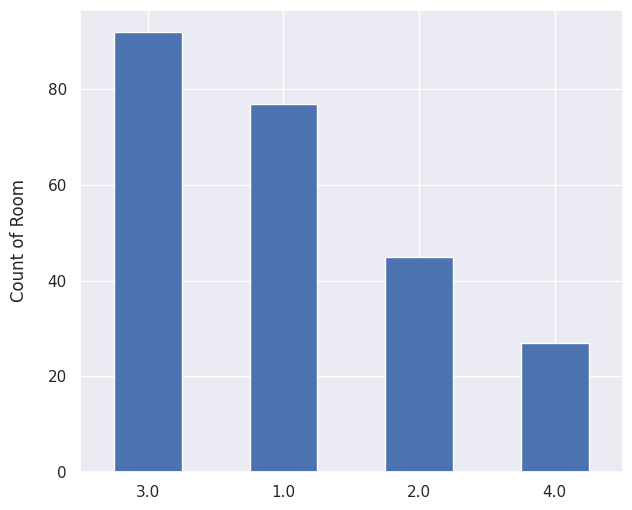

In [ ]:
# B7
sns.set(font_scale=1.0)
df2['B7'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B7')

In [ ]:
# B8
print('Missing Value = ',df2['B8'].isnull().sum())
exploration('B8')

Missing Value =  0


1.0    118
3.0     61
2.0     41
4.0     21
Name: B8, dtype: int64

1.0    118
3.0     61
2.0     41
4.0     21
Name: B8, dtype: int64

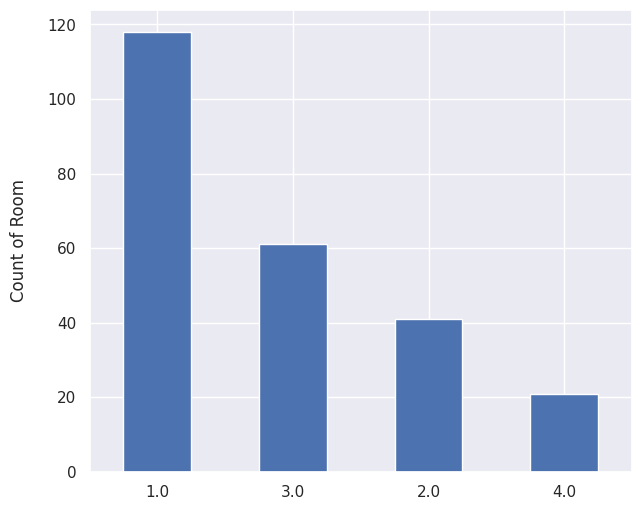

In [ ]:
# B8
sns.set(font_scale=1.0)
df2['B8'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B8')

In [ ]:
# B9
print('Missing Value = ',df2['B9'].isnull().sum())
exploration('B9')

Missing Value =  0


1    74
5    50
4    45
3    37
2    35
Name: B9, dtype: int64

1    74
5    50
4    45
3    37
2    35
Name: B9, dtype: int64

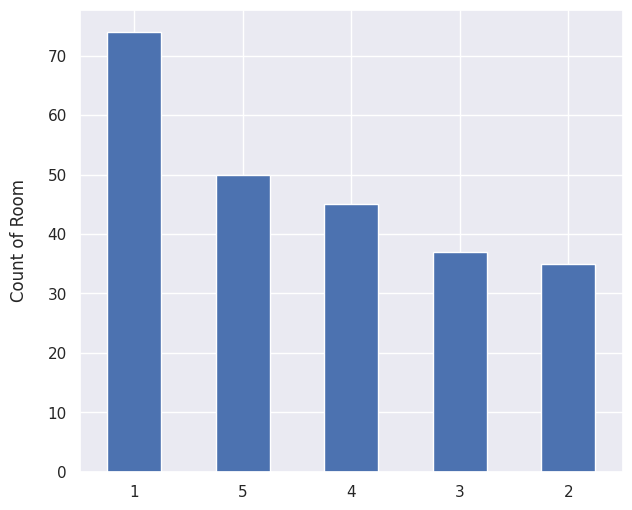

In [ ]:
# B9
sns.set(font_scale=1.0)
df2['B9'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B9')

In [ ]:
# B10
print('Missing Value = ',df2['B10'].isnull().sum())
exploration('B10')

Missing Value =  0


5    113
4     54
3     46
2     18
1     10
Name: B10, dtype: int64

5    113
4     54
3     46
2     18
1     10
Name: B10, dtype: int64

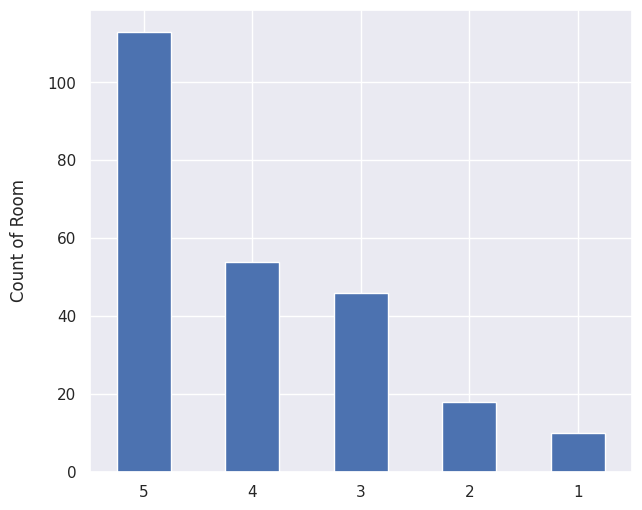

In [ ]:
# B10
sns.set(font_scale=1.0)
df2['B10'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('B10')

**Impute Missing value : Knowledge of Electricity**

In [ ]:
# K1
print('Missing Value = ',df2['K1'].isnull().sum())
exploration('K1')

Missing Value =  4


3.0    158
2.0     47
4.0     26
1.0      4
5.0      2
Name: K1, dtype: int64

In [ ]:
# K1 : impute
imputation('K1',3)
print('Missing Value = ',df2['K1'].isnull().sum())

Missing Value =  0


3.0    162
2.0     47
4.0     26
1.0      4
5.0      2
Name: K1, dtype: int64

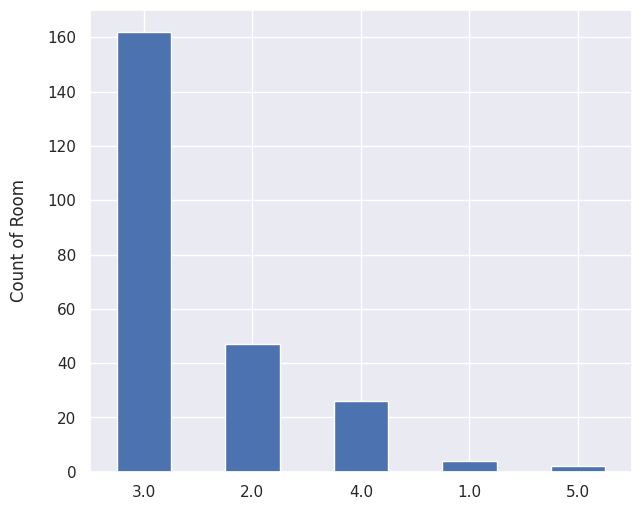

In [ ]:
# K1
sns.set(font_scale=1.0)
df2['K1'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('K1')

In [ ]:
# K2
print('Missing Value = ',df2['K2'].isnull().sum())
exploration('K2')

Missing Value =  0


1.0    129
2.0     73
0.0     39
Name: K2, dtype: int64

1.0    129
2.0     73
0.0     39
Name: K2, dtype: int64

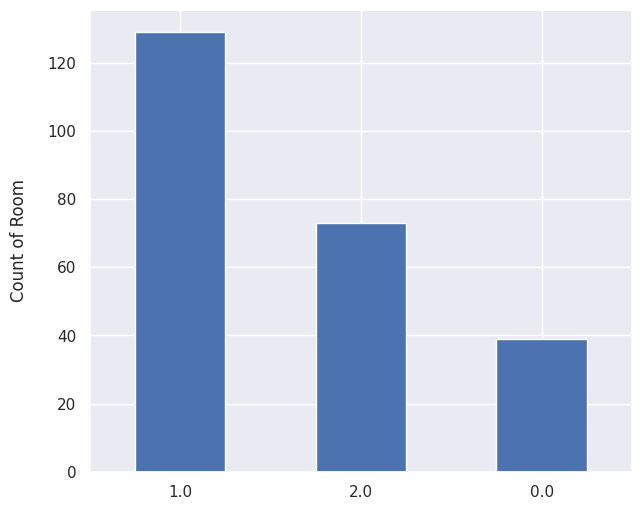

In [ ]:
# K2
sns.set(font_scale=1.0)
df2['K2'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('K2')

In [ ]:
# K3
print('Missing Value = ',df2['K3'].isnull().sum())
exploration('K3')

Missing Value =  0


1.0    169
2.0     43
0.0     29
Name: K3, dtype: int64

1.0    169
2.0     43
0.0     29
Name: K3, dtype: int64

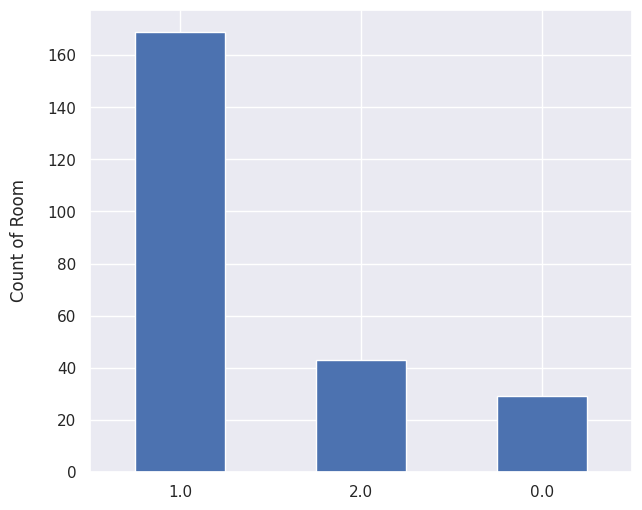

In [ ]:
# K3
sns.set(font_scale=1.0)
df2['K3'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('K3')

In [ ]:
# K4
print('Missing Value = ',df2['K4'].isnull().sum())
exploration('K4')

Missing Value =  1


0.0    216
2.0     17
1.0      7
Name: K4, dtype: int64

In [ ]:
# K4 : impute
imputation('K4',0)
print('Missing Value = ',df2['K4'].isnull().sum())

Missing Value =  0


0.0    217
2.0     17
1.0      7
Name: K4, dtype: int64

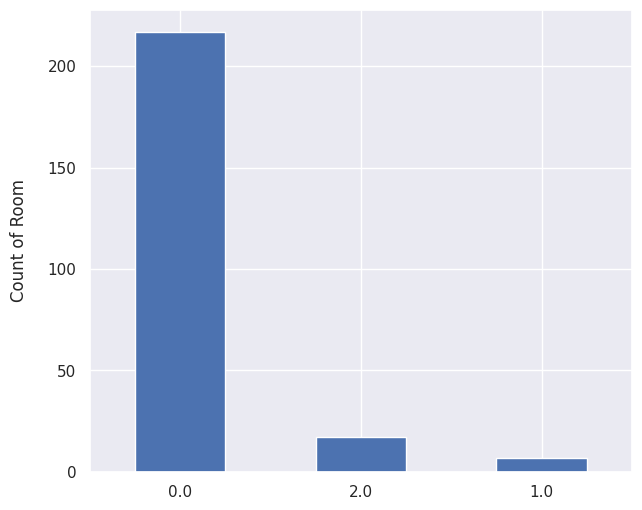

In [ ]:
# K4
sns.set(font_scale=1.0)
df2['K4'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('K4')

In [ ]:
# K5
print('Missing Value = ',df2['K5'].isnull().sum())
exploration('K5')

Missing Value =  0


1.0    218
0.0     12
2.0     11
Name: K5, dtype: int64

1.0    218
0.0     12
2.0     11
Name: K5, dtype: int64

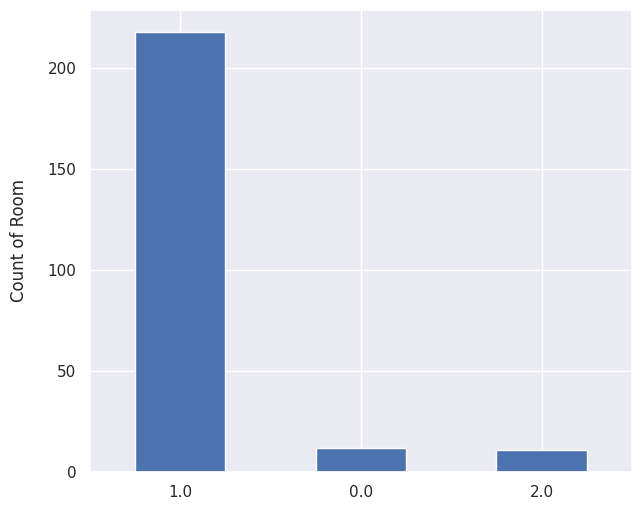

In [ ]:
# K5
sns.set(font_scale=1.0)
df2['K5'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('K5')

**Impute Missing value : Attitude**

In [ ]:
# A1
print('Missing Value = ',df2['A1'].isnull().sum())
exploration('A1')

Missing Value =  0


4    119
5     80
3     40
2      1
1      1
Name: A1, dtype: int64

4    119
5     80
3     40
2      1
1      1
Name: A1, dtype: int64

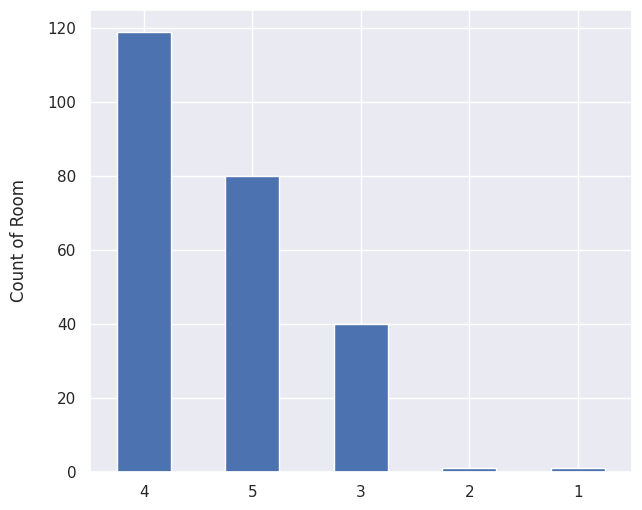

In [ ]:
# A1
sns.set(font_scale=1.0)
df2['A1'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('A1')

In [ ]:
# A2
print('Missing Value = ',df2['A2'].isnull().sum())
exploration('A2')

Missing Value =  0


4    89
5    85
3    49
2    13
1     5
Name: A2, dtype: int64

4    89
5    85
3    49
2    13
1     5
Name: A2, dtype: int64

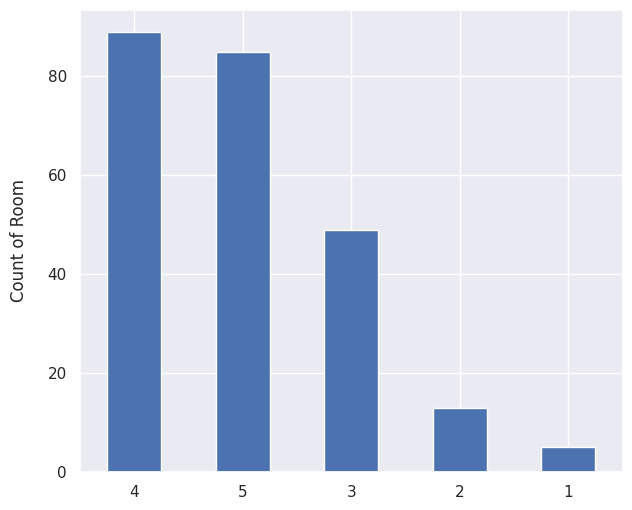

In [ ]:
# A2
sns.set(font_scale=1.0)
df2['A2'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('A2')

In [ ]:
# A3
print('Missing Value = ',df2['A3'].isnull().sum())
exploration('A3')

Missing Value =  2


5.0    144
4.0     61
3.0     32
1.0      2
Name: A3, dtype: int64

In [ ]:
# A3 : impute
imputation('A3',5)
print('Missing Value = ',df2['A3'].isnull().sum())

Missing Value =  0


5.0    146
4.0     61
3.0     32
1.0      2
Name: A3, dtype: int64

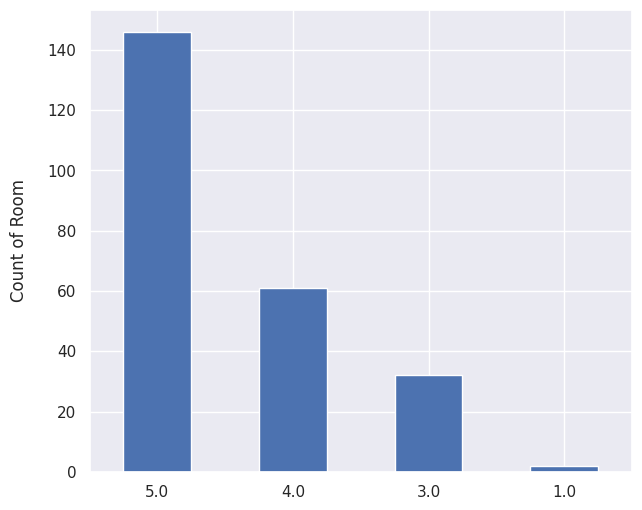

In [ ]:
# A3
sns.set(font_scale=1.0)
df2['A3'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('A3')

In [ ]:
# A4
print('Missing Value = ',df2['A4'].isnull().sum())
exploration('A4')

Missing Value =  1


3.0    105
4.0     58
2.0     31
5.0     29
1.0     17
Name: A4, dtype: int64

In [ ]:
# A4 : impute
imputation('A4',3)
print('Missing Value = ',df2['A4'].isnull().sum())

Missing Value =  0


3.0    106
4.0     58
2.0     31
5.0     29
1.0     17
Name: A4, dtype: int64

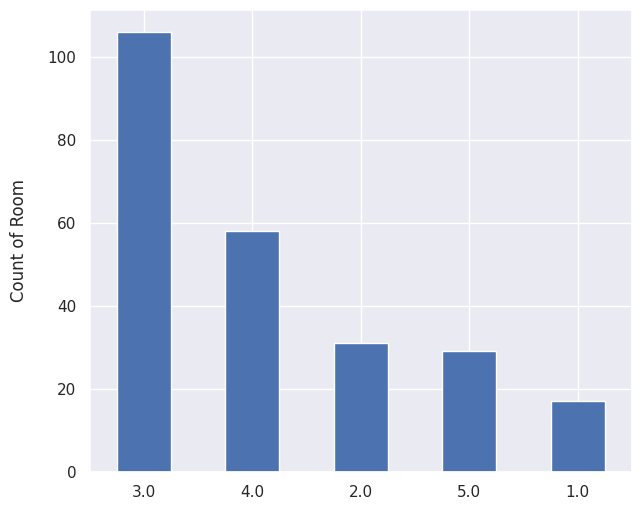

In [ ]:
# A4
sns.set(font_scale=1.0)
df2['A4'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('A4')

In [ ]:
# A5
print('Missing Value = ',df2['A5'].isnull().sum())
exploration('A5')

Missing Value =  0


5    88
4    65
3    59
2    16
1    13
Name: A5, dtype: int64

5    88
4    65
3    59
2    16
1    13
Name: A5, dtype: int64

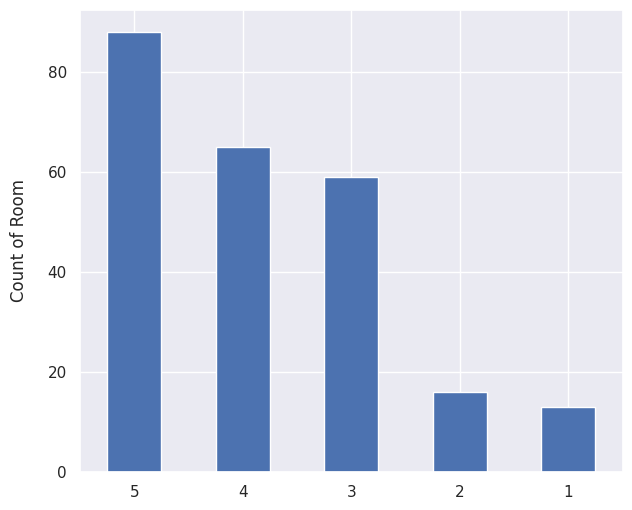

In [ ]:
# A5
sns.set(font_scale=1.0)
df2['A5'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Count of Room", labelpad=14)
exploration('A5')

# 2.3.	Detect and Remove Outlier

In [ ]:
df2

id  C1   C2                            C3                         C4  \
0    mb18   2  1.0                เทคนิคการแพทย์               กิจกรรมบำบัด   
1    mb19   2  1.0                  สื่อสารมวลชน                นิเทศศาสตร์   
2    mb20   1  1.0                    แพทยศาสตร์                 แพทยศาสตร์   
3    mb21   2  1.0                  บริหารธุรกิจ                   การบัญชี   
4    mb22   2  1.0                   เศรษฐศาสตร์                เศรษฐศาสตร์   
..    ...  ..  ...                           ...                        ...   
238  ga54   2  1.0                   ศึกษาศาสตร์                       เคมี   
239  ga55   2  1.0                   เศรษฐศาสตร์                เศรษฐศาสตร์   
240  ga56   2  1.0  รัฐศาสตร์และรัฐประศาสนศาสตร์           การระหว่างประเทศ   
241  ga57   1  1.0                   มนุษยศาสตร์  มนุษยศาสตร์และความยั่งยืน   
242  ga58   2  1.0                  สื่อสารมวลชน                        NaN   

     C5  C6  C7-1  C7-2  C8-1  ...   K1   K2   K3   K4   K5 A1  A2   A3   A4  \
0     1   1     0     1   1.0  ...  3.0  2.0  1.0  0.0  1.0  4   4  5.0  4.0   
1     1   1     1     0   1.0  ...  3.0  1.0  2.0  0.0  1.0  5   4  5.0  3.0   
2     1   0     0     0   0.0  ...  3.0  2.0  1.0  0.0  1.0  4   4  5.0  3.0   
3     2   2     0     2   2.0  ...  2.0  1.0  1.0  2.0  2.0  5   4  4.0  4.0   
4     1   1     0     1   1.0  ...  3.0  1.0  1.0  0.0  1.0  5   5  5.0  5.0   
..   ..  ..   ...   ...   ...  ...  ...  ...  ...  ...  ... ..  ..  ...  ...   
238   2   1     0     1   1.0  ...  2.0  0.0  2.0  0.0  0.0  1   4  5.0  3.0   
239   1   1     0     1   1.0  ...  1.0  2.0  1.0  0.0  0.0  5   2  5.0  5.0   
240   2   0     0     0   0.0  ...  3.0  1.0  2.0  0.0  1.0  4   5  5.0  4.0   
241   1   1     0     1   1.0  ...  3.0  2.0  2.0  2.0  2.0  3   4  5.0  4.0   
242   3   1     0     1   1.0  ...  3.0  0.0  1.0  0.0  1.0  5   4  5.0  4.0   

     A5  
0     5  
1     2  
2     4  
3     4  
4     5  
..   ..  
238   4  
239   5  
240   4  
241   5  
242   5  

[241 rows x 49 columns]

In [ ]:
display(df2[['B2','R4']].describe())

B2           R4
count  241.000000   241.000000
mean    25.148069   468.577261
std      1.052065   233.258856
min     20.000000    36.000000
25%     25.000000   300.000000
50%     25.000000   467.000000
75%     26.000000   600.000000
max     27.000000  1600.000000

**B2 : Temperature**

<Axes: >

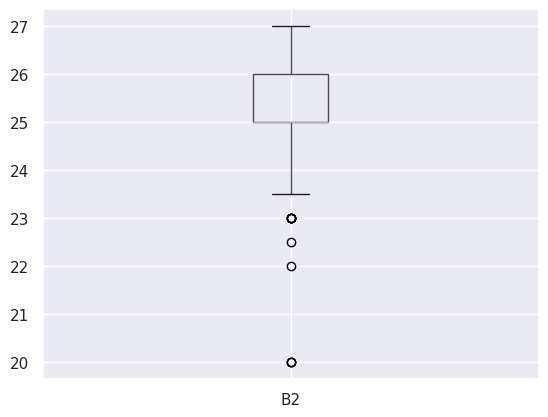

In [ ]:
b2 = pd.DataFrame(df2['B2'])
b2.boxplot()  
# Outlier 11 samples 
# Don't remove

In [ ]:
# temp of 11 samples
df2.loc[df2['B2']<=23,'B2']

29     22.5
34     23.0
36     23.0
48     20.0
49     20.0
110    23.0
111    22.0
126    20.0
163    23.0
183    23.0
197    23.0
Name: B2, dtype: float64

In [ ]:
df2 = df2.loc[df2['B2']>23]
df2

id  C1   C2                            C3                         C4  \
0    mb18   2  1.0                เทคนิคการแพทย์               กิจกรรมบำบัด   
1    mb19   2  1.0                  สื่อสารมวลชน                นิเทศศาสตร์   
2    mb20   1  1.0                    แพทยศาสตร์                 แพทยศาสตร์   
3    mb21   2  1.0                  บริหารธุรกิจ                   การบัญชี   
4    mb22   2  1.0                   เศรษฐศาสตร์                เศรษฐศาสตร์   
..    ...  ..  ...                           ...                        ...   
238  ga54   2  1.0                   ศึกษาศาสตร์                       เคมี   
239  ga55   2  1.0                   เศรษฐศาสตร์                เศรษฐศาสตร์   
240  ga56   2  1.0  รัฐศาสตร์และรัฐประศาสนศาสตร์           การระหว่างประเทศ   
241  ga57   1  1.0                   มนุษยศาสตร์  มนุษยศาสตร์และความยั่งยืน   
242  ga58   2  1.0                  สื่อสารมวลชน                        NaN   

     C5  C6  C7-1  C7-2  C8-1  ...   K1   K2   K3   K4   K5 A1  A2   A3   A4  \
0     1   1     0     1   1.0  ...  3.0  2.0  1.0  0.0  1.0  4   4  5.0  4.0   
1     1   1     1     0   1.0  ...  3.0  1.0  2.0  0.0  1.0  5   4  5.0  3.0   
2     1   0     0     0   0.0  ...  3.0  2.0  1.0  0.0  1.0  4   4  5.0  3.0   
3     2   2     0     2   2.0  ...  2.0  1.0  1.0  2.0  2.0  5   4  4.0  4.0   
4     1   1     0     1   1.0  ...  3.0  1.0  1.0  0.0  1.0  5   5  5.0  5.0   
..   ..  ..   ...   ...   ...  ...  ...  ...  ...  ...  ... ..  ..  ...  ...   
238   2   1     0     1   1.0  ...  2.0  0.0  2.0  0.0  0.0  1   4  5.0  3.0   
239   1   1     0     1   1.0  ...  1.0  2.0  1.0  0.0  0.0  5   2  5.0  5.0   
240   2   0     0     0   0.0  ...  3.0  1.0  2.0  0.0  1.0  4   5  5.0  4.0   
241   1   1     0     1   1.0  ...  3.0  2.0  2.0  2.0  2.0  3   4  5.0  4.0   
242   3   1     0     1   1.0  ...  3.0  0.0  1.0  0.0  1.0  5   4  5.0  4.0   

     A5  
0     5  
1     2  
2     4  
3     4  
4     5  
..   ..  
238   4  
239   5  
240   4  
241   5  
242   5  

[230 rows x 49 columns]

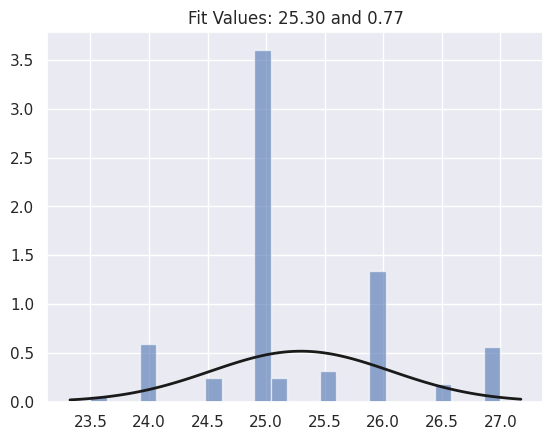

In [ ]:
data = df2['B2']
mu, std = norm.fit(data) 
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.show()

**R4 : Electricity cost (baht)**

<Axes: >

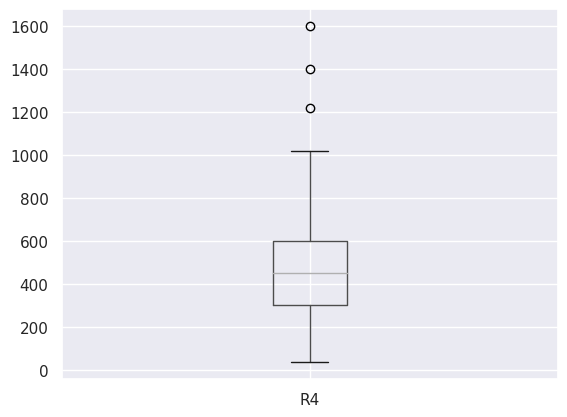

In [ ]:
r4 = pd.DataFrame(df2['R4'])
r4.boxplot()  # Outlier

In [ ]:
df2.loc[df2['R4']>=1200,'R4']

1     1400.0
47    1218.0
98    1600.0
Name: R4, dtype: float64

In [ ]:
df2 = df2.loc[df2['R4']<1200]
df2

id  C1   C2                             C3                         C4  \
0    mb18   2  1.0                 เทคนิคการแพทย์               กิจกรรมบำบัด   
2    mb20   1  1.0                     แพทยศาสตร์                 แพทยศาสตร์   
3    mb21   2  1.0                   บริหารธุรกิจ                   การบัญชี   
4    mb22   2  1.0                    เศรษฐศาสตร์                เศรษฐศาสตร์   
5    mb23   2  1.0  วิทยาลัยศิลปะสื่อและเทคโนโลยี                  แอนิเมชัน   
..    ...  ..  ...                            ...                        ...   
238  ga54   2  1.0                    ศึกษาศาสตร์                       เคมี   
239  ga55   2  1.0                    เศรษฐศาสตร์                เศรษฐศาสตร์   
240  ga56   2  1.0   รัฐศาสตร์และรัฐประศาสนศาสตร์           การระหว่างประเทศ   
241  ga57   1  1.0                    มนุษยศาสตร์  มนุษยศาสตร์และความยั่งยืน   
242  ga58   2  1.0                   สื่อสารมวลชน                        NaN   

     C5  C6  C7-1  C7-2  C8-1  ...   K1   K2   K3   K4   K5 A1  A2   A3   A4  \
0     1   1     0     1   1.0  ...  3.0  2.0  1.0  0.0  1.0  4   4  5.0  4.0   
2     1   0     0     0   0.0  ...  3.0  2.0  1.0  0.0  1.0  4   4  5.0  3.0   
3     2   2     0     2   2.0  ...  2.0  1.0  1.0  2.0  2.0  5   4  4.0  4.0   
4     1   1     0     1   1.0  ...  3.0  1.0  1.0  0.0  1.0  5   5  5.0  5.0   
5     2   1     0     1   1.0  ...  3.0  1.0  1.0  0.0  1.0  3   4  4.0  1.0   
..   ..  ..   ...   ...   ...  ...  ...  ...  ...  ...  ... ..  ..  ...  ...   
238   2   1     0     1   1.0  ...  2.0  0.0  2.0  0.0  0.0  1   4  5.0  3.0   
239   1   1     0     1   1.0  ...  1.0  2.0  1.0  0.0  0.0  5   2  5.0  5.0   
240   2   0     0     0   0.0  ...  3.0  1.0  2.0  0.0  1.0  4   5  5.0  4.0   
241   1   1     0     1   1.0  ...  3.0  2.0  2.0  2.0  2.0  3   4  5.0  4.0   
242   3   1     0     1   1.0  ...  3.0  0.0  1.0  0.0  1.0  5   4  5.0  4.0   

     A5  
0     5  
2     4  
3     4  
4     5  
5     5  
..   ..  
238   4  
239   5  
240   4  
241   5  
242   5  

[227 rows x 49 columns]

<Axes: >

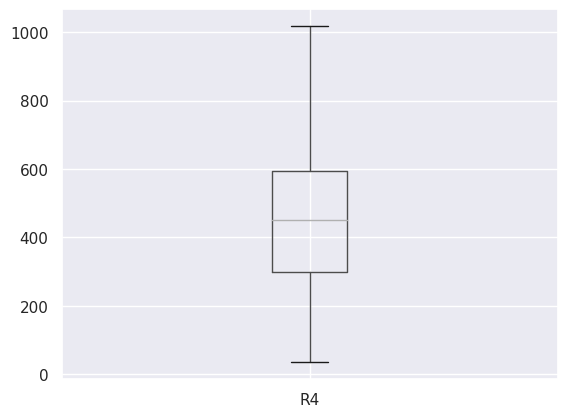

In [ ]:
r4 = pd.DataFrame(df2['R4'])
r4.boxplot()  # Outlier

In [ ]:
df2.loc[df2['R4']>=1200]

Empty DataFrame
Columns: [id, C1, C2, C3, C4, C5, C6, C7-1, C7-2, C8-1, C8-2, C8-3, C8-4, C9, C10, C11, C12, C13, C14-1, C14-2, C15-1, C15-2, C15-3, C15-4, R1, R2, R3, R4, R5, B1, B2, B3, B4, B5, B6, B7, B8, B9, B10, K1, K2, K3, K4, K5, A1, A2, A3, A4, A5]
Index: []

[0 rows x 49 columns]

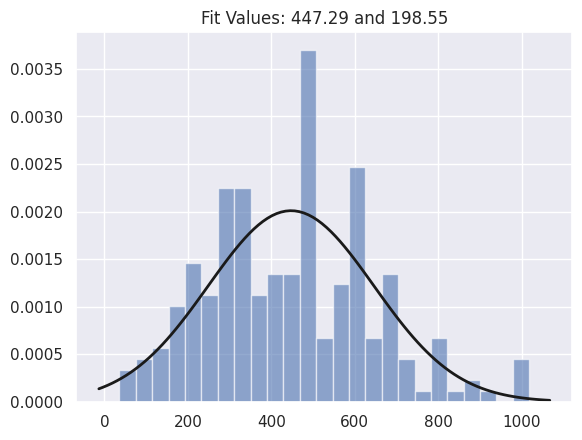

In [ ]:
data = df2['R4']
mu, std = norm.fit(data) 
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.show()

In [ ]:
# df2.to_excel('df2_rev5_qualitative.xlsx', sheet_name = 'sheet1')

# 2.4. Transform data

In [ ]:
# เนื่องจากข้อมูล Educate, Faculty, Major, Year ถูก impute missing value อีก DataFrame
# และไม่นำมาใช้ในโมเดล (แสดงเฉพาะ Descriptive)
df2 = df2.drop(columns=['id','C2','C3','C4','C5','C9','C10','C11','C12'])
df2.head()

C1  C6  C7-1  C7-2  C8-1  C8-2  C8-3  C8-4  C13  C14-1  ...   K1   K2   K3  \
0   2   1     0     1   1.0   0.0   0.0   0.0  1.0    0.0  ...  3.0  2.0  1.0   
2   1   0     0     0   0.0   0.0   0.0   0.0  0.0    0.0  ...  3.0  2.0  1.0   
3   2   2     0     2   2.0   0.0   0.0   0.0  1.0    0.0  ...  2.0  1.0  1.0   
4   2   1     0     1   1.0   0.0   0.0   0.0  0.0    0.0  ...  3.0  1.0  1.0   
5   2   1     0     1   1.0   0.0   0.0   0.0  1.0    0.0  ...  3.0  1.0  1.0   

    K4   K5  A1  A2   A3   A4  A5  
0  0.0  1.0   4   4  5.0  4.0   5  
2  0.0  1.0   4   4  5.0  3.0   4  
3  2.0  2.0   5   4  4.0  4.0   4  
4  0.0  1.0   5   5  5.0  5.0   5  
5  0.0  1.0   3   4  4.0  1.0   5  

[5 rows x 40 columns]

In [ ]:
# รวมจำนวนคอมพิวเตอร์, ประเภทคอมพิวเตอร์ และ ระบบคอมพิวเตอร์ ของสมาชิกคนที่1และ2เข้าด้วยกัน
df2['com_no'] = df2[['C6','C13']].sum(axis=1)
df2['desktop'] = df2[['C7-1','C14-1']].sum(axis=1)
df2['notebook'] = df2[['C7-2','C14-2']].sum(axis=1)
df2['window'] = df2[['C8-1','C15-1']].sum(axis=1)
df2['macos'] = df2[['C8-2','C15-2']].sum(axis=1)
df2['linux'] = df2[['C8-3','C15-3']].sum(axis=1)
df2['andriod'] = df2[['C8-4','C15-4']].sum(axis=1)
df2 = df2.drop(columns=['C6','C13','C7-1','C14-1','C7-2','C14-2','C8-1','C15-1','C8-2','C15-2','C8-3','C15-3','C8-4','C15-4'])
df2.head()

C1  R1   R2   R3      R4   R5   B1         B2   B3   B4  ...   A3   A4  A5  \
0   2   1  5.0  0.0  700.00  2.0  3.0  25.000000  4.0  1.0  ...  5.0  4.0   5   
2   1   1  2.0  0.0  378.00  2.0  3.0  25.000000  3.0  2.0  ...  5.0  3.0   4   
3   2   1  2.0  0.0  568.00  2.0  1.0  25.000000  3.0  3.0  ...  4.0  4.0   4   
4   2   1  5.0  0.0  666.00  2.0  1.0  25.000000  4.0  1.0  ...  5.0  5.0   5   
5   2   1  4.0  0.0  490.38  2.0  1.0  25.148069  5.0  1.0  ...  4.0  1.0   5   

   com_no  desktop  notebook  window  macos  linux  andriod  
0     2.0      0.0       2.0     2.0    0.0    0.0      0.0  
2     0.0      0.0       0.0     0.0    0.0    0.0      0.0  
3     3.0      0.0       3.0     3.0    0.0    0.0      0.0  
4     1.0      0.0       1.0     1.0    0.0    0.0      0.0  
5     2.0      0.0       2.0     2.0    0.0    0.0      0.0  

[5 rows x 33 columns]

In [ ]:
# ตรวจคำตอบ K2 - K5
df2['K2Point'] = np.where(df2['K2']==1, 1, 0)
df2['K3Point'] = np.where(df2['K3']==1, 1, 0)
df2['K4Point'] = np.where(df2['K4']==2, 1, 0)
df2['K5Point'] = np.where(df2['K5']==1, 1, 0)
df2 = df2.drop(columns=['K2','K3','K4','K5'])

df2['SumKnowledge'] = df2['K2Point'] + df2['K3Point'] + df2['K4Point'] + df2['K5Point']
df2 = df2.drop(columns=['K2Point','K3Point','K4Point','K5Point'])

df2.head()

C1  R1   R2   R3      R4   R5   B1         B2   B3   B4  ...   A4  A5  \
0   2   1  5.0  0.0  700.00  2.0  3.0  25.000000  4.0  1.0  ...  4.0   5   
2   1   1  2.0  0.0  378.00  2.0  3.0  25.000000  3.0  2.0  ...  3.0   4   
3   2   1  2.0  0.0  568.00  2.0  1.0  25.000000  3.0  3.0  ...  4.0   4   
4   2   1  5.0  0.0  666.00  2.0  1.0  25.000000  4.0  1.0  ...  5.0   5   
5   2   1  4.0  0.0  490.38  2.0  1.0  25.148069  5.0  1.0  ...  1.0   5   

   com_no  desktop  notebook  window  macos  linux  andriod  SumKnowledge  
0     2.0      0.0       2.0     2.0    0.0    0.0      0.0             2  
2     0.0      0.0       0.0     0.0    0.0    0.0      0.0             2  
3     3.0      0.0       3.0     3.0    0.0    0.0      0.0             3  
4     1.0      0.0       1.0     1.0    0.0    0.0      0.0             3  
5     2.0      0.0       2.0     2.0    0.0    0.0      0.0             3  

[5 rows x 30 columns]

**Set R5new**

In [ ]:
# R5 เดิม
df2['R5'].value_counts()

2.0    187
1.0     36
3.0      4
Name: R5, dtype: int64

In [ ]:
print(min(df2['R4']))
print(max(df2['R4']))

36.0
1018.0


In [ ]:
# สร้าง R5 ใหม่
conditions = [(df2['R4'] < 233),
    (df2['R4'] >= 233) & (df2['R4'] < 430),
    (df2['R4'] >= 430) & (df2['R4'] < 627),
    (df2['R4'] >= 627) & (df2['R4'] < 824),
    (df2['R4'] >= 824)]
values = [1,2,3,4,5]
# values = ['less than 233 baht', '234 - 429 baht', '430 - 626 baht', '627 - 823 baht','more than 824 baht']
df2['R5_new'] = np.select(conditions, values,42)
df2['R5_new']

0      4
2      2
3      3
4      4
5      3
      ..
238    2
239    3
240    4
241    4
242    4
Name: R5_new, Length: 227, dtype: int64

In [ ]:
df2['R5_new'].value_counts()

3    84
2    72
1    34
4    29
5     8
Name: R5_new, dtype: int64

In [ ]:
# df2.to_excel('df2_rev5.xlsx', sheet_name = 'sheet1')

# 2.5. Normal Distribution test

In [ ]:
des_feature = df2.drop(columns=['R4','R5','R5_new'])
des_feature.describe().transpose()

count       mean       std   min   25%   50%   75%   max
C1            227.0   1.819383  0.385550   1.0   2.0   2.0   2.0   2.0
R1            227.0   0.480176  0.500711   0.0   0.0   0.0   1.0   1.0
R2            227.0   3.105727  1.355850   1.0   2.0   3.0   4.0   5.0
R3            227.0   0.123348  0.329563   0.0   0.0   0.0   0.0   1.0
B1            227.0   2.145374  1.109498   1.0   1.0   2.0   3.0   4.0
B2            227.0  25.300372  0.776293  23.5  25.0  25.0  26.0  27.0
B3            227.0   3.590308  1.476810   1.0   2.0   4.0   5.0   5.0
B4            227.0   1.612335  0.999747   1.0   1.0   1.0   2.0   5.0
B5            227.0   1.370044  0.923911   1.0   1.0   1.0   1.0   5.0
B6            227.0   1.709251  1.146002   1.0   1.0   1.0   2.0   5.0
B7            227.0   2.295154  1.028842   1.0   1.0   2.0   3.0   4.0
B8            227.0   1.907489  1.028482   1.0   1.0   2.0   3.0   4.0
B9            227.0   2.845815  1.536580   1.0   1.0   3.0   4.0   5.0
B10           227.0   4.017621  1.159664   1.0   3.0   4.0   5.0   5.0
K1            227.0   2.916300  0.592765   1.0   3.0   3.0   3.0   5.0
A1            227.0   4.140969  0.733186   1.0   4.0   4.0   5.0   5.0
A2            227.0   3.986784  0.984302   1.0   3.0   4.0   5.0   5.0
A3            227.0   4.462555  0.753845   1.0   4.0   5.0   5.0   5.0
A4            227.0   3.211454  1.055643   1.0   3.0   3.0   4.0   5.0
A5            227.0   3.828194  1.145015   1.0   3.0   4.0   5.0   5.0
com_no        227.0   1.735683  0.825857   0.0   1.0   2.0   2.0   6.0
desktop       227.0   0.136564  0.414166   0.0   0.0   0.0   0.0   2.0
notebook      227.0   1.599119  0.765749   0.0   1.0   2.0   2.0   4.0
window        227.0   1.506608  0.766385   0.0   1.0   2.0   2.0   4.0
macos         227.0   0.207048  0.476291   0.0   0.0   0.0   0.0   3.0
linux         227.0   0.004405  0.066372   0.0   0.0   0.0   0.0   1.0
andriod       227.0   0.017621  0.209609   0.0   0.0   0.0   0.0   3.0
SumKnowledge  227.0   2.202643  0.777671   0.0   2.0   2.0   3.0   4.0

In [ ]:
from scipy.stats import kstest
from scipy.stats import binom

#perform Kolmogorov-Smirnov test
kstest(des_feature['A1'], 'norm')

KstestResult(statistic=0.9898395292811453, pvalue=0.0, statistic_location=3, statistic_sign=-1)

In [ ]:
statistic = []
pvalue = []
norm = []
column = []
for i in range(len(des_feature.columns)):
  cname = des_feature.columns[i]
  column.append(cname)
  s = kstest(des_feature.iloc[:,i], 'norm')[0]
  statistic.append(s)
  p = kstest(des_feature.iloc[:,i], 'norm')[1]
  pvalue.append(p)
  if p<0.05 : norm.append('Reject H0: The sample data come from a normal distribution.')
  else: norm.append(' ')

ks_df = pd.DataFrame({'Feature' : column,
                      'Statistic' : statistic,
                      'P-value' : pvalue,
                      'Significant' : norm})
ks_df

Feature  Statistic        P-value  \
0             C1   0.841345  4.118428e-181   
1             R1   0.500000   5.305598e-53   
2             R2   0.841345  4.118428e-181   
3             R3   0.500000   5.305598e-53   
4             B1   0.841345  4.118428e-181   
5             B2   1.000000   0.000000e+00   
6             B3   0.841345  4.118428e-181   
7             B4   0.841345  4.118428e-181   
8             B5   0.841345  4.118428e-181   
9             B6   0.841345  4.118428e-181   
10            B7   0.841345  4.118428e-181   
11            B8   0.841345  4.118428e-181   
12            B9   0.841345  4.118428e-181   
13           B10   0.937602  6.373952e-274   
14            K1   0.968439   0.000000e+00   
15            A1   0.989840   0.000000e+00   
16            A2   0.955223  1.229003e-306   
17            A3   0.994245   0.000000e+00   
18            A4   0.906765  2.582601e-234   
19            A5   0.924386  5.555389e-255   
20        com_no   0.779671  1.788611e-146   
21       desktop   0.500000   5.305598e-53   
22      notebook   0.757644  4.943209e-136   
23        window   0.740023  3.170941e-128   
24         macos   0.500000   5.305598e-53   
25         linux   0.500000   5.305598e-53   
26       andriod   0.500000   5.305598e-53   
27  SumKnowledge   0.819318  1.237658e-167   

                                          Significant  
0   Reject H0: The sample data come from a normal ...  
1   Reject H0: The sample data come from a normal ...  
2   Reject H0: The sample data come from a normal ...  
3   Reject H0: The sample data come from a normal ...  
4   Reject H0: The sample data come from a normal ...  
5   Reject H0: The sample data come from a normal ...  
6   Reject H0: The sample data come from a normal ...  
7   Reject H0: The sample data come from a normal ...  
8   Reject H0: The sample data come from a normal ...  
9   Reject H0: The sample data come from a normal ...  
10  Reject H0: The sample data come from a normal ...  
11  Reject H0: The sample data come from a normal ...  
12  Reject H0: The sample data come from a normal ...  
13  Reject H0: The sample data come from a normal ...  
14  Reject H0: The sample data come from a normal ...  
15  Reject H0: The sample data come from a normal ...  
16  Reject H0: The sample data come from a normal ...  
17  Reject H0: The sample data come from a normal ...  
18  Reject H0: The sample data come from a normal ...  
19  Reject H0: The sample data come from a normal ...  
20  Reject H0: The sample data come from a normal ...  
21  Reject H0: The sample data come from a normal ...  
22  Reject H0: The sample data come from a normal ...  
23  Reject H0: The sample data come from a normal ...  
24  Reject H0: The sample data come from a normal ...  
25  Reject H0: The sample data come from a normal ...  
26  Reject H0: The sample data come from a normal ...  
27  Reject H0: The sample data come from a normal ...

In [ ]:
import scipy.stats as sc
sample_size = len(des_feature['A1'])
skewed_norm = sc.skewnorm.rvs(a=5, size=sample_size)
skew_left_norm = sc.skewnorm.rvs(a=-5, size=sample_size)

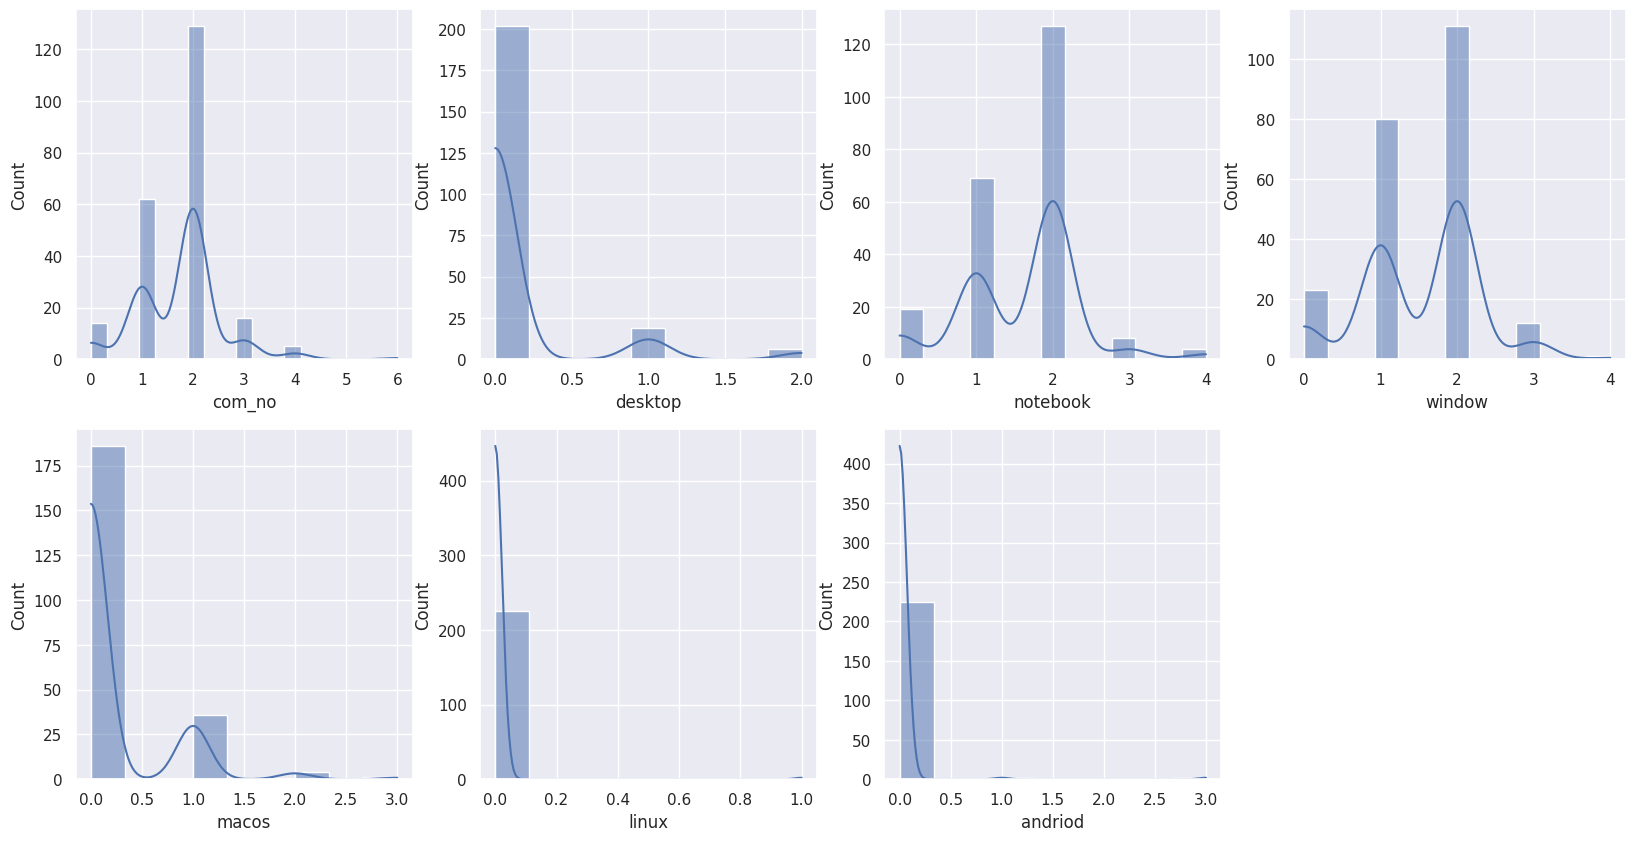

In [ ]:
plt.subplots(2,4, figsize=(20,10))

plt.subplot(2,4,1)
sns.histplot(data=des_feature, x="com_no", kde=True)

plt.subplot(2,4,2)
sns.histplot(data=des_feature, x="desktop", kde=True)

plt.subplot(2,4,3)
sns.histplot(data=des_feature, x="notebook", kde=True)

plt.subplot(2,4,4)
sns.histplot(data=des_feature, x="window", kde=True)

plt.subplot(2,4,5)
sns.histplot(data=des_feature, x="macos", kde=True)

plt.subplot(2,4,6)
sns.histplot(data=des_feature, x="linux", kde=True)

plt.subplot(2,4,7)
sns.histplot(data=des_feature, x="andriod", kde=True)

plt.subplot(2,4,8).set_axis_off()


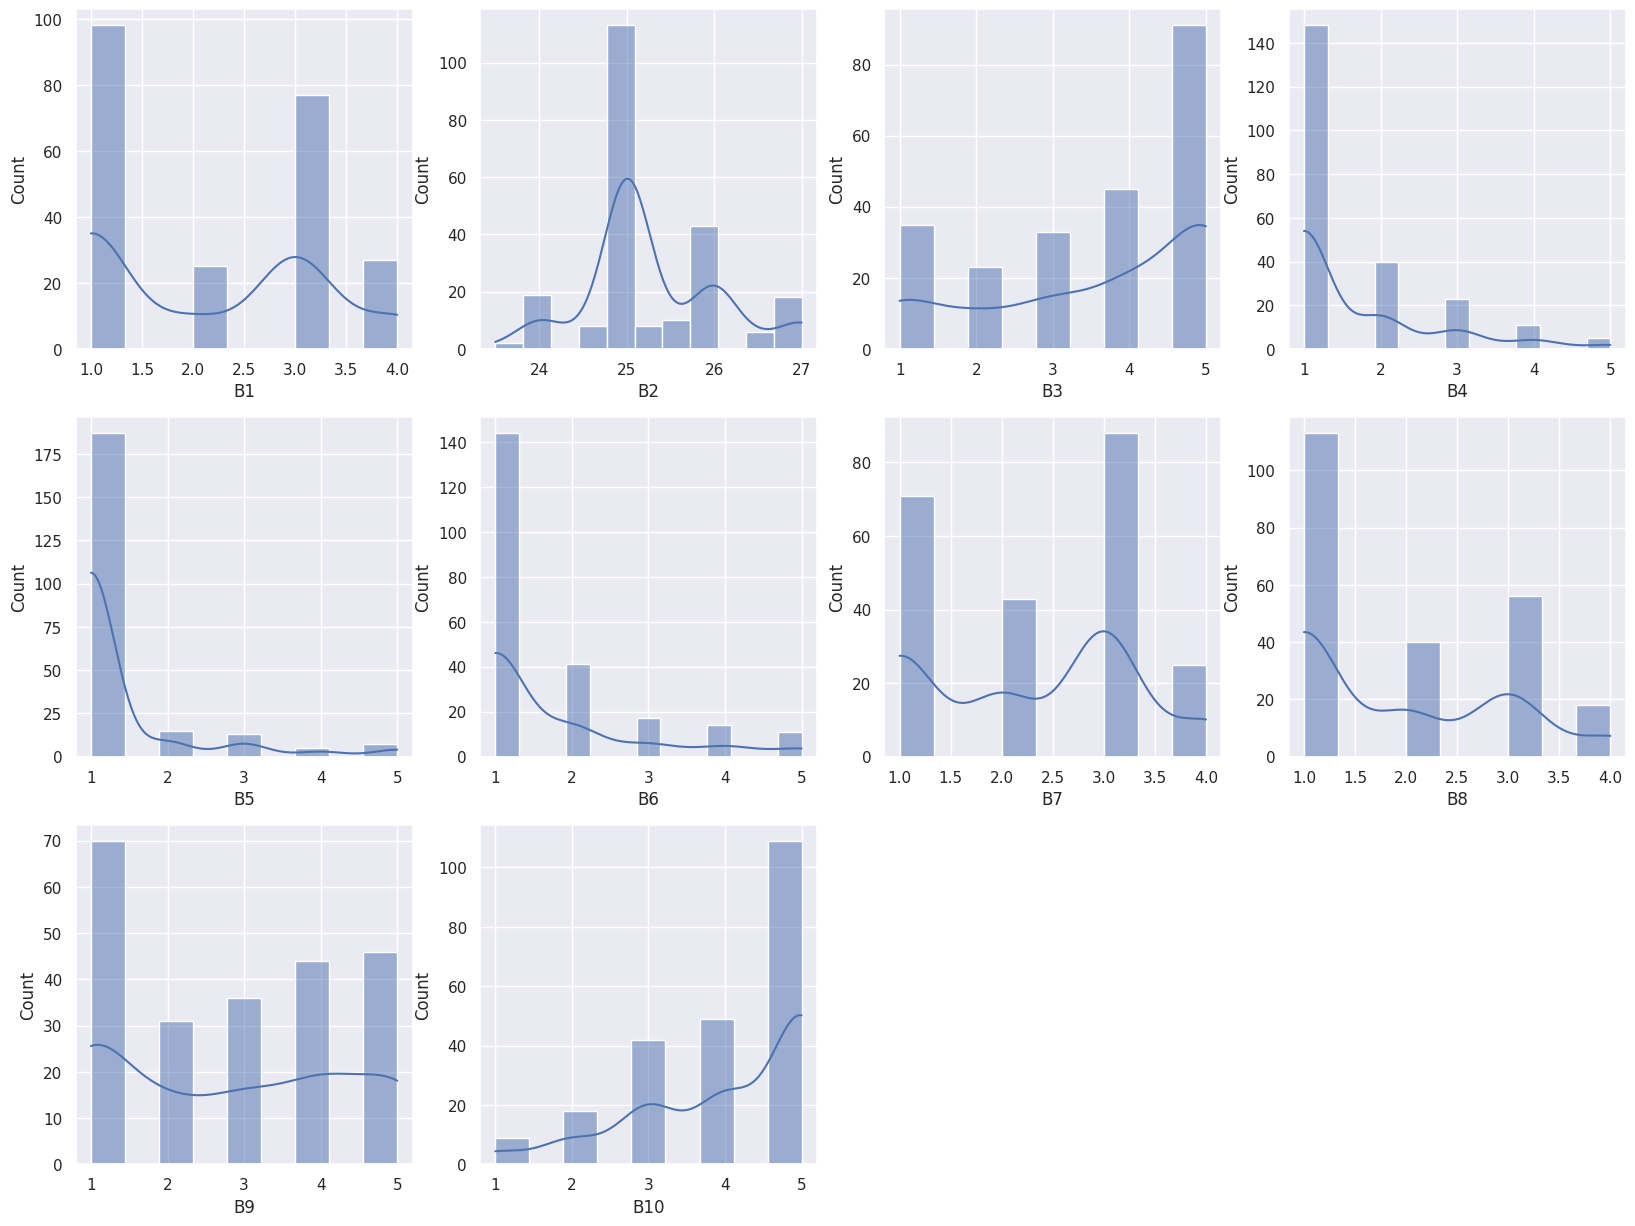

In [ ]:
plt.subplots(3,4, figsize=(20,15))

plt.subplot(3,4,1)
sns.histplot(data=des_feature, x="B1", kde=True)

plt.subplot(3,4,2)
sns.histplot(data=des_feature, x="B2", kde=True)

plt.subplot(3,4,3)
sns.histplot(data=des_feature, x="B3", kde=True)

plt.subplot(3,4,4)
sns.histplot(data=des_feature, x="B4", kde=True)

plt.subplot(3,4,5)
sns.histplot(data=des_feature, x="B5", kde=True)

plt.subplot(3,4,6)
sns.histplot(data=des_feature, x="B6", kde=True)

plt.subplot(3,4,7)
sns.histplot(data=des_feature, x="B7", kde=True)

plt.subplot(3,4,8)
sns.histplot(data=des_feature, x="B8", kde=True)

plt.subplot(3,4,9)
sns.histplot(data=des_feature, x="B9", kde=True)

plt.subplot(3,4,10)
sns.histplot(data=des_feature, x="B10", kde=True)

plt.subplot(3,4,11).set_axis_off()
plt.subplot(3,4,12).set_axis_off()


<Axes: xlabel='SumKnowledge', ylabel='Count'>

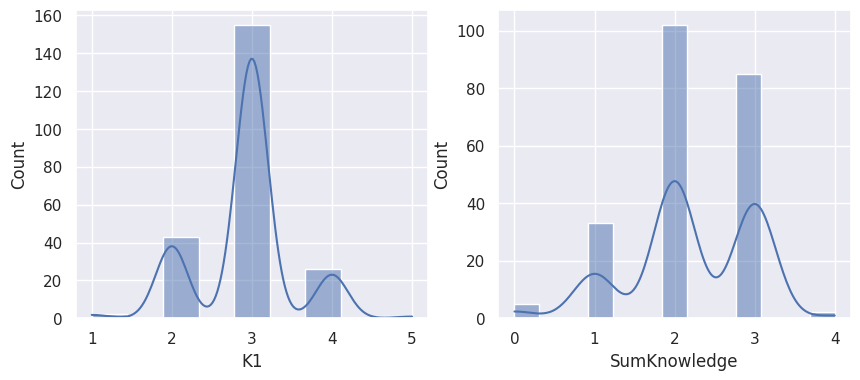

In [ ]:
plt.subplots(1,2, figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(data=des_feature, x="K1", kde=True)

plt.subplot(1,2,2)
sns.histplot(data=des_feature, x="SumKnowledge", kde=True)

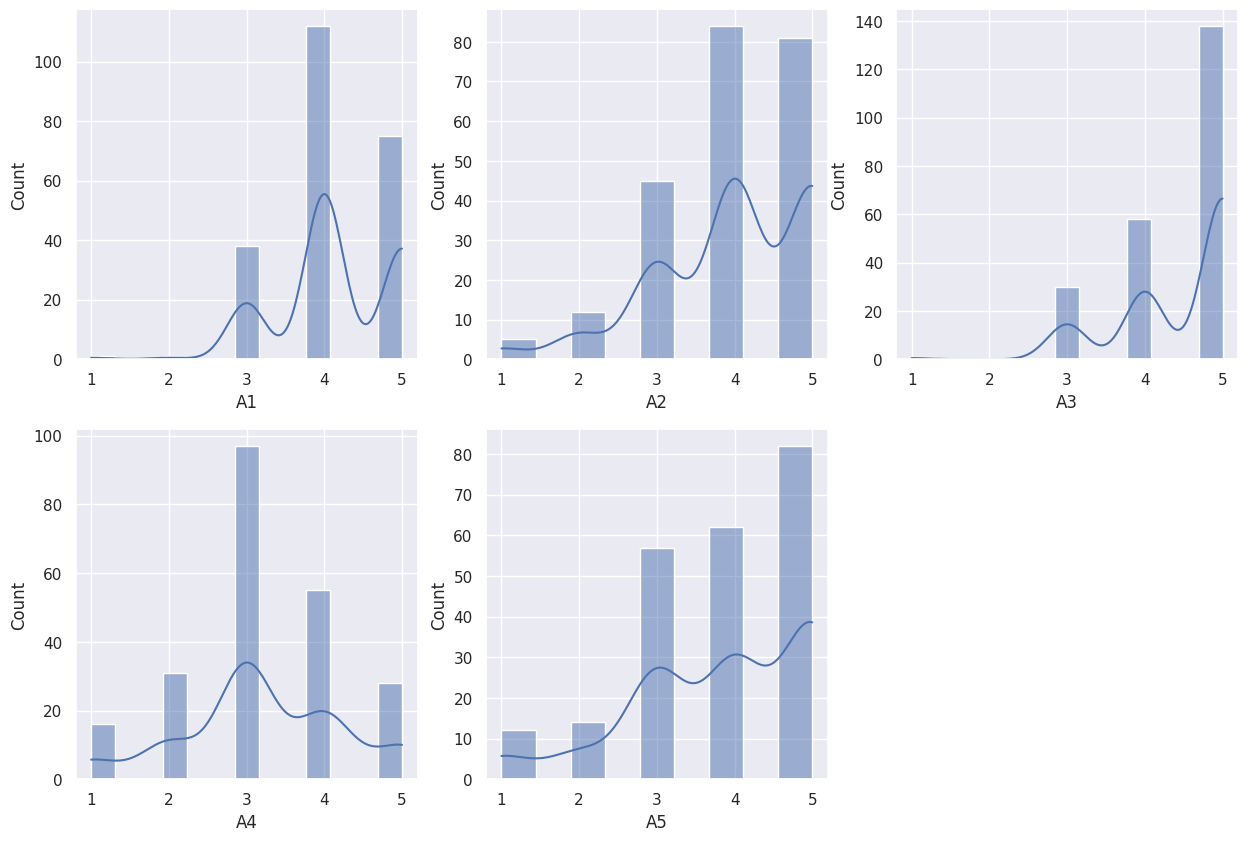

In [ ]:
plt.subplots(2,3, figsize=(15,10))

plt.subplot(2,3,1)
sns.histplot(data=des_feature, x="A1", kde=True)

plt.subplot(2,3,2)
sns.histplot(data=des_feature, x="A2", kde=True)

plt.subplot(2,3,3)
sns.histplot(data=des_feature, x="A3", kde=True)

plt.subplot(2,3,4)
sns.histplot(data=des_feature, x="A4", kde=True)

plt.subplot(2,3,5)
sns.histplot(data=des_feature, x="A5", kde=True)

plt.subplot(2,3,6).set_axis_off()

In [ ]:
#perform Kolmogorov-Smirnov test
kstest(df2['R4'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=36.0, statistic_sign=-1)

In [ ]:
df2['R4'].describe()

count     227.000000
mean      447.293480
std       198.989483
min        36.000000
25%       300.000000
50%       450.000000
75%       593.500000
max      1018.000000
Name: R4, dtype: float64

<Axes: xlabel='R4', ylabel='Count'>

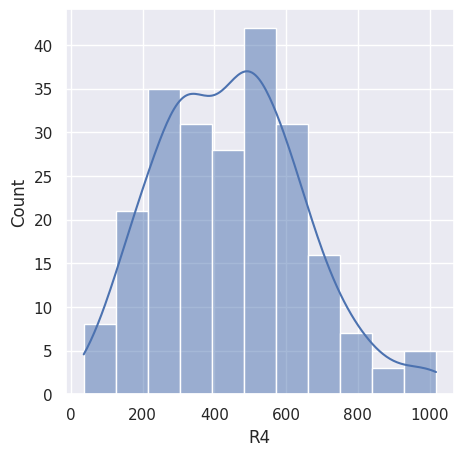

In [ ]:
plt.subplots(1,1, figsize=(5,5))
plt.subplot(1,1,1)
sns.histplot(data=df2, x="R4", kde=True)

# **3. Data Preprocessing**

# 3.1. MinMaxScaler and One hot encoding

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaled_features = StandardScaler().fit_transform(df2[['R4','B2']])
# df2[['R4','B2']] = scaled_features
# display(df2.head())

In [ ]:
df2

C1  R1   R2   R3      R4   R5   B1         B2   B3   B4  ...  A5  com_no  \
0     2   1  5.0  0.0  700.00  2.0  3.0  25.000000  4.0  1.0  ...   5     2.0   
2     1   1  2.0  0.0  378.00  2.0  3.0  25.000000  3.0  2.0  ...   4     0.0   
3     2   1  2.0  0.0  568.00  2.0  1.0  25.000000  3.0  3.0  ...   4     3.0   
4     2   1  5.0  0.0  666.00  2.0  1.0  25.000000  4.0  1.0  ...   5     1.0   
5     2   1  4.0  0.0  490.38  2.0  1.0  25.148069  5.0  1.0  ...   5     2.0   
..   ..  ..  ...  ...     ...  ...  ...        ...  ...  ...  ...  ..     ...   
238   2   0  1.0  0.0  342.00  2.0  3.0  25.000000  1.0  2.0  ...   4     1.0   
239   2   0  2.0  1.0  594.00  2.0  2.0  26.500000  5.0  1.0  ...   5     2.0   
240   2   0  3.0  1.0  800.00  2.0  3.0  25.000000  4.0  4.0  ...   4     0.0   
241   1   0  1.0  0.0  800.00  2.0  3.0  24.000000  2.0  2.0  ...   5     1.0   
242   2   0  3.0  1.0  732.00  2.0  3.0  25.000000  4.0  1.0  ...   5     2.0   

     desktop  notebook  window  macos  linux  andriod  SumKnowledge  R5_new  
0        0.0       2.0     2.0    0.0    0.0      0.0             2       4  
2        0.0       0.0     0.0    0.0    0.0      0.0             2       2  
3        0.0       3.0     3.0    0.0    0.0      0.0             3       3  
4        0.0       1.0     1.0    0.0    0.0      0.0             3       4  
5        0.0       2.0     2.0    0.0    0.0      0.0             3       3  
..       ...       ...     ...    ...    ...      ...           ...     ...  
238      0.0       1.0     1.0    0.0    0.0      0.0             0       2  
239      0.0       2.0     1.0    1.0    0.0      0.0             1       3  
240      0.0       0.0     0.0    0.0    0.0      0.0             2       4  
241      0.0       1.0     1.0    0.0    0.0      0.0             1       4  
242      0.0       2.0     2.0    0.0    0.0      0.0             2       4  

[227 rows x 31 columns]

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 242
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   C1            227 non-null    int64  
 1   R1            227 non-null    int64  
 2   R2            227 non-null    float64
 3   R3            227 non-null    float64
 4   R4            227 non-null    float64
 5   R5            227 non-null    float64
 6   B1            227 non-null    float64
 7   B2            227 non-null    float64
 8   B3            227 non-null    float64
 9   B4            227 non-null    float64
 10  B5            227 non-null    float64
 11  B6            227 non-null    float64
 12  B7            227 non-null    float64
 13  B8            227 non-null    float64
 14  B9            227 non-null    int64  
 15  B10           227 non-null    int64  
 16  K1            227 non-null    float64
 17  A1            227 non-null    int64  
 18  A2            227 non-null    

In [ ]:
df2 = df2.astype({"C1":"int",
           "R1":"int",
           "R2":"int",
           "R3":"int",
           "R4":"float64",
           "R5":"int",
           "B1":"float64",
           "B2":"float64",
           "B3":"float64",
           "B4":"float64",
           "B5":"float64",
           "B6":"float64",
           "B7":"float64",
           "B8":"float64",
           "B9":"float64",
           "B10":"float64",
           "K1":"float64",
           "A1":"float64",
           "A2":"float64",
           "A3":"float64",
           "A4":"float64",
           "A5":"float64",
           "com_no":"float64",
           "desktop":"float64",
           "notebook":"float64",
           "window":"float64",
           "macos":"float64",
           "linux":"float64",
           "andriod":"float64",
           "SumKnowledge":"float64",
           "R5_new":"int"})
df2

C1  R1  R2  R3      R4  R5   B1         B2   B3   B4  ...   A5  com_no  \
0     2   1   5   0  700.00   2  3.0  25.000000  4.0  1.0  ...  5.0     2.0   
2     1   1   2   0  378.00   2  3.0  25.000000  3.0  2.0  ...  4.0     0.0   
3     2   1   2   0  568.00   2  1.0  25.000000  3.0  3.0  ...  4.0     3.0   
4     2   1   5   0  666.00   2  1.0  25.000000  4.0  1.0  ...  5.0     1.0   
5     2   1   4   0  490.38   2  1.0  25.148069  5.0  1.0  ...  5.0     2.0   
..   ..  ..  ..  ..     ...  ..  ...        ...  ...  ...  ...  ...     ...   
238   2   0   1   0  342.00   2  3.0  25.000000  1.0  2.0  ...  4.0     1.0   
239   2   0   2   1  594.00   2  2.0  26.500000  5.0  1.0  ...  5.0     2.0   
240   2   0   3   1  800.00   2  3.0  25.000000  4.0  4.0  ...  4.0     0.0   
241   1   0   1   0  800.00   2  3.0  24.000000  2.0  2.0  ...  5.0     1.0   
242   2   0   3   1  732.00   2  3.0  25.000000  4.0  1.0  ...  5.0     2.0   

     desktop  notebook  window  macos  linux  andriod  SumKnowledge  R5_new  
0        0.0       2.0     2.0    0.0    0.0      0.0           2.0       4  
2        0.0       0.0     0.0    0.0    0.0      0.0           2.0       2  
3        0.0       3.0     3.0    0.0    0.0      0.0           3.0       3  
4        0.0       1.0     1.0    0.0    0.0      0.0           3.0       4  
5        0.0       2.0     2.0    0.0    0.0      0.0           3.0       3  
..       ...       ...     ...    ...    ...      ...           ...     ...  
238      0.0       1.0     1.0    0.0    0.0      0.0           0.0       2  
239      0.0       2.0     1.0    1.0    0.0      0.0           1.0       3  
240      0.0       0.0     0.0    0.0    0.0      0.0           2.0       4  
241      0.0       1.0     1.0    0.0    0.0      0.0           1.0       4  
242      0.0       2.0     2.0    0.0    0.0      0.0           2.0       4  

[227 rows x 31 columns]

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 242
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   C1            227 non-null    int64  
 1   R1            227 non-null    int64  
 2   R2            227 non-null    int64  
 3   R3            227 non-null    int64  
 4   R4            227 non-null    float64
 5   R5            227 non-null    int64  
 6   B1            227 non-null    float64
 7   B2            227 non-null    float64
 8   B3            227 non-null    float64
 9   B4            227 non-null    float64
 10  B5            227 non-null    float64
 11  B6            227 non-null    float64
 12  B7            227 non-null    float64
 13  B8            227 non-null    float64
 14  B9            227 non-null    float64
 15  B10           227 non-null    float64
 16  K1            227 non-null    float64
 17  A1            227 non-null    float64
 18  A2            227 non-null    

**Set Feature, Label**

In [ ]:
# Set feature, label
feature = df2.drop(columns=['R4','R5','R5_new'])
labelR4 = df2['R4']
labelR5 = df2['R5']
labelR5new = df2['R5_new']

print(df2.shape)
print(feature.shape)
print(labelR4.shape)
print(labelR5.shape)
print(labelR5new.shape)

(227, 31)
(227, 28)
(227,)
(227,)
(227,)


In [ ]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 242
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   C1            227 non-null    int64  
 1   R1            227 non-null    int64  
 2   R2            227 non-null    int64  
 3   R3            227 non-null    int64  
 4   B1            227 non-null    float64
 5   B2            227 non-null    float64
 6   B3            227 non-null    float64
 7   B4            227 non-null    float64
 8   B5            227 non-null    float64
 9   B6            227 non-null    float64
 10  B7            227 non-null    float64
 11  B8            227 non-null    float64
 12  B9            227 non-null    float64
 13  B10           227 non-null    float64
 14  K1            227 non-null    float64
 15  A1            227 non-null    float64
 16  A2            227 non-null    float64
 17  A3            227 non-null    float64
 18  A4            227 non-null    

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


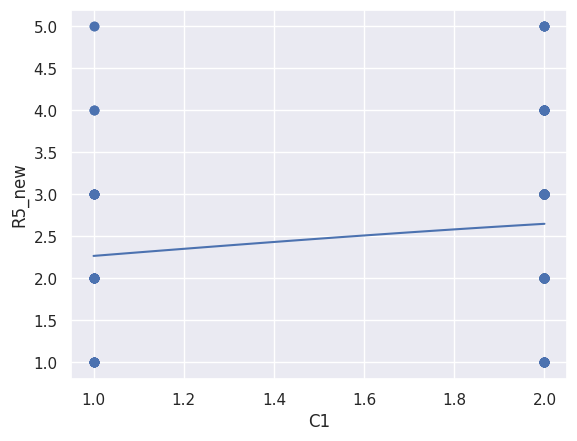

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


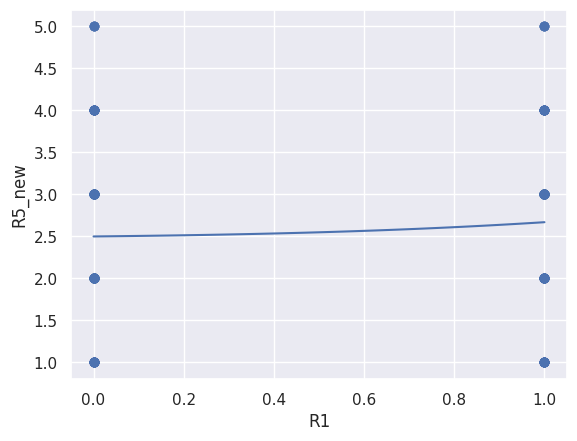

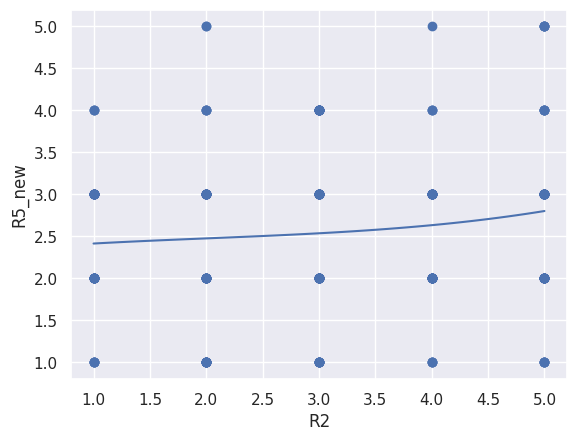

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


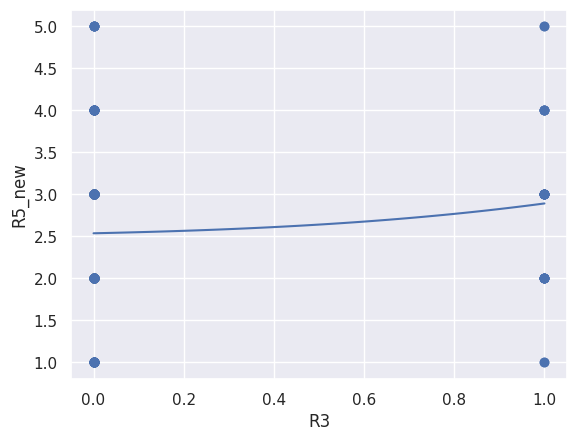

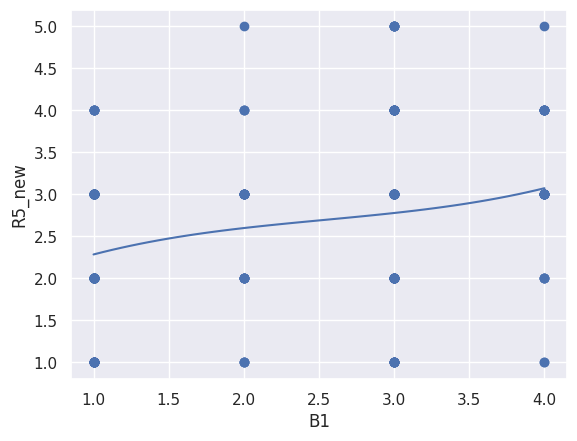

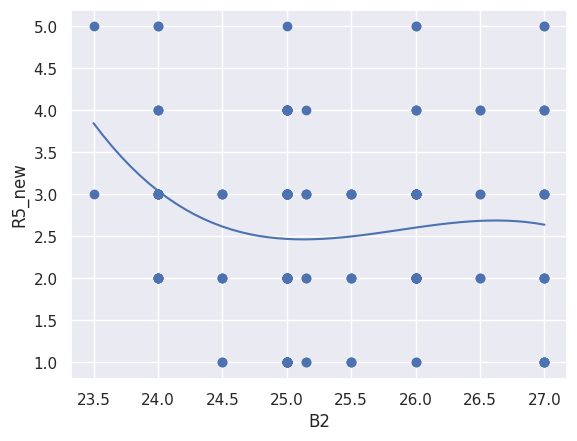

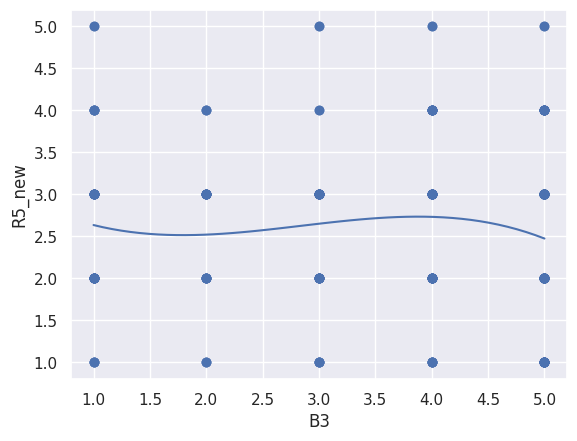

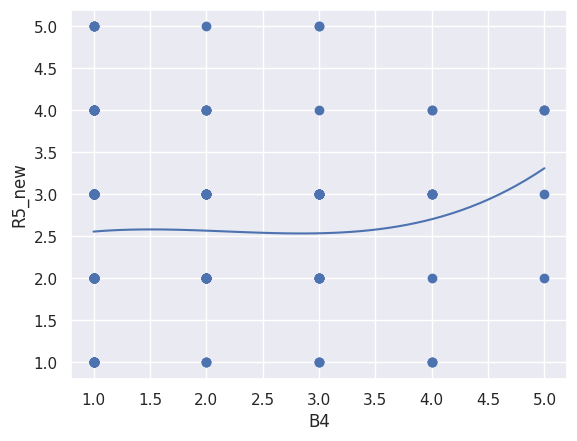

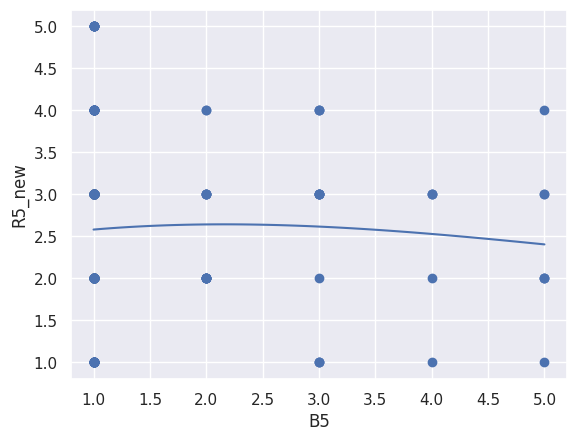

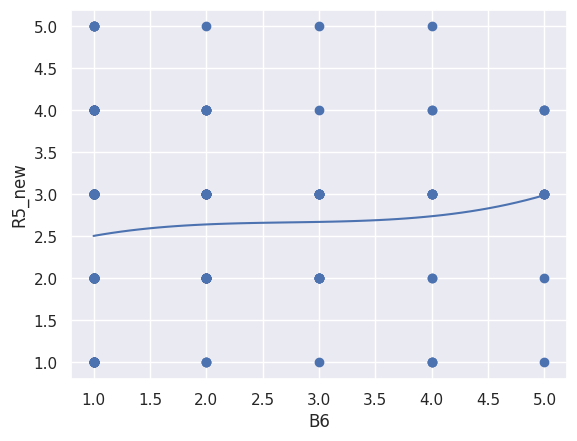

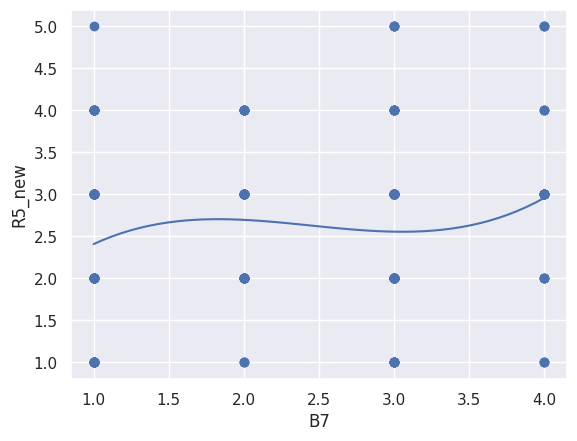

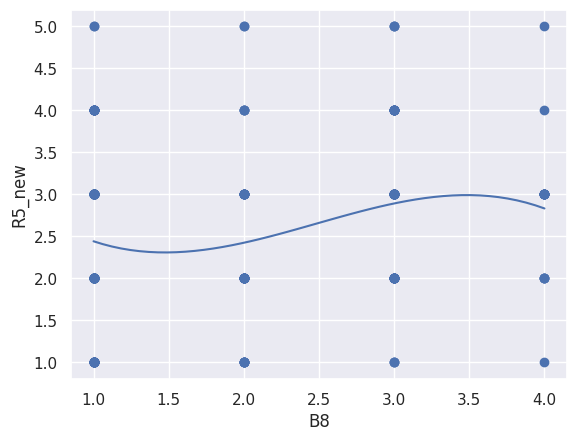

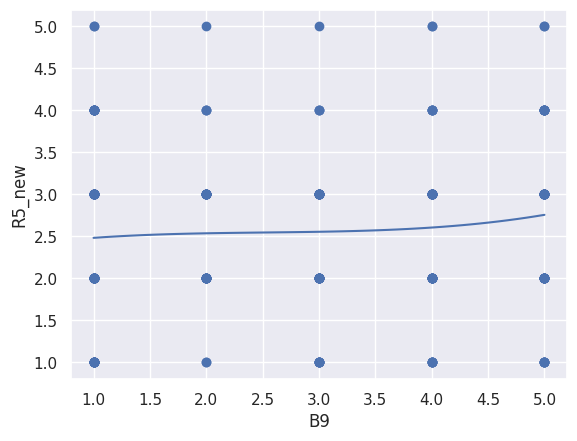

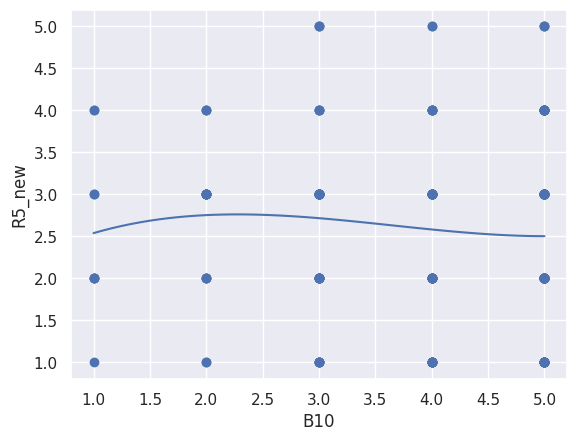

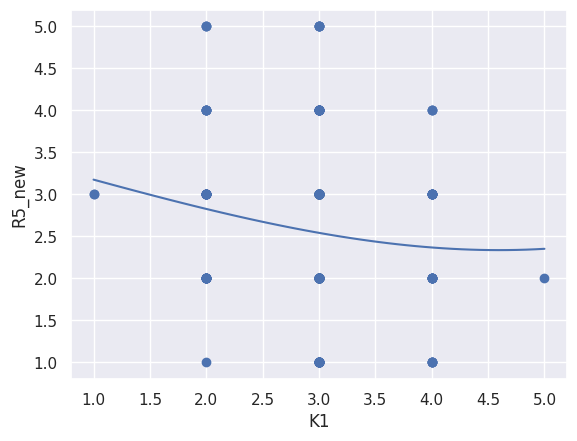

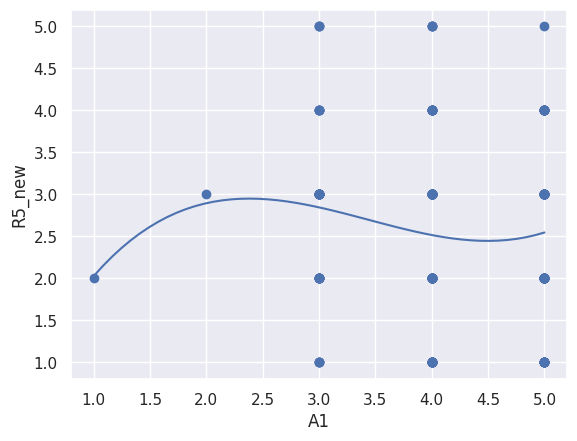

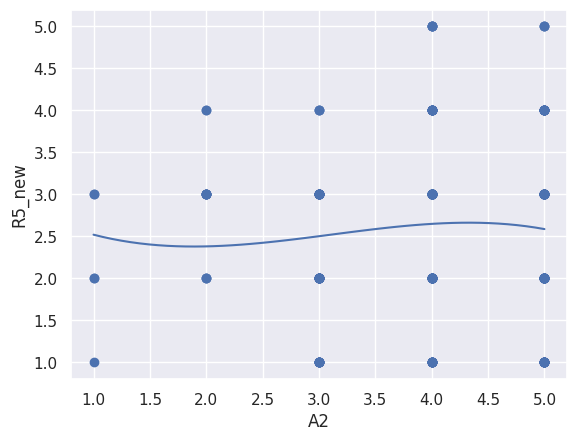

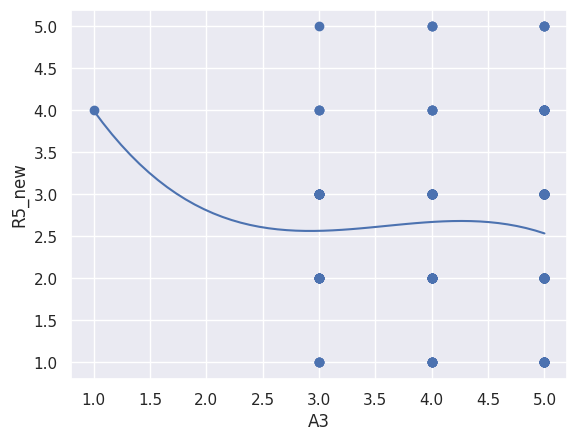

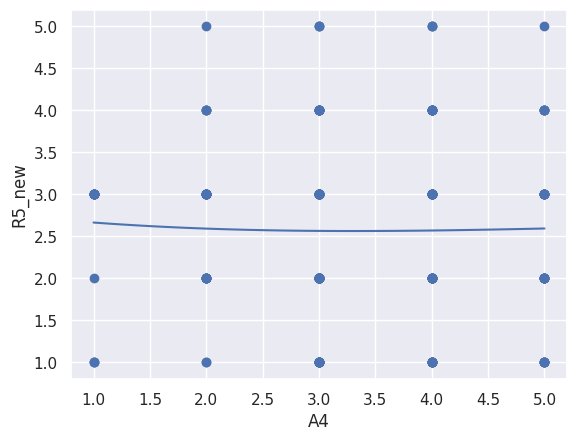

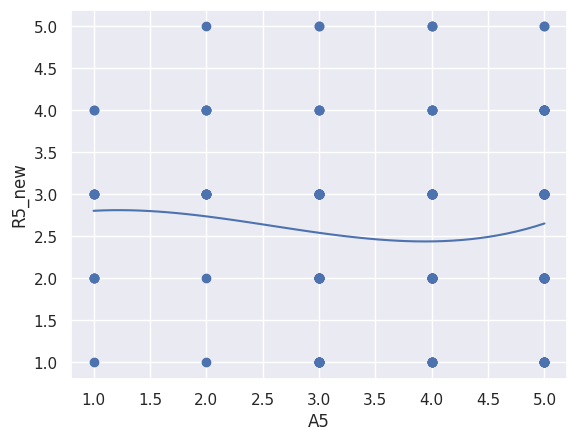

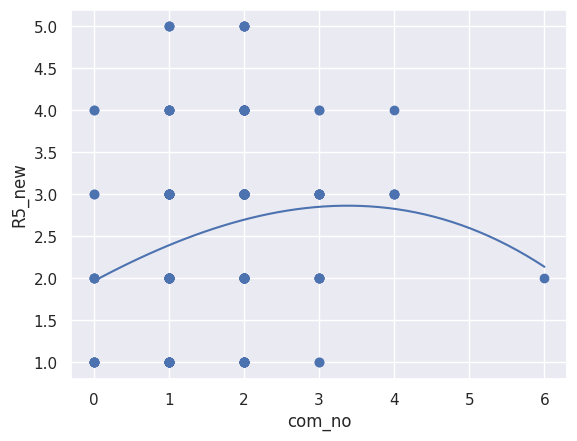

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


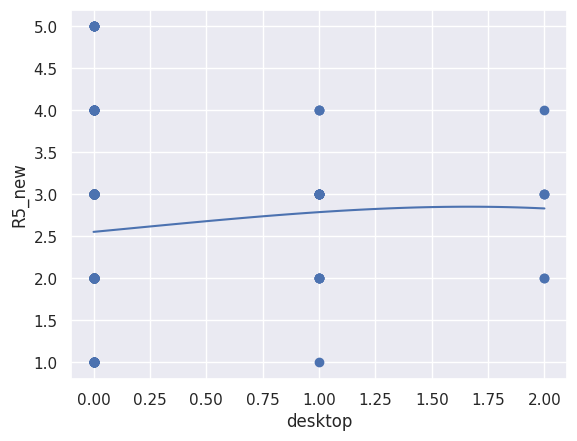

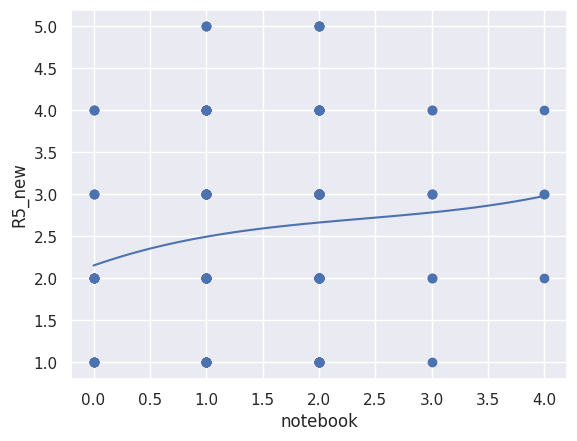

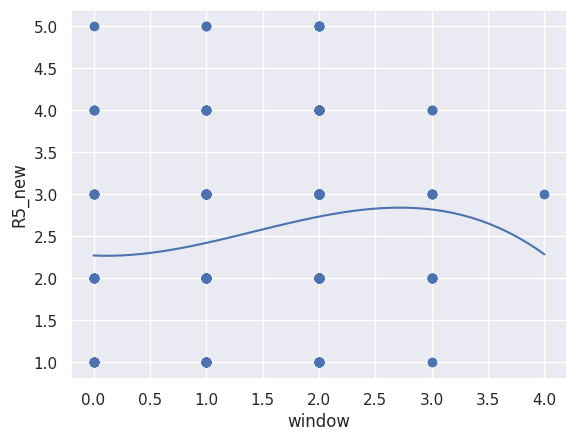

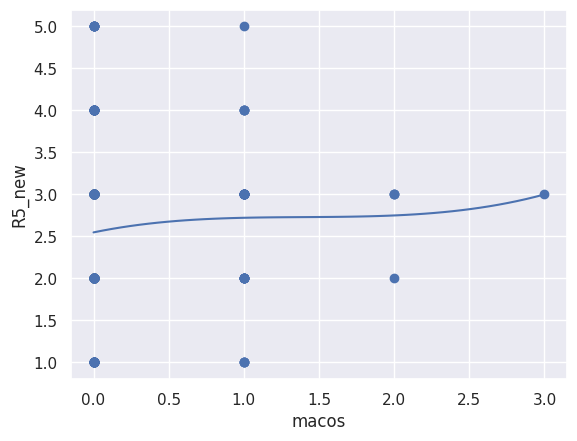

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


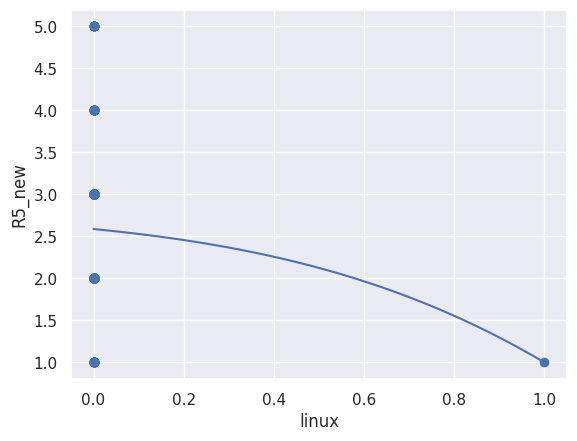

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


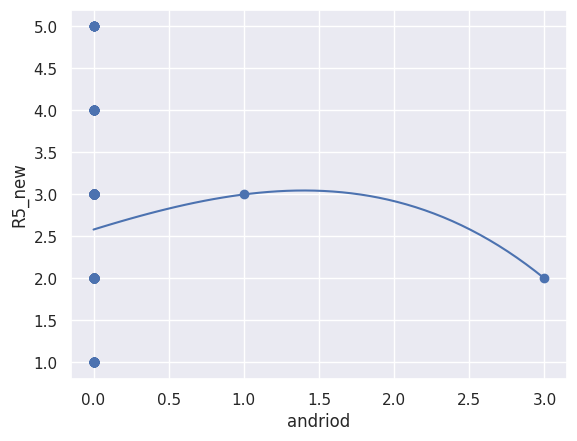

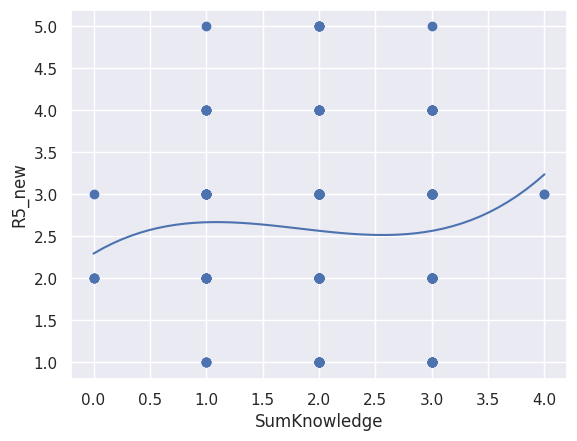

In [ ]:
# ดูความสัมพันธ์ระหว่าง feature กับ target ก่อนที่จะทำ Normalization กับ One hot encoding

for i in range(len(feature.columns)):
    x = feature.iloc[:,i]
    y = labelR5new
    mymodel = np.poly1d(np.polyfit(x, y, 3))
    myline = np.linspace(min(x),max(x))
    plt.scatter(x, y)
    # plt.title('Relationship between \n {} and {}'.format(x.name,y.name))
    plt.plot(myline, mymodel(myline))
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()

**Min-Max Scaler**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
feature_float = feature.select_dtypes(include=['float64'])
scaled_feature_float = MinMaxScaler().fit_transform(feature_float)
feature[feature_float.columns] = scaled_feature_float
display(feature)

C1  R1  R2  R3        B1        B2    B3    B4   B5    B6  ...    A4  \
0     2   1   5   0  0.666667  0.428571  0.75  0.00  0.0  0.00  ...  0.75   
2     1   1   2   0  0.666667  0.428571  0.50  0.25  0.0  0.75  ...  0.50   
3     2   1   2   0  0.000000  0.428571  0.50  0.50  0.5  0.50  ...  0.75   
4     2   1   5   0  0.000000  0.428571  0.75  0.00  0.0  0.25  ...  1.00   
5     2   1   4   0  0.000000  0.470877  1.00  0.00  0.0  0.00  ...  0.00   
..   ..  ..  ..  ..       ...       ...   ...   ...  ...   ...  ...   ...   
238   2   0   1   0  0.666667  0.428571  0.00  0.25  0.0  0.50  ...  0.50   
239   2   0   2   1  0.333333  0.857143  1.00  0.00  0.0  0.25  ...  1.00   
240   2   0   3   1  0.666667  0.428571  0.75  0.75  0.5  0.25  ...  0.75   
241   1   0   1   0  0.666667  0.142857  0.25  0.25  0.0  0.75  ...  0.75   
242   2   0   3   1  0.666667  0.428571  0.75  0.00  0.0  0.25  ...  0.75   

       A5    com_no  desktop  notebook  window     macos  linux  andriod  \
0    1.00  0.333333      0.0      0.50    0.50  0.000000    0.0      0.0   
2    0.75  0.000000      0.0      0.00    0.00  0.000000    0.0      0.0   
3    0.75  0.500000      0.0      0.75    0.75  0.000000    0.0      0.0   
4    1.00  0.166667      0.0      0.25    0.25  0.000000    0.0      0.0   
5    1.00  0.333333      0.0      0.50    0.50  0.000000    0.0      0.0   
..    ...       ...      ...       ...     ...       ...    ...      ...   
238  0.75  0.166667      0.0      0.25    0.25  0.000000    0.0      0.0   
239  1.00  0.333333      0.0      0.50    0.25  0.333333    0.0      0.0   
240  0.75  0.000000      0.0      0.00    0.00  0.000000    0.0      0.0   
241  1.00  0.166667      0.0      0.25    0.25  0.000000    0.0      0.0   
242  1.00  0.333333      0.0      0.50    0.50  0.000000    0.0      0.0   

     SumKnowledge  
0            0.50  
2            0.50  
3            0.75  
4            0.75  
5            0.75  
..            ...  
238          0.00  
239          0.25  
240          0.50  
241          0.25  
242          0.50  

[227 rows x 28 columns]

**One hot encoding**

In [ ]:
feature = feature.astype({"C1":"str","R1":"str","R2":"str","R3":"str"})
feature = pd.get_dummies(feature, prefix=['C1','R1','R2','R3'])
feature

B1        B2    B3    B4   B5    B6        B7        B8    B9  \
0    0.666667  0.428571  0.75  0.00  0.0  0.00  1.000000  1.000000  0.00   
2    0.666667  0.428571  0.50  0.25  0.0  0.75  0.000000  0.000000  0.50   
3    0.000000  0.428571  0.50  0.50  0.5  0.50  0.666667  0.333333  0.50   
4    0.000000  0.428571  0.75  0.00  0.0  0.25  0.333333  0.000000  0.50   
5    0.000000  0.470877  1.00  0.00  0.0  0.00  0.666667  0.666667  0.50   
..        ...       ...   ...   ...  ...   ...       ...       ...   ...   
238  0.666667  0.428571  0.00  0.25  0.0  0.50  0.666667  0.333333  1.00   
239  0.333333  0.857143  1.00  0.00  0.0  0.25  0.000000  0.000000  0.50   
240  0.666667  0.428571  0.75  0.75  0.5  0.25  0.000000  0.000000  0.00   
241  0.666667  0.142857  0.25  0.25  0.0  0.75  0.333333  0.333333  0.00   
242  0.666667  0.428571  0.75  0.00  0.0  0.25  0.000000  0.000000  0.25   

      B10  ...  C1_2  R1_0  R1_1  R2_1  R2_2  R2_3  R2_4  R2_5  R3_0  R3_1  
0    0.75  ...     1     0     1     0     0     0     0     1     1     0  
2    0.75  ...     0     0     1     0     1     0     0     0     1     0  
3    0.50  ...     1     0     1     0     1     0     0     0     1     0  
4    1.00  ...     1     0     1     0     0     0     0     1     1     0  
5    0.25  ...     1     0     1     0     0     0     1     0     1     0  
..    ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
238  1.00  ...     1     1     0     1     0     0     0     0     1     0  
239  1.00  ...     1     1     0     0     1     0     0     0     0     1  
240  0.75  ...     1     1     0     0     0     1     0     0     0     1  
241  1.00  ...     0     1     0     1     0     0     0     0     1     0  
242  1.00  ...     1     1     0     0     0     1     0     0     0     1  

[227 rows x 35 columns]

**Got 35 features**

In [ ]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 242
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   B1            227 non-null    float64
 1   B2            227 non-null    float64
 2   B3            227 non-null    float64
 3   B4            227 non-null    float64
 4   B5            227 non-null    float64
 5   B6            227 non-null    float64
 6   B7            227 non-null    float64
 7   B8            227 non-null    float64
 8   B9            227 non-null    float64
 9   B10           227 non-null    float64
 10  K1            227 non-null    float64
 11  A1            227 non-null    float64
 12  A2            227 non-null    float64
 13  A3            227 non-null    float64
 14  A4            227 non-null    float64
 15  A5            227 non-null    float64
 16  com_no        227 non-null    float64
 17  desktop       227 non-null    float64
 18  notebook      227 non-null    

# 3.2. Implement Imbalance data by Over Sampling

In [ ]:
labelR5new.value_counts()

3    84
2    72
1    34
4    29
5     8
Name: R5_new, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
sm = SMOTE(random_state=42,k_neighbors=3)
feature_res, labelR5new_res = sm.fit_resample(feature,labelR5new)

In [ ]:
labelR5new_res.value_counts()

4    84
2    84
3    84
1    84
5    84
Name: R5_new, dtype: int64

**Set train and test dataset**

In [ ]:
feature_train, feature_test, labelR5new_train, labelR5new_test = train_test_split(feature_res,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

# **4. Feature Selection**

# 4.1. Variance threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

In [ ]:
variance_threshold(feature_res,0)

B1        B2        B3        B4   B5        B6        B7  \
0    0.666667  0.428571  0.750000  0.000000  0.0  0.000000  1.000000   
1    0.666667  0.428571  0.500000  0.250000  0.0  0.750000  0.000000   
2    0.000000  0.428571  0.500000  0.500000  0.5  0.500000  0.666667   
3    0.000000  0.428571  0.750000  0.000000  0.0  0.250000  0.333333   
4    0.000000  0.470877  1.000000  0.000000  0.0  0.000000  0.666667   
..        ...       ...       ...       ...  ...       ...       ...   
415  0.666667  0.508950  0.713554  0.286446  0.0  0.286446  0.809036   
416  0.666667  0.844013  0.954504  0.090993  0.0  0.045496  0.818015   
417  0.426180  0.714286  0.104452  0.034817  0.0  0.104452  0.713090   
418  0.666667  0.142857  0.748262  0.500000  0.0  0.251738  0.004635   
419  0.836916  0.574499  0.627687  0.127687  0.0  0.383060  0.836916   

           B8        B9       B10  ...  C1_2  R1_0  R1_1  R2_1  R2_2  R2_3  \
0    1.000000  0.000000  0.750000  ...     1     0     1     0     0     0   
1    0.000000  0.500000  0.750000  ...     0     0     1     0     1     0   
2    0.333333  0.500000  0.500000  ...     1     0     1     0     1     0   
3    0.000000  0.500000  1.000000  ...     1     0     1     0     0     0   
4    0.666667  0.500000  0.250000  ...     1     0     1     0     0     0   
..        ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
415  0.142369  0.429669  0.713554  ...     1     1     0     0     0     0   
416  0.272672  0.090993  1.000000  ...     1     1     0     0     0     0   
417  0.953577  0.680365  0.534817  ...     0     0     1     0     0     0   
418  0.000000  0.501738  0.996524  ...     1     1     0     0     0     0   
419  0.666667  0.127687  0.872313  ...     0     0     1     0     0     0   

     R2_4  R2_5  R3_0  R3_1  
0       0     1     1     0  
1       0     0     1     0  
2       0     0     1     0  
3       0     1     1     0  
4       1     0     1     0  
..    ...   ...   ...   ...  
415     0     1     0     0  
416     0     1     0     0  
417     0     0     1     0  
418     0     1     1     0  
419     0     0     1     0  

[420 rows x 35 columns]

In [ ]:
pd.DataFrame(feature_res.var().sort_values())

0
andriod       0.002642
linux         0.005976
com_no        0.016449
K1            0.017293
macos         0.017766
A1            0.028465
SumKnowledge  0.029827
desktop       0.030770
A3            0.031351
notebook      0.033107
window        0.033110
B5            0.037010
A2            0.046948
B2            0.051182
B4            0.052962
A4            0.056272
B10           0.066134
A5            0.066253
B6            0.076356
R2_1          0.082487
R3_1          0.088300
R2_4          0.094011
B8            0.108827
B7            0.116127
B3            0.121199
B1            0.122962
B9            0.132320
C1_1          0.132765
R2_2          0.132765
R3_0          0.143942
C1_2          0.170127
R2_3          0.172809
R2_5          0.180583
R1_1          0.249909
R1_0          0.250591

# 4.2. Spearman's rank

**Relationship between feature and target**

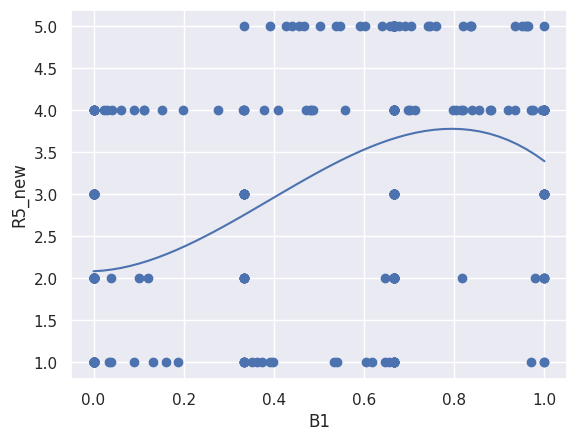

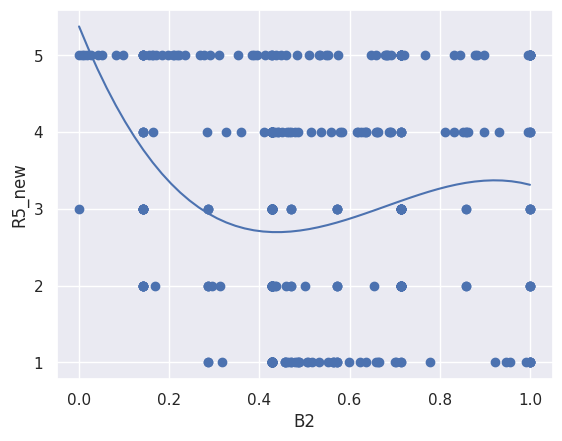

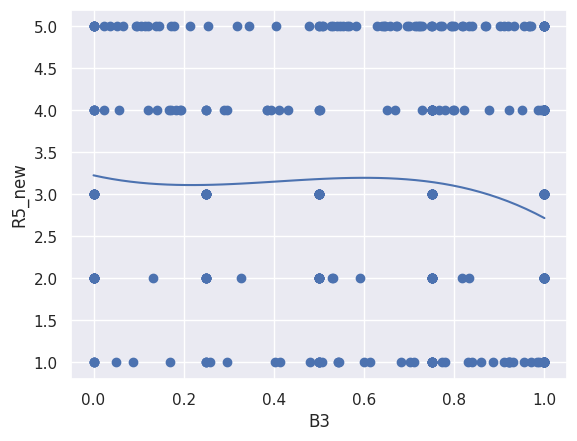

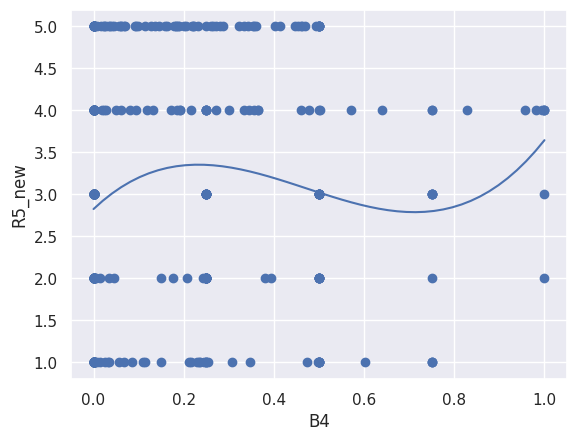

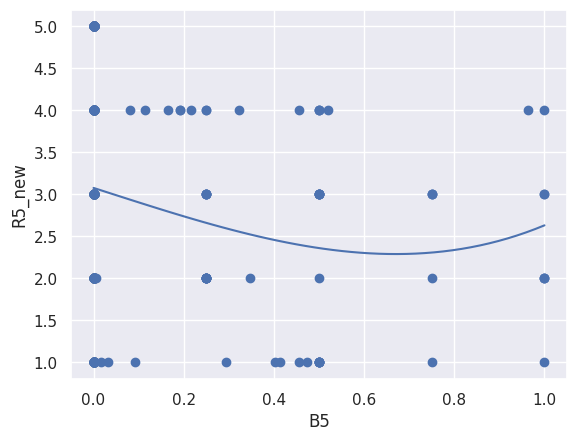

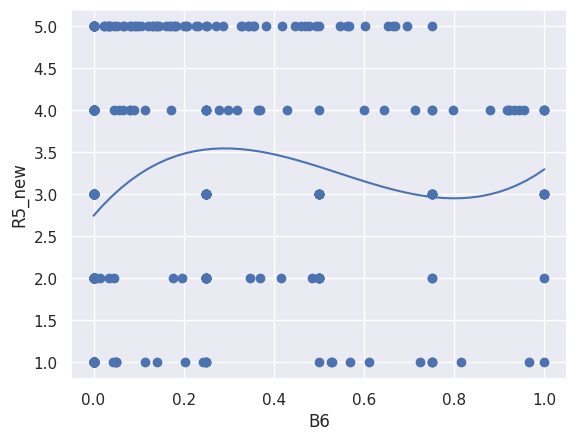

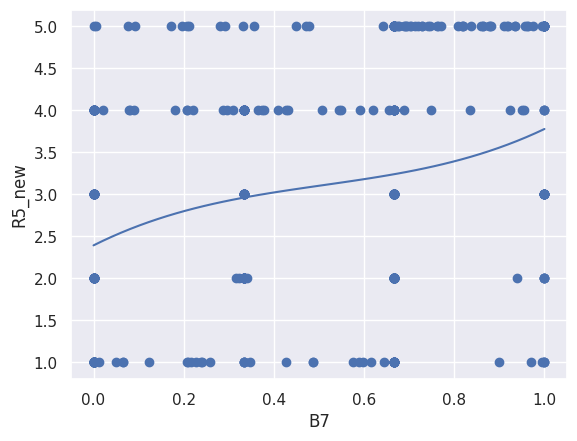

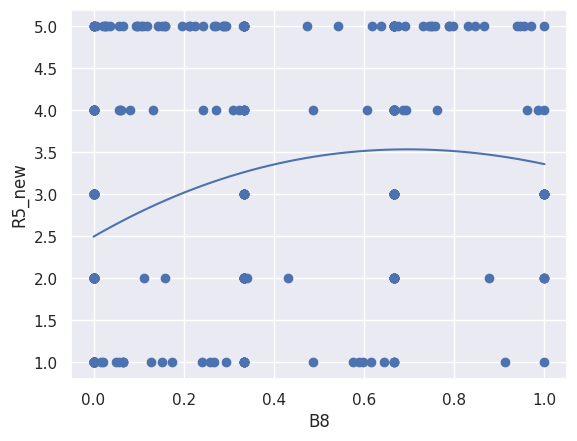

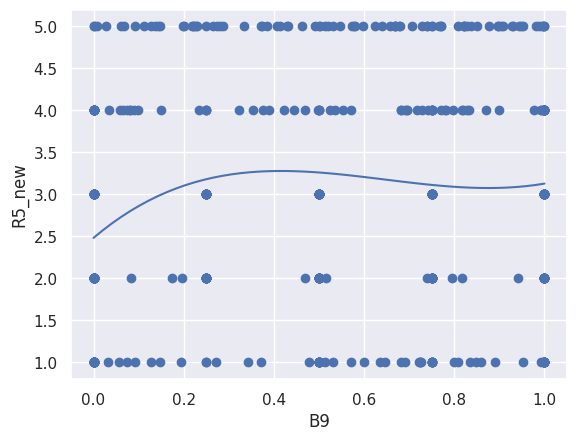

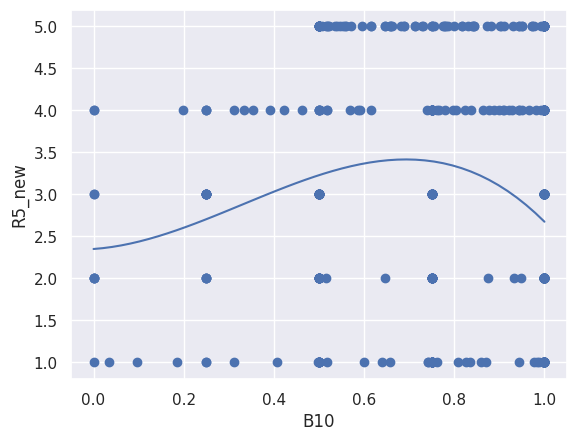

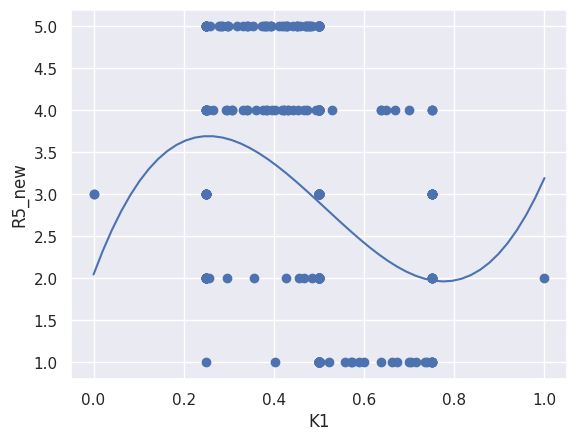

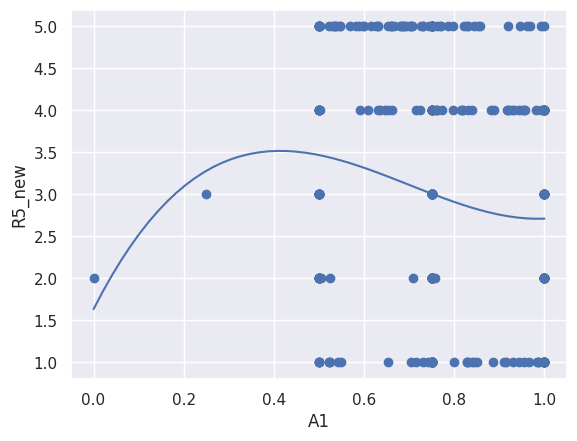

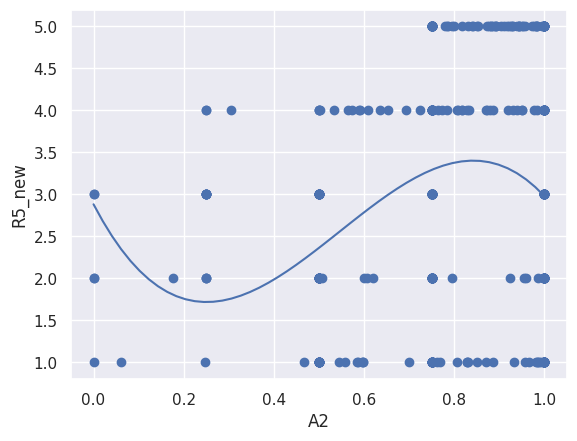

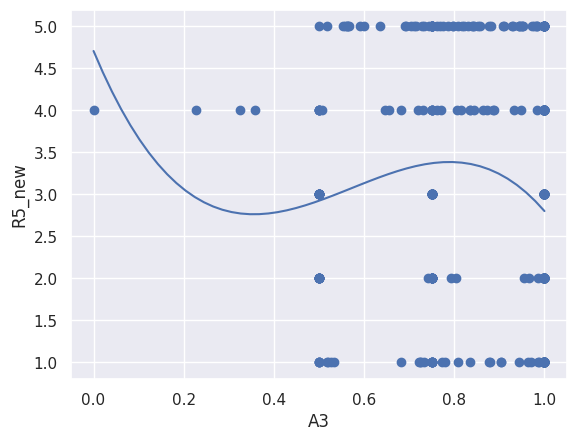

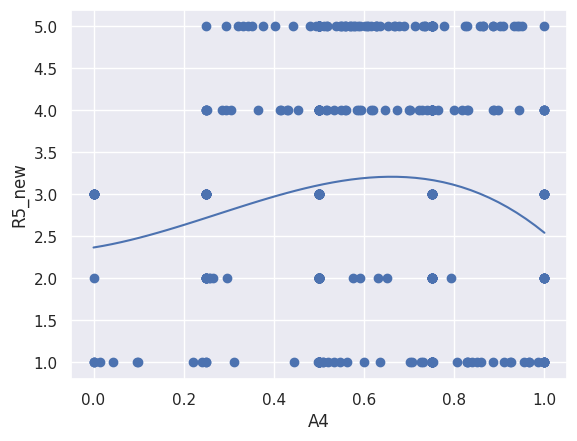

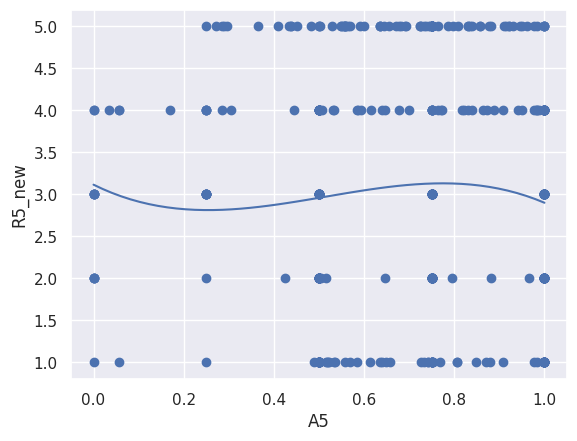

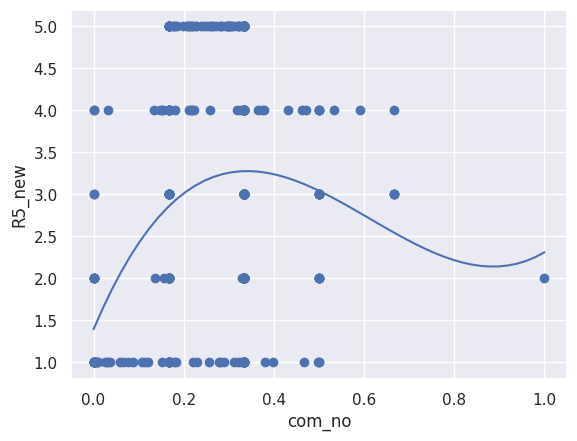

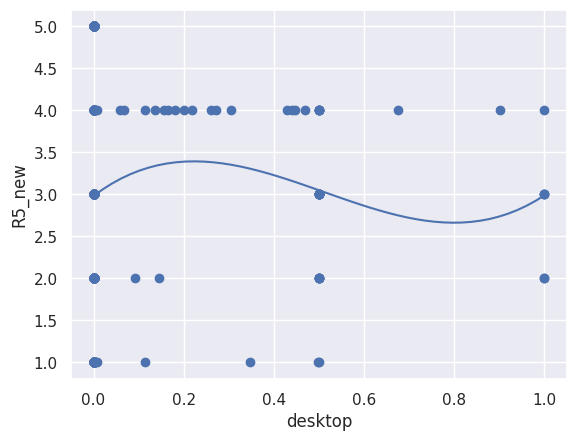

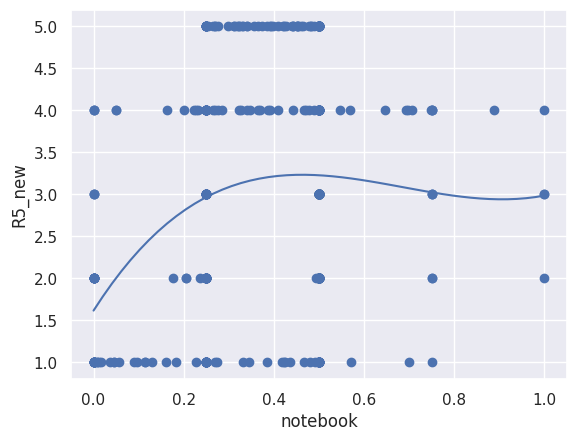

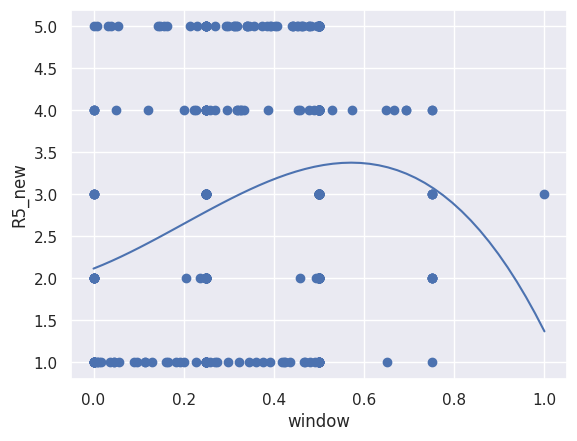

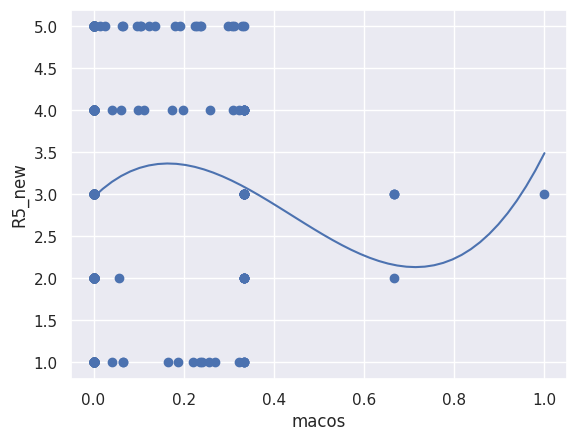

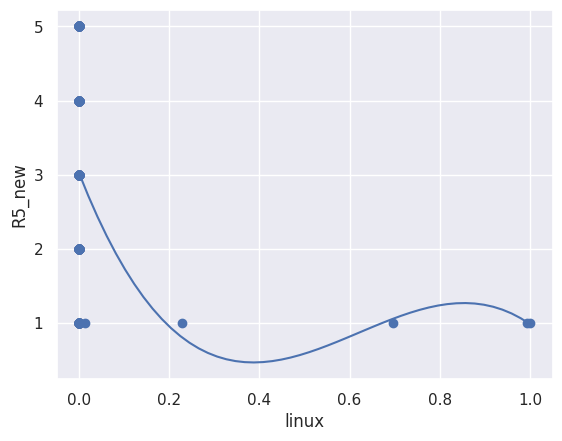

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


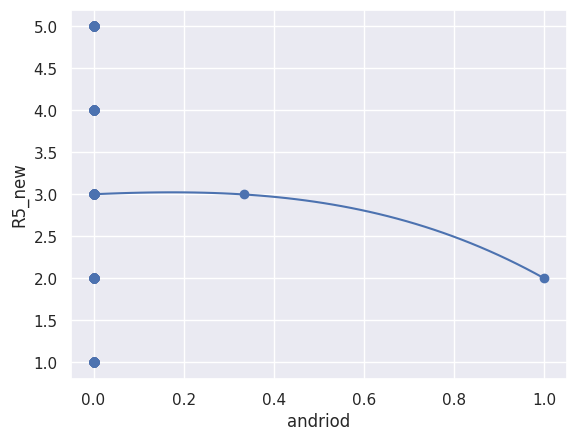

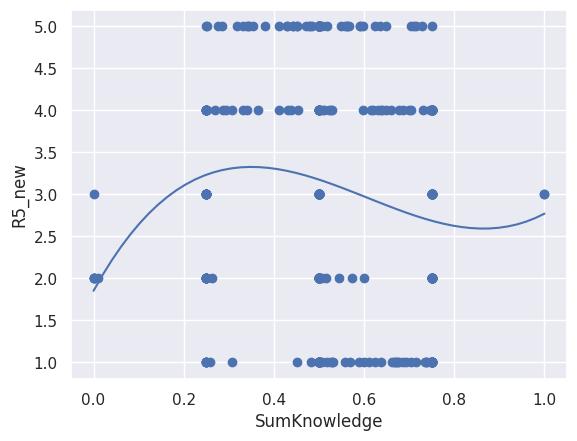

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


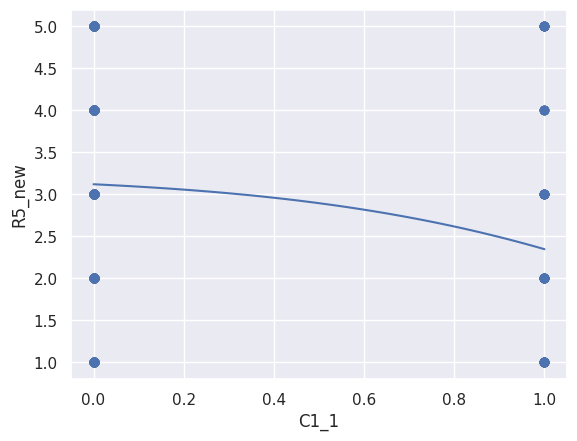

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


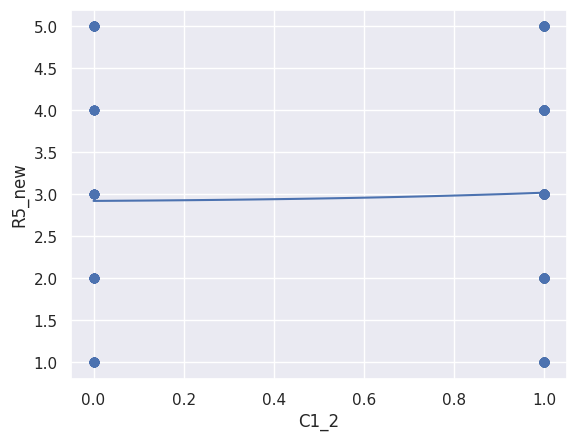

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


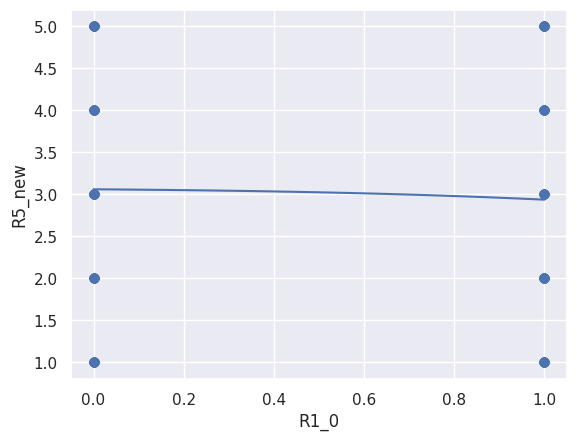

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


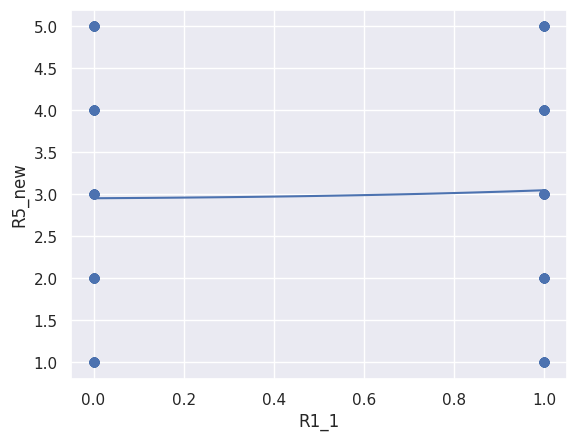

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


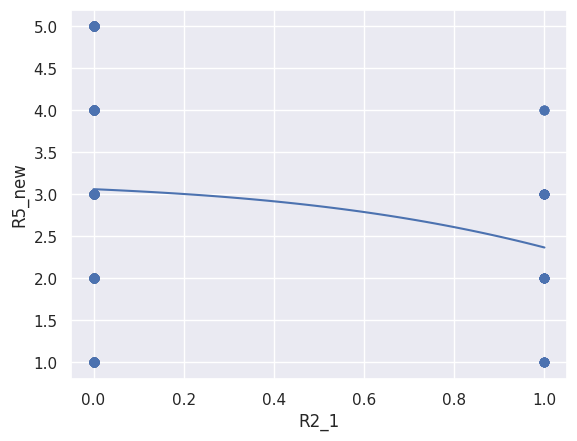

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


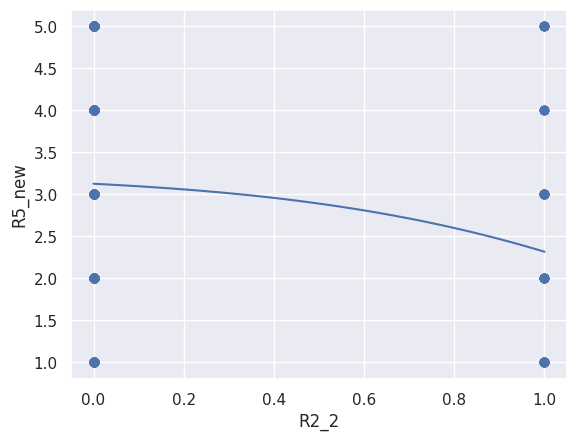

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


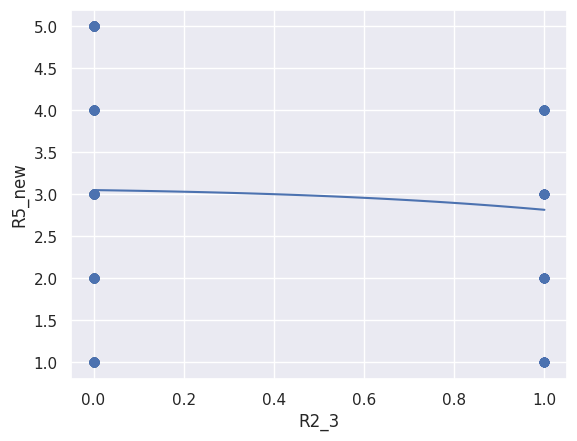

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


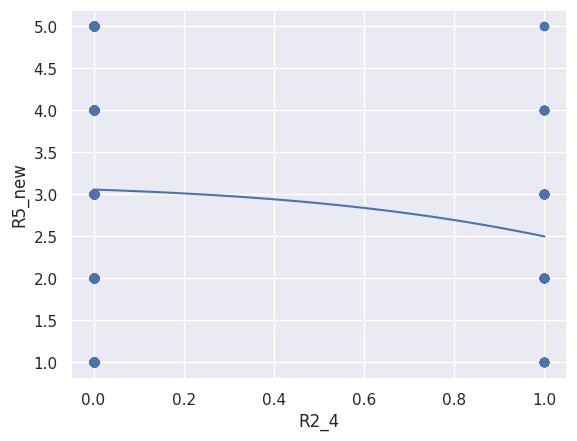

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


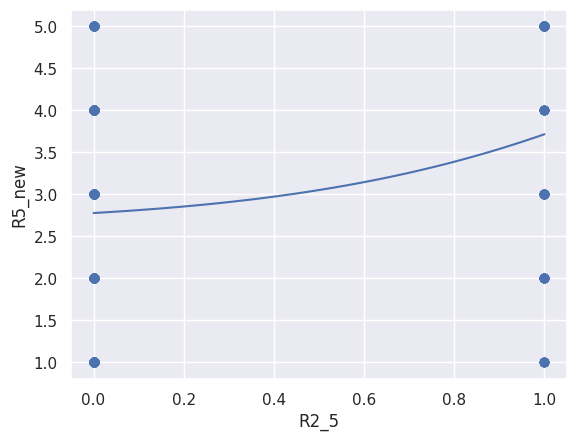

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


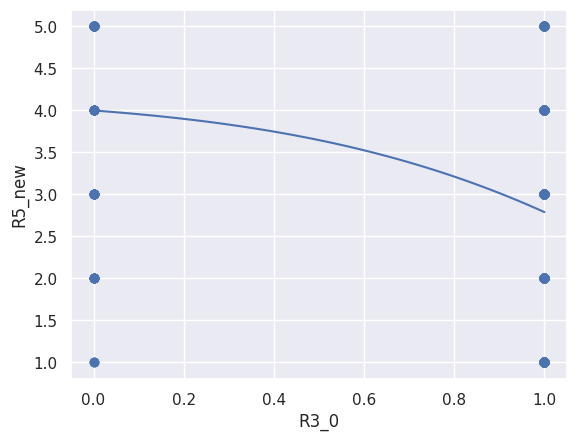

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


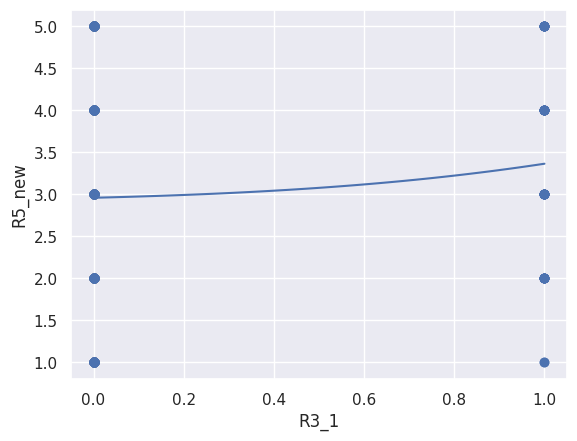

In [ ]:
for i in range(len(feature_res.columns)):
    x = feature_res.iloc[:,i]
    y = labelR5new_res
    mymodel = np.poly1d(np.polyfit(x, y, 3))
    myline = np.linspace(min(x),max(x))
    plt.scatter(x, y)
    # plt.title('Relationship between \n {} and {}'.format(x.name,y.name))
    plt.plot(myline, mymodel(myline))
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()

**Scatter plot**

In [ ]:
# for i in range(len(feature_res.columns)):
#   X = feature_res.iloc[:,i]
#   Y = labelR5new_res
#   sns.scatterplot(X,Y,color='#100EFE',alpha=1,edgecolor="none")
#   plt.title('Relationship between \n {} and {}'.format(X.name,Y.name))

#   X = feature_res.iloc[:,i].to_frame()
#   Y = Y.to_frame()
#   model = LinearRegression()
#   X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
#   model.fit(X_train,Y_train)                                                     
#   r_sq = model.score(X,Y)
#   yhat = model.intercept_ + model.coef_ * X
#   plt.plot(X,yhat,lw=4,c="orange")
#   plt.show() 

**Spearman's rank**

In [ ]:
# Spearman's rank: R5new
column_name = []
rho = []
p_value = []
for i in range(len(feature_res.columns)):
  column_name.append(feature_res.columns[i])
  r = round(stats.spearmanr(labelR5new_res,feature_res.iloc[:,i])[0],3)
  rho.append(r)
  pvalue = round(stats.spearmanr(labelR5new_res,feature_res.iloc[:,i])[1],3)
  p_value.append(pvalue)

dfcorr = pd.DataFrame(list(zip(column_name, rho, p_value)),columns = ['Feature', 'Correlation','P-value'])
dfcorr.sort_values(by=['Correlation'], ascending=False)

Feature  Correlation  P-value
0             B1        0.476    0.000
7             B8        0.341    0.000
6             B7        0.339    0.000
32          R2_5        0.282    0.000
19        window        0.247    0.000
5             B6        0.213    0.000
16        com_no        0.197    0.000
18      notebook        0.188    0.000
8             B9        0.141    0.004
3             B4        0.140    0.004
12            A2        0.130    0.008
34          R3_1        0.085    0.082
20         macos        0.063    0.198
14            A4        0.047    0.334
27          R1_1        0.034    0.491
17       desktop        0.029    0.559
25          C1_2        0.029    0.559
15            A5       -0.009    0.858
22       andriod       -0.025    0.616
26          R1_0       -0.044    0.371
1             B2       -0.045    0.363
30          R2_3       -0.069    0.158
31          R2_4       -0.121    0.013
9            B10       -0.124    0.011
2             B3       -0.135    0.005
28          R2_1       -0.141    0.004
13            A3       -0.144    0.003
4             B5       -0.147    0.003
23  SumKnowledge       -0.148    0.002
21         linux       -0.155    0.001
11            A1       -0.175    0.000
24          C1_1       -0.199    0.000
29          R2_2       -0.208    0.000
33          R3_0       -0.324    0.000
10            K1       -0.372    0.000

**24 features from Spearman's rank**

In [ ]:
feature_spearman = feature_res.loc[:,['B1','B8','B7','R2_5','window','B6','com_no','notebook','B9','B4','A2',
                                      'K1','R3_0','R2_2','C1_1','A1','linux','SumKnowledge','B5','A3','R2_1','B3','B10','R2_4']]
feature_train, feature_test, labelR5new_train, labelR5new_test = train_test_split(feature_spearman,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

# 4.3. Mutual Information

In [ ]:
# Normalize MI (X,Y):R5new
from sklearn.metrics.cluster import normalized_mutual_info_score

column_name = []
nmi = []
for i in range(len(feature_res.columns)):
  column_name.append(feature_res.columns[i])
  x = feature_res.iloc[:,i]
  y = labelR5new_res
  m=normalized_mutual_info_score(x,y)
  nmi.append(round(m,4))

dfnmi = pd.DataFrame(list(zip(column_name, nmi)),columns = ['Feature', 'MI'])
dfnmi_sort = dfnmi.sort_values(by='MI', ascending=False)
dfnmi_sort

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/loc

Feature      MI
8             B9  0.2861
1             B2  0.2770
15            A5  0.2665
14            A4  0.2628
0             B1  0.2563
6             B7  0.2557
2             B3  0.2530
3             B4  0.2453
5             B6  0.2442
9            B10  0.2424
11            A1  0.2419
23  SumKnowledge  0.2368
19        window  0.2355
12            A2  0.2312
13            A3  0.2311
7             B8  0.2310
16        com_no  0.2236
10            K1  0.2218
18      notebook  0.2215
20         macos  0.1458
17       desktop  0.1121
4             B5  0.1090
30          R2_3  0.0703
32          R2_5  0.0678
33          R3_0  0.0633
25          C1_2  0.0326
31          R2_4  0.0322
28          R2_1  0.0317
29          R2_2  0.0286
24          C1_1  0.0258
21         linux  0.0230
34          R3_1  0.0109
27          R1_1  0.0107
22       andriod  0.0094
26          R1_0  0.0085

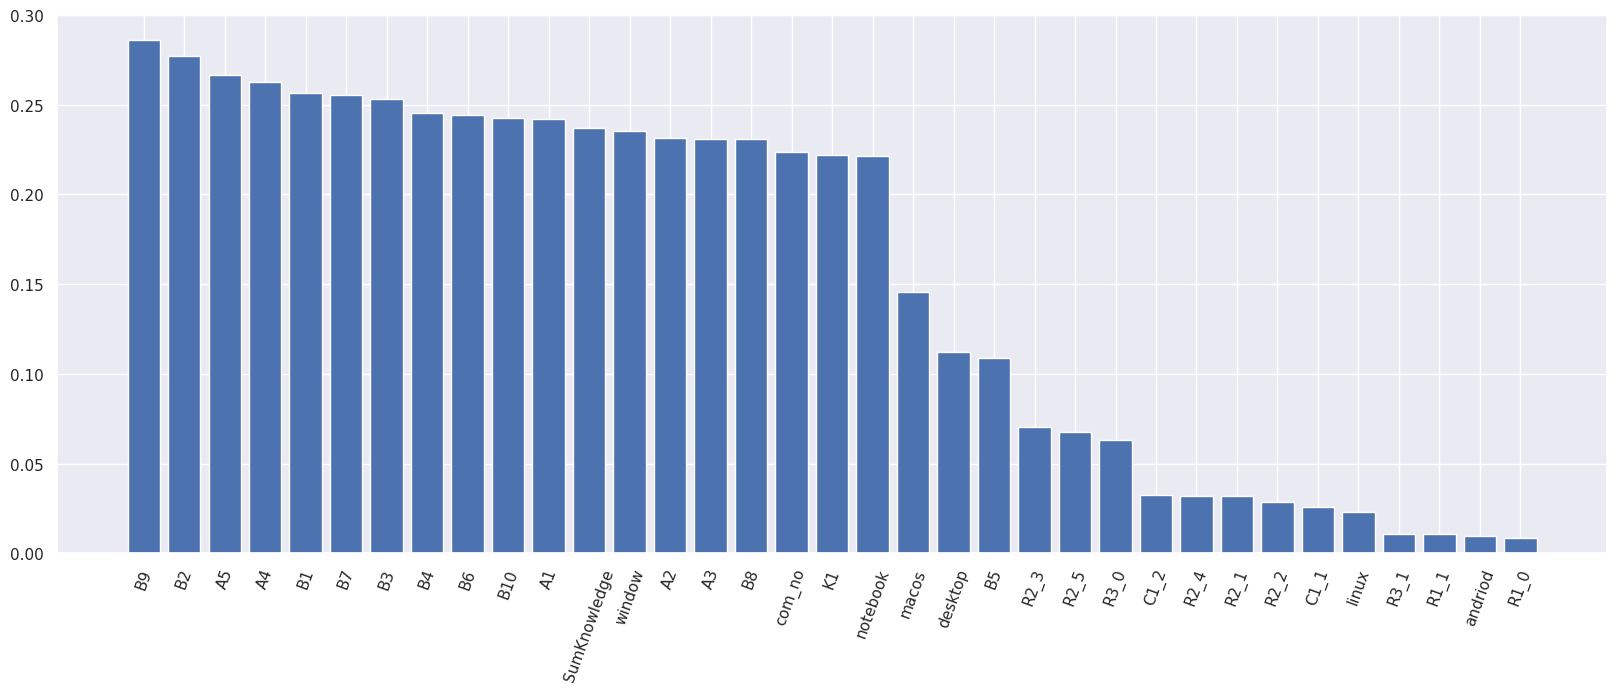

In [ ]:
# Normalize MI (X,Y):R5new
iv = dfnmi_sort['Feature']
mi = dfnmi_sort['MI']
fig = plt.figure(figsize =(20, 7))
plt.bar(iv, mi)
plt.xticks(iv,rotation=70)
plt.show()

**19 features from MI**

In [ ]:
feature_mi = feature_res.loc[:,['B9','B2','A5','A4','B1','B7','B3','B4','B6',
                                'B10','A1','SumKnowledge','window','A2','A3',
                                'B8','com_no','K1','notebook']]
feature_train, feature_test, labelR5new_train, labelR5new_test = train_test_split(feature_mi,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

# 4.4. Exploratory Factor Analysis (EFA)

In [ ]:
pip install factor_analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 37.5 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.4.1-py2.py3-none-any.whl size=42014 sha256=62b2820c102b9f8794a8213c64b34f7bf474a1247e0a1807d8e9d185d92386b8
  Stored in directory: /root/.cache/pip/wheels/c5/94/da/41abe415f64706710726291086a814dd8b9e0dab1c491ef6ed
Successfully built factor_analyzer


In [ ]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

**Data for EFA have 3 dataset**


1.   35 features from all feature (feature_res,labelR5new_res)
2.   24 features from Spearman's rank correlation (feature_spearman,labelR5new_res)
3.   19 features from Mutual Information (feature_mi,labelR5new_res)



**Test assumption** 
1. Bartlett’s Test of Sphericity indicates whether the correlation matrix is an identity or not, and accordingly, the p-value of the test should be significant (p < 0.05). The p-value obtained for the Student Performance Dataset was 0.
2. The KMO test measures the sampling adequacy of the data

***35 features from all feature (feature_res,labelR5new_res)***

In [ ]:
feature_all = feature_res.copy()

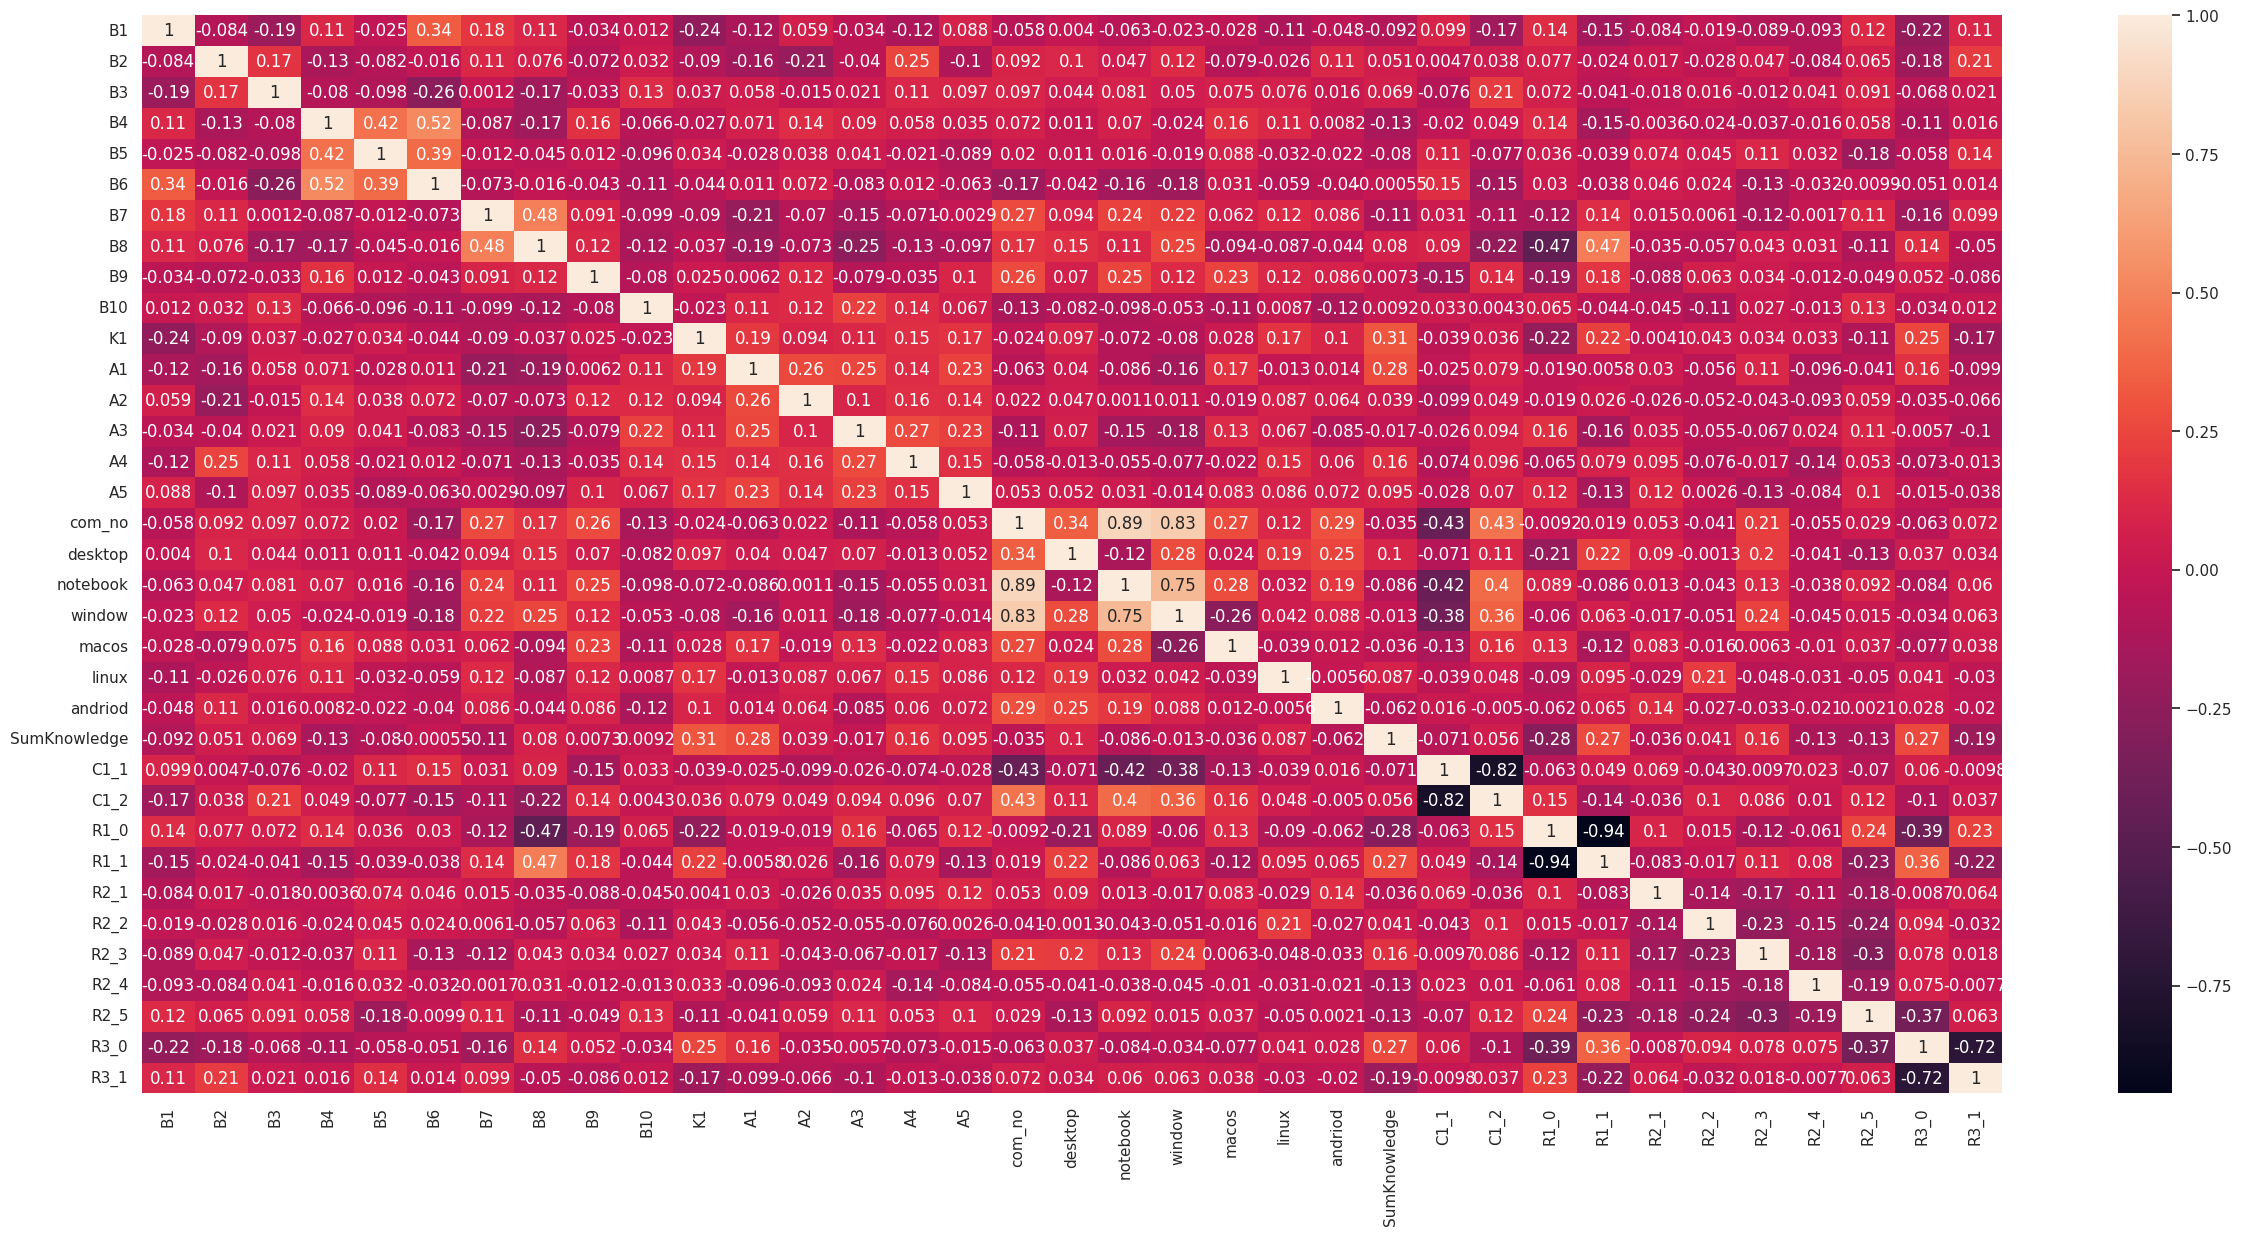

In [ ]:
plt.figure(figsize=(30, 14))
corr = feature_all.corr()
sns.heatmap(corr, annot = True)
plt.show()

In [ ]:
# Bartlett's test of sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(feature_all)
chi_square_value, p_value

print("Chi-square=",round(chi_square_value,2))
print("P-value=",round(p_value,2))

Chi-square= nan
P-value= nan


/usr/local/lib/python3.10/dist-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


In [ ]:
# KMO
kmo_all, kmo_model = calculate_kmo(feature_all)
print("KMO=",round(kmo_model,4))

KMO= 0.527


/usr/local/lib/python3.10/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [ ]:
# Number of factors
n_variables = len(feature_all.columns)
factor_model = FactorAnalyzer(n_factors=n_variables, rotation="varimax")
factor_model.fit(feature_all)

FactorAnalyzer(n_factors=35, rotation='varimax', rotation_kwargs={})

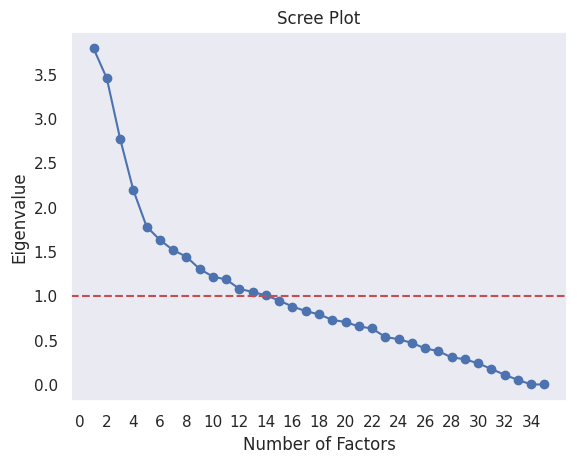

In [ ]:
eigenvalues, _ = factor_model.get_eigenvalues()
# count eigenvalues > 1
number_of_factors = sum(eigenvalues > 1)

# -- Scree plot --
plt.scatter(range(1,feature_all.shape[1]+1),eigenvalues)
plt.plot(range(1,feature_all.shape[1]+1),eigenvalues)
plt.title('Scree Plot')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.xticks(np.arange(0,len(feature_all.columns)+1, step=2))
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()

In [ ]:
number_of_factors

14

In [ ]:
vv, pv, cv = factor_model.get_factor_variance()
extract_tb = pd.DataFrame({"Component" : np.arange(1,len(feature_all.columns)+1, step=1),
                           "Eigenvalues" : eigenvalues,
                           "% of variance" : vv,
                           "Cumulative factor variances" : cv})
extract_tb

Component   Eigenvalues  % of variance  Cumulative factor variances
0           1  3.787311e+00       2.776240                     0.079321
1           2  3.450552e+00       2.224402                     0.142875
2           3  2.772059e+00       1.771703                     0.193496
3           4  2.190752e+00       1.649844                     0.240634
4           5  1.779200e+00       1.643150                     0.287581
5           6  1.629591e+00       1.161619                     0.320770
6           7  1.513800e+00       1.127550                     0.352986
7           8  1.440170e+00       1.086478                     0.384028
8           9  1.301432e+00       1.053120                     0.414117
9          10  1.215026e+00       1.024183                     0.443380
10         11  1.183364e+00       0.958555                     0.470767
11         12  1.077487e+00       0.934020                     0.497453
12         13  1.042611e+00       0.881112                     0.522628
13         14  1.003862e+00       0.826419                     0.546240
14         15  9.453193e-01       0.821395                     0.569708
15         16  8.782279e-01       0.799598                     0.592554
16         17  8.267162e-01       0.788425                     0.615080
17         18  7.900244e-01       0.788142                     0.637599
18         19  7.281044e-01       0.666224                     0.656634
19         20  7.036459e-01       0.651625                     0.675252
20         21  6.537690e-01       0.638662                     0.693499
21         22  6.309344e-01       0.603276                     0.710735
22         23  5.345007e-01       0.563686                     0.726841
23         24  5.104944e-01       0.548232                     0.742505
24         25  4.676868e-01       0.395984                     0.753818
25         26  4.067221e-01       0.345009                     0.763676
26         27  3.754380e-01       0.201591                     0.769435
27         28  3.050069e-01       0.155494                     0.773878
28         29  2.846838e-01       0.091969                     0.776506
29         30  2.370927e-01       0.057005                     0.778135
30         31  1.752041e-01       0.018783                     0.778671
31         32  1.077668e-01       0.004104                     0.778788
32         33  5.144548e-02       0.000000                     0.778788
33         34  2.714465e-15       0.000000                     0.778788
34         35 -1.634663e-15       0.000000                     0.778788

In [ ]:
factor_model = FactorAnalyzer(n_factors=number_of_factors, rotation="varimax")
factor_model.fit(feature_all)

FactorAnalyzer(n_factors=14, rotation='varimax', rotation_kwargs={})

In [ ]:
communalities = factor_model.get_communalities()
communalities = pd.DataFrame(communalities, index=feature_all.T.index, columns=['communalities'])
communalities.sort_values(by=['communalities'], ascending=False)

communalities
desktop            0.999453
com_no             0.998546
macos              0.996348
notebook           0.993048
R3_0               0.987975
window             0.928522
R1_1               0.917069
R1_0               0.910641
R2_3               0.902246
C1_2               0.889138
B6                 0.821812
R2_2               0.797685
C1_1               0.769350
B8                 0.692108
B4                 0.616507
R2_5               0.607389
B2                 0.606449
R3_1               0.606206
B7                 0.441961
A4                 0.421346
B5                 0.408266
A3                 0.406311
B1                 0.397727
A1                 0.372058
R2_1               0.346991
SumKnowledge       0.346060
andriod            0.297496
A5                 0.287357
R2_4               0.260407
A2                 0.248707
K1                 0.243816
linux              0.233332
B9                 0.211059
B10                0.184170
B3                 0.178688

In [ ]:
# Check loadings
loadings = pd.DataFrame(factor_model.loadings_)
loadings.rename(columns = lambda x: 'Factor-' + str(x + 1), inplace=True)
loadings.index = feature_all.columns
loadings

Factor-1  Factor-2  Factor-3  Factor-4  Factor-5  Factor-6  \
B1           -0.003433 -0.100855 -0.125711  0.149948  0.179114 -0.046872   
B2            0.051738 -0.026784 -0.006813  0.127273 -0.075746 -0.295516   
B3            0.043994 -0.077894  0.099437  0.037973 -0.214132  0.087720   
B4            0.074914 -0.120211  0.021745  0.028085  0.728456  0.157325   
B5            0.031681 -0.017152 -0.088027  0.100395  0.556942 -0.021671   
B6           -0.185598  0.017931 -0.021192 -0.023381  0.814611 -0.093183   
B7            0.358771  0.200937 -0.205726  0.176279 -0.085227 -0.159619   
B8            0.282777  0.535457 -0.198077 -0.033268 -0.082281 -0.271642   
B9            0.240667  0.196543  0.077545 -0.031483  0.074196  0.072533   
B10          -0.081686 -0.082231 -0.027211  0.026263 -0.117612  0.252644   
K1           -0.067797  0.222948  0.047384 -0.193136 -0.021653  0.294873   
A1           -0.132467  0.008183  0.078436 -0.132808 -0.004518  0.501559   
A2            0.033340  0.063846  0.056531  0.029153  0.115654  0.431987   
A3           -0.134103 -0.200013  0.025816 -0.071136  0.021426  0.467708   
A4           -0.060831  0.096879  0.061985  0.035078  0.058593  0.372089   
A5            0.063587 -0.103470 -0.008338 -0.020396 -0.078809  0.459341   
com_no        0.911641  0.008519  0.229736  0.034291 -0.004297 -0.021674   
desktop       0.100560  0.157926  0.057985  0.021605 -0.000225  0.064780   
notebook      0.914694 -0.067078  0.215100  0.025907 -0.004484 -0.054204   
window        0.843476  0.041282  0.232048  0.025061 -0.049590 -0.097586   
macos         0.071429 -0.088800  0.088555  0.030874  0.078503  0.073824   
linux         0.096217  0.088824 -0.018736 -0.008535  0.030037  0.201008   
andriod       0.186095  0.040241 -0.063912 -0.019211 -0.013508  0.015561   
SumKnowledge -0.094249  0.290589  0.118302 -0.222224 -0.091957  0.201874   
C1_1         -0.267400  0.001042 -0.826899 -0.013766  0.060890 -0.060901   
C1_2          0.228001 -0.118654  0.882895  0.031001 -0.054125  0.086214   
R1_0          0.002906 -0.925443  0.055274  0.172781  0.030832  0.012875   
R1_1          0.000946  0.931518 -0.044277 -0.148552 -0.037827 -0.030848   
R2_1          0.024151 -0.082060 -0.059767  0.035175  0.029140  0.088091   
R2_2         -0.069094 -0.040015  0.084854 -0.059388  0.000951 -0.127698   
R2_3          0.165852  0.078828 -0.013712 -0.001310 -0.010108 -0.041837   
R2_4         -0.053917  0.056846  0.027445 -0.040289  0.008207 -0.129751   
R2_5          0.056554 -0.209007  0.046354  0.159546 -0.081980  0.129596   
R3_0         -0.030753  0.221422 -0.048402 -0.936312 -0.057326 -0.006120   
R3_1          0.022947 -0.114971  0.011969  0.745881  0.035985 -0.116285   

              Factor-7  Factor-8  Factor-9  Factor-10  Factor-11  Factor-12  \
B1           -0.220823 -0.039416  0.103486  -0.114901  -0.251671   0.348771   
B2           -0.009191 -0.048408  0.096043  -0.036050   0.673362   0.157129   
B3            0.025210  0.059343  0.008606   0.069951   0.264164  -0.111309   
B4           -0.031428  0.091043  0.022552   0.028781  -0.025720  -0.069361   
B5            0.168216  0.045419 -0.014147   0.080959  -0.021982  -0.150751   
B6           -0.137165 -0.021641 -0.012907  -0.074011  -0.051948   0.284201   
B7           -0.311689  0.106802  0.125729   0.037466   0.018723   0.070421   
B8           -0.147322 -0.004564  0.127292  -0.096770  -0.090952   0.136614   
B9           -0.017602  0.223129  0.014921   0.116074  -0.110087  -0.009936   
B10           0.033207 -0.117561 -0.045485  -0.100490   0.136516  -0.054469   
K1            0.089837  0.034293  0.011706   0.134089   0.089956  -0.049175   
A1            0.187750  0.132411 -0.024328  -0.040721  -0.021369   0.116793   
A2           -0.032617 -0.059798 -0.002290  -0.011434  -0.132422   0.075679   
A3           -0.030750  0.080416  0.113542  -0.024563   0.184238  -0.176116   
A4           -0.022087 -0.049823 -0.056382  -0.001695   0.498520   0.058322   
A5           

In [ ]:
def color_factor_importance(val):
    if np.abs(val) > 0.4:
        color = 'green'
    elif np.abs(val) > 0.3 and np.abs(val) <= 0.4:
        color = 'blue'
    else: 
        color = 'red'
    return 'color: %s' % color

loadings.style.applymap(color_factor_importance)

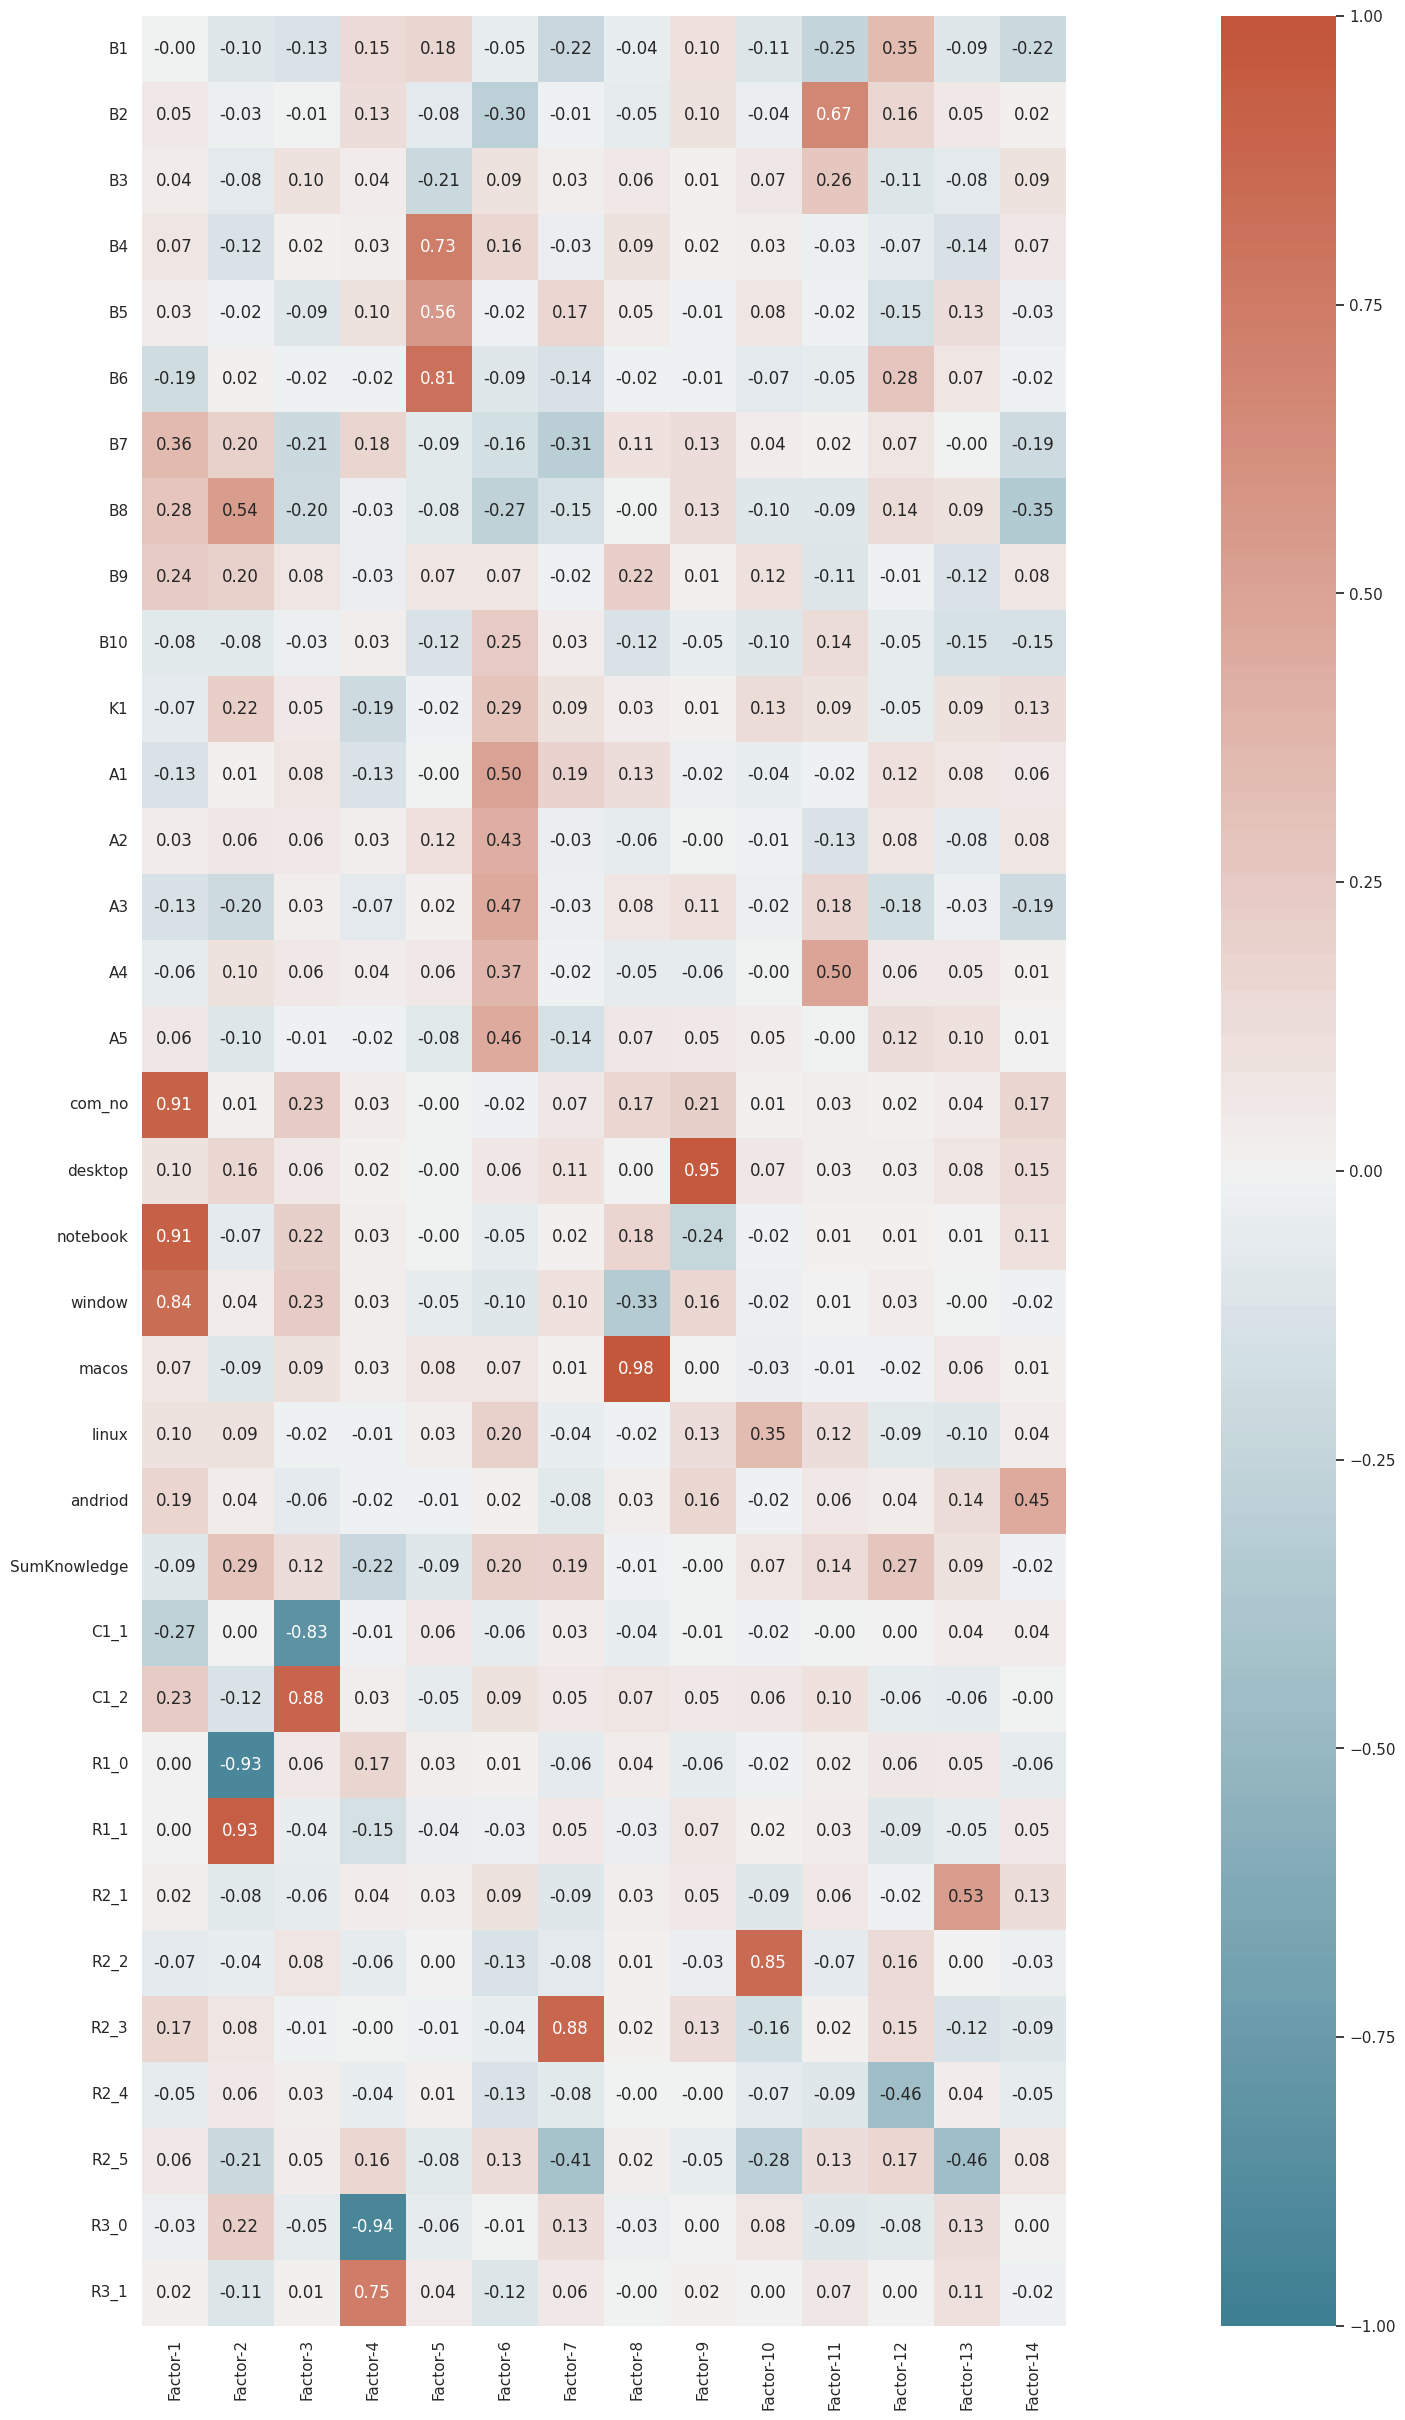

In [ ]:
plt.figure(figsize=(40,30))

# plot the heatmap for correlation matrix
ax = sns.heatmap(loadings, 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 20, n=200),
                 square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

In [ ]:
feature_all.shape

(420, 35)

In [ ]:
feature_all_latent = factor_model.transform(feature_all)
feature_all_latent.shape

(420, 14)

***24 features from Spearman's rank correlation (feature_spearman,labelR5new_res)***

In [ ]:
feature_spearman.head(5)

B1        B8        B7  R2_5  window    B6    com_no  notebook   B9  \
0  0.666667  1.000000  1.000000     1    0.50  0.00  0.333333      0.50  0.0   
1  0.666667  0.000000  0.000000     0    0.00  0.75  0.000000      0.00  0.5   
2  0.000000  0.333333  0.666667     0    0.75  0.50  0.500000      0.75  0.5   
3  0.000000  0.000000  0.333333     1    0.25  0.25  0.166667      0.25  0.5   
4  0.000000  0.666667  0.666667     0    0.50  0.00  0.333333      0.50  0.5   

     B4  ...  C1_1    A1  linux  SumKnowledge   B5    A3  R2_1    B3   B10  \
0  0.00  ...     0  0.75    0.0          0.50  0.0  1.00     0  0.75  0.75   
1  0.25  ...     1  0.75    0.0          0.50  0.0  1.00     0  0.50  0.75   
2  0.50  ...     0  1.00    0.0          0.75  0.5  0.75     0  0.50  0.50   
3  0.00  ...     0  1.00    0.0          0.75  0.0  1.00     0  0.75  1.00   
4  0.00  ...     0  0.50    0.0          0.75  0.0  0.75     0  1.00  0.25   

   R2_4  
0     0  
1     0  
2     0  
3     0  
4     1  

[5 rows x 24 columns]

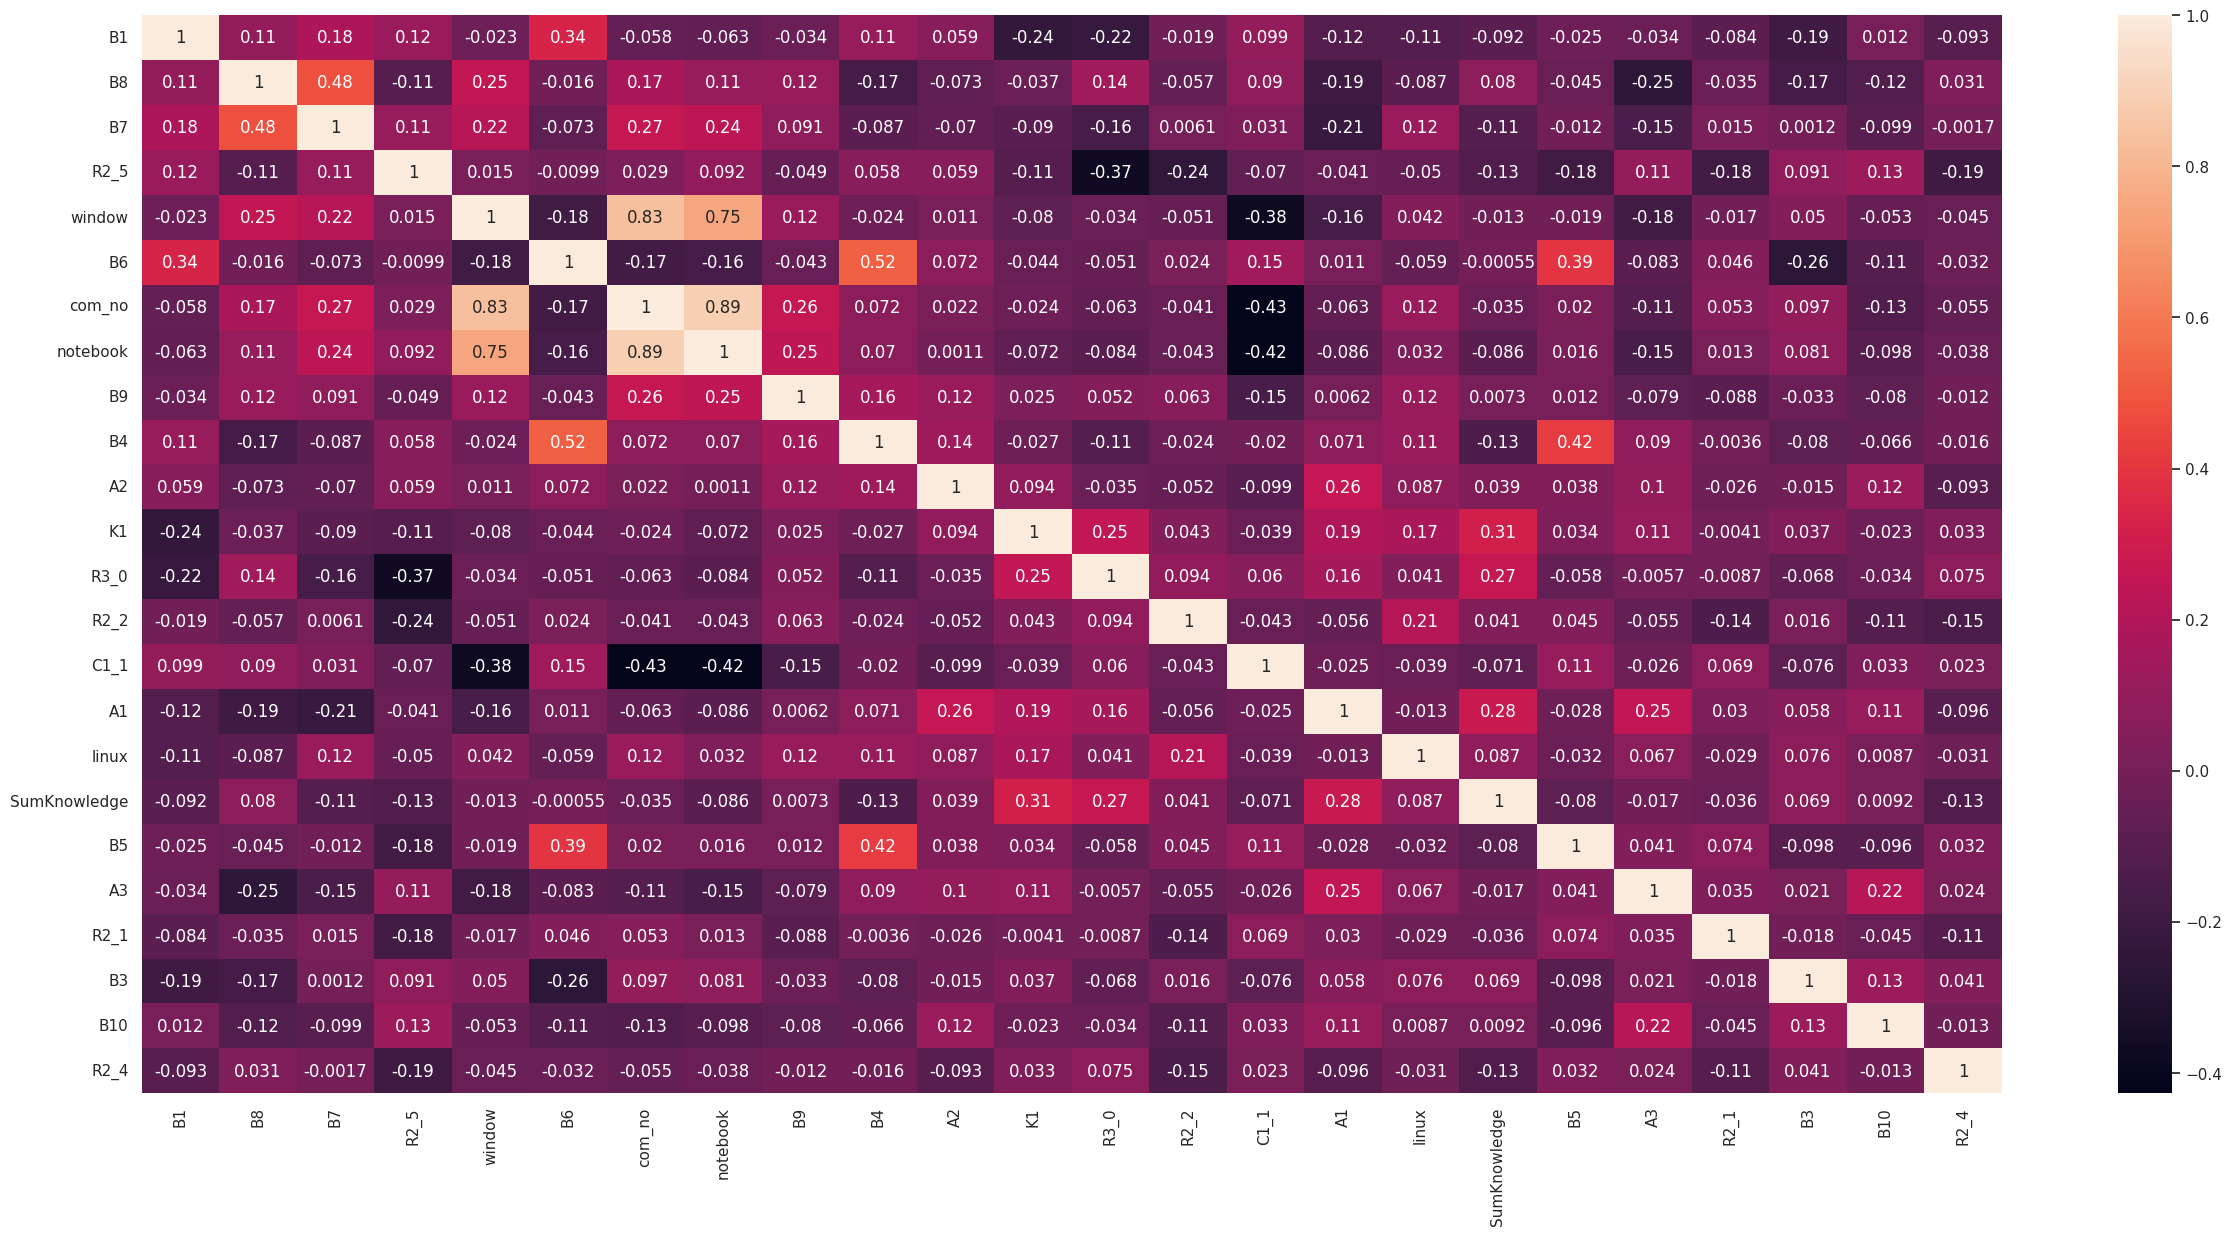

In [ ]:
plt.figure(figsize=(30, 14))
corr = feature_spearman.corr()
sns.heatmap(corr, annot = True)
plt.show()

In [ ]:
# Bartlett's test of sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(feature_spearman)
chi_square_value, p_value

print("Chi-square=",round(chi_square_value,2))
print("P-value=",round(p_value,2))

Chi-square= 2801.1
P-value= 0.0


In [ ]:
# KMO
kmo_all, kmo_model = calculate_kmo(feature_spearman)
print("KMO=",round(kmo_model,4))

KMO= 0.6257


/usr/local/lib/python3.10/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [ ]:
# Number of factors
n_variables = len(feature_spearman.columns)
factor_model = FactorAnalyzer(n_factors=n_variables, rotation=None)
factor_model.fit(feature_spearman)

FactorAnalyzer(n_factors=24, rotation=None, rotation_kwargs={})

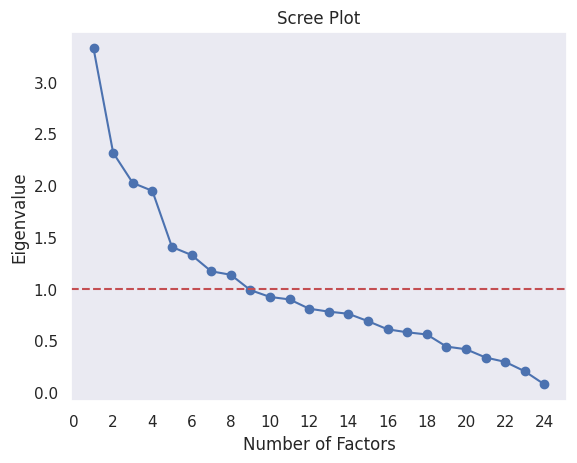

In [ ]:
eigenvalues, _ = factor_model.get_eigenvalues()
# count eigenvalues > 1
number_of_factors = sum(eigenvalues > 1)

# -- Scree plot --
plt.scatter(range(1,feature_spearman.shape[1]+1),eigenvalues)
plt.plot(range(1,feature_spearman.shape[1]+1),eigenvalues)
plt.title('Scree Plot')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.xticks(np.arange(0,len(feature_spearman.columns)+1, step=2))
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()

In [ ]:
number_of_factors

8

In [ ]:
# Extraction Sums of Squared Loadings
vv, pv, cv = factor_model.get_factor_variance()
extract_tb = pd.DataFrame({"Component" : np.arange(1,len(feature_spearman.columns)+1, step=1),
                           "Eigenvalues" : eigenvalues,
                           "variance" : vv,
                           "proportional factor variances" : pv,
                           "Cumulative factor variances" : cv})
extract_tb

Component  Eigenvalues  variance  proportional factor variances  \
0           1     3.325652  3.192242                       0.133010   
1           2     2.316349  1.988356                       0.082848   
2           3     2.024726  1.724817                       0.071867   
3           4     1.947851  1.597021                       0.066543   
4           5     1.404839  1.048066                       0.043669   
5           6     1.327110  0.933998                       0.038917   
6           7     1.169693  0.781232                       0.032551   
7           8     1.136062  0.699479                       0.029145   
8           9     0.987724  0.586502                       0.024438   
9          10     0.921557  0.472539                       0.019689   
10         11     0.897502  0.424490                       0.017687   
11         12     0.807489  0.402781                       0.016783   
12         13     0.779519  0.355467                       0.014811   
13         14     0.758566  0.307287                       0.012804   
14         15     0.687270  0.244181                       0.010174   
15         16     0.608212  0.212152                       0.008840   
16         17     0.579466  0.167621                       0.006984   
17         18     0.558509  0.132318                       0.005513   
18         19     0.441376  0.090932                       0.003789   
19         20     0.415329  0.048731                       0.002030   
20         21     0.335510  0.039384                       0.001641   
21         22     0.293100  0.038309                       0.001596   
22         23     0.201677  0.005132                       0.000214   
23         24     0.074912  0.000000                       0.000000   

    Cumulative factor variances  
0                      0.133010  
1                      0.215858  
2                      0.287726  
3                      0.354268  
4                      0.397938  
5                      0.436854  
6                      0.469406  
7                      0.498550  
8                      0.522988  
9                      0.542677  
10                     0.560364  
11                     0.577147  
12                     0.591958  
13                     0.604762  
14                     0.614936  
15                     0.623775  
16                     0.630760  
17                     0.636273  
18                     0.640062  
19                     0.642092  
20                     0.643733  
21                     0.645329  
22                     0.645543  
23                     0.645543

In [ ]:
# communalities
communalities = factor_model.get_communalities()
communalities = pd.DataFrame(communalities, index=feature_spearman.T.index, columns=['communalities'])
communalities.sort_values(by=['communalities'], ascending=False)

communalities
com_no             0.995003
notebook           0.932842
window             0.919040
B6                 0.872472
R2_5               0.830930
B4                 0.773225
B8                 0.772997
B7                 0.752671
B5                 0.687492
B1                 0.674159
SumKnowledge       0.664573
A1                 0.654325
R2_2               0.617762
linux              0.575146
A3                 0.573546
R2_4               0.568612
C1_1               0.531189
R2_1               0.527720
R3_0               0.499896
A2                 0.468641
B3                 0.441675
K1                 0.404050
B9                 0.391799
B10                0.363272

In [ ]:
# Rotation
factor_model = FactorAnalyzer(n_factors=number_of_factors, rotation="varimax")
factor_model.fit(feature_spearman)

FactorAnalyzer(n_factors=8, rotation='varimax', rotation_kwargs={})

In [ ]:
# Rotation Sums of Squared Loadings
eigenvalues, _ = factor_model.get_eigenvalues()
vv, pv, cv = factor_model.get_factor_variance()
rotation_tb = pd.DataFrame({"Component" : np.arange(1,number_of_factors+1, step=1),
                          #  "Eigenvalues" : eigenvalues,
                           "% of variance" : vv,
                           "Cumulative factor variances" : cv})
rotation_tb

Component  % of variance  Cumulative factor variances
0          1       2.842574                     0.118441
1          2       1.657538                     0.187505
2          3       1.441262                     0.247557
3          4       1.255242                     0.299859
4          5       1.136529                     0.347214
5          6       0.934254                     0.386142
6          7       0.794072                     0.419228
7          8       0.659760                     0.446718

In [ ]:
# Rotation Sums of Squared Loadings
eig = pd.DataFrame({"Component" : np.arange(1,len(feature_spearman.columns)+1, step=1),
                    "Eigenvalues" : eigenvalues})
eig

Component  Eigenvalues
0           1     3.325652
1           2     2.316349
2           3     2.024726
3           4     1.947851
4           5     1.404839
5           6     1.327110
6           7     1.169693
7           8     1.136062
8           9     0.987724
9          10     0.921557
10         11     0.897502
11         12     0.807489
12         13     0.779519
13         14     0.758566
14         15     0.687270
15         16     0.608212
16         17     0.579466
17         18     0.558509
18         19     0.441376
19         20     0.415329
20         21     0.335510
21         22     0.293100
22         23     0.201677
23         24     0.074912

In [ ]:
# Check loadings of Rotation
loadings = pd.DataFrame(factor_model.loadings_)
loadings.rename(columns = lambda x: 'Factor-' + str(x + 1), inplace=True)
loadings.index = feature_spearman.columns
loadings

Factor-1  Factor-2  Factor-3  Factor-4  Factor-5  Factor-6  \
B1           -0.103520  0.212850 -0.281007  0.201535 -0.047234 -0.138553   
B8            0.095490 -0.035606  0.159105  0.710374 -0.294129 -0.056302   
B7            0.138376 -0.061237 -0.247236  0.721131 -0.083599  0.047047   
R2_5          0.060265 -0.113360 -0.434303  0.061700  0.411734 -0.168377   
window        0.813260 -0.079700 -0.044279  0.144197 -0.148752  0.006463   
B6           -0.181097  0.772054 -0.031383  0.010391 -0.073453 -0.038049   
com_no        0.970525  0.006002 -0.038575  0.139912 -0.049380  0.096553   
notebook      0.895169 -0.008916 -0.120674  0.069630 -0.066130  0.041042   
B9            0.256125  0.108943  0.086053  0.105012 -0.004580 -0.094958   
B4            0.099489  0.749789 -0.123015 -0.097321  0.195060 -0.029762   
A2            0.070177  0.136847  0.107593 -0.012242  0.322612 -0.046087   
K1           -0.013837 -0.005232  0.449672 -0.010443  0.168684  0.012403   
R3_0         -0.046403 -0.040574  0.602563 -0.011293 -0.156637 -0.012554   
R2_2         -0.054063  0.009032  0.098181 -0.152452 -0.388848 -0.134394   
C1_1         -0.487848  0.090569 -0.023259  0.147038 -0.073282  0.077267   
A1           -0.028016  0.040422  0.392492 -0.156389  0.422433  0.037934   
linux         0.073388  0.017528  0.088505  0.052550  0.083880 -0.005245   
SumKnowledge  0.000312 -0.088893  0.540634  0.027584  0.092105 -0.048794   
B5           -0.000093  0.541380 -0.011777 -0.042217 -0.066523  0.102731   
A3           -0.110122  0.001285  0.026063 -0.162711  0.399904  0.050692   
R2_1         -0.024250  0.048670  0.017354 -0.006246 -0.025232  0.898950   
B3            0.098723 -0.247219 -0.040349 -0.114919  0.160725  0.022129   
B10          -0.086202 -0.149542 -0.040200 -0.073474  0.310016 -0.033983   
R2_4         -0.052710  0.017555  0.011361  0.014299 -0.065810 -0.075702   

              Factor-7  Factor-8  
B1           -0.185982  0.320993  
B8           -0.179983 -0.009403  
B7            0.208995  0.020543  
R2_5         -0.098183  0.200795  
window       -0.077176  0.016499  
B6           -0.150149  0.227364  
com_no        0.070114 -0.003160  
notebook      0.009414 -0.017519  
B9            0.154235 -0.017068  
B4            0.135313 -0.038228  
A2            0.044458  0.142847  
K1            0.190850 -0.072603  
R3_0         -0.009157 -0.131102  
R2_2          0.516446  0.241688  
C1_1         -0.060016 -0.067473  
A1           -0.008123  0.128558  
linux         0.487244  0.004659  
SumKnowledge  0.012540  0.212833  
B5            0.074345 -0.140998  
A3            0.090633 -0.060777  
R2_1         -0.065162  0.076849  
B3            0.164975 -0.092893  
B10          -0.042770  0.002189  
R2_4         -0.068562 -0.506031

In [ ]:
def color_factor_importance(val):
    if np.abs(val) > 0.4:
        color = 'green'
    elif np.abs(val) > 0.3 and np.abs(val) <= 0.4:
        color = 'blue'
    else: 
        color = 'red'
    return 'color: %s' % color

loadings.style.applymap(color_factor_importance)

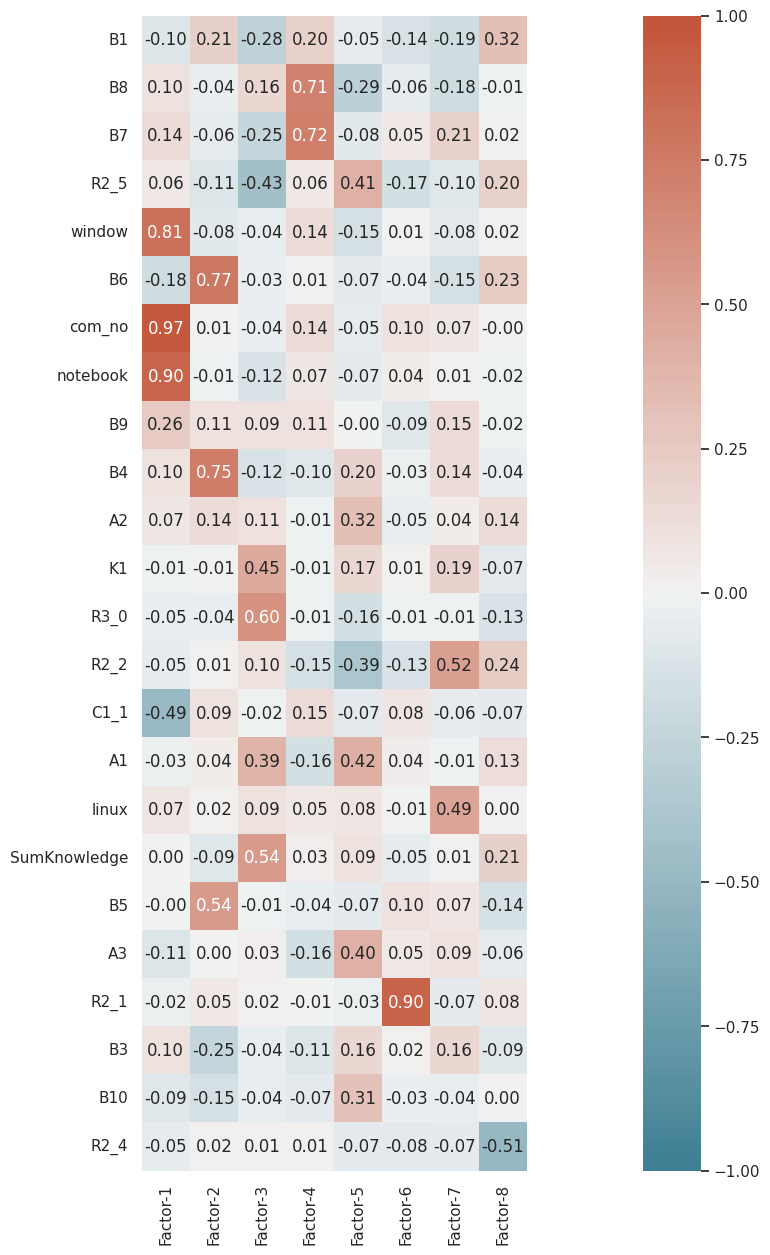

In [ ]:
plt.figure(figsize=(30,15))

# plot the heatmap for correlation matrix
ax = sns.heatmap(loadings, 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 20, n=200),
                 square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

In [ ]:
feature_spearman.shape

(420, 24)

In [ ]:
feature_spearman_latent = factor_model.transform(feature_spearman)
feature_spearman_latent.shape

(420, 8)

In [ ]:
pd.DataFrame(feature_spearman_latent).head(5)

0         1         2         3         4         5         6  \
0  0.293627 -0.833711 -0.273435  1.791435  0.369634 -0.288792 -0.429920   
1 -2.166433  1.123154  0.205031 -1.037174 -0.851882 -0.539792  0.573637   
2  1.799700  1.515652  0.478062 -0.284686 -1.045897 -0.193884  0.891180   
3 -0.619585 -0.519078  0.476571 -0.408816  1.466186 -0.314865 -0.152223   
4  0.463451 -0.597103  0.436230  0.691155 -0.939497 -0.251936 -0.152089   

          7  
0  0.238024  
1  0.938013  
2  0.635576  
3  0.607132  
4 -1.531658

***19 features from Mutual Information (feature_mi,labelR5new_res)***

In [ ]:
feature_mi.head(5)

B9        B2    A5    A4        B1        B7    B3    B4    B6   B10  \
0  0.0  0.428571  1.00  0.75  0.666667  1.000000  0.75  0.00  0.00  0.75   
1  0.5  0.428571  0.75  0.50  0.666667  0.000000  0.50  0.25  0.75  0.75   
2  0.5  0.428571  0.75  0.75  0.000000  0.666667  0.50  0.50  0.50  0.50   
3  0.5  0.428571  1.00  1.00  0.000000  0.333333  0.75  0.00  0.25  1.00   
4  0.5  0.470877  1.00  0.00  0.000000  0.666667  1.00  0.00  0.00  0.25   

     A1  SumKnowledge  window    A2    A3        B8    com_no    K1  notebook  
0  0.75          0.50    0.50  0.75  1.00  1.000000  0.333333  0.50      0.50  
1  0.75          0.50    0.00  0.75  1.00  0.000000  0.000000  0.50      0.00  
2  1.00          0.75    0.75  0.75  0.75  0.333333  0.500000  0.25      0.75  
3  1.00          0.75    0.25  1.00  1.00  0.000000  0.166667  0.50      0.25  
4  0.50          0.75    0.50  0.75  0.75  0.666667  0.333333  0.50      0.50

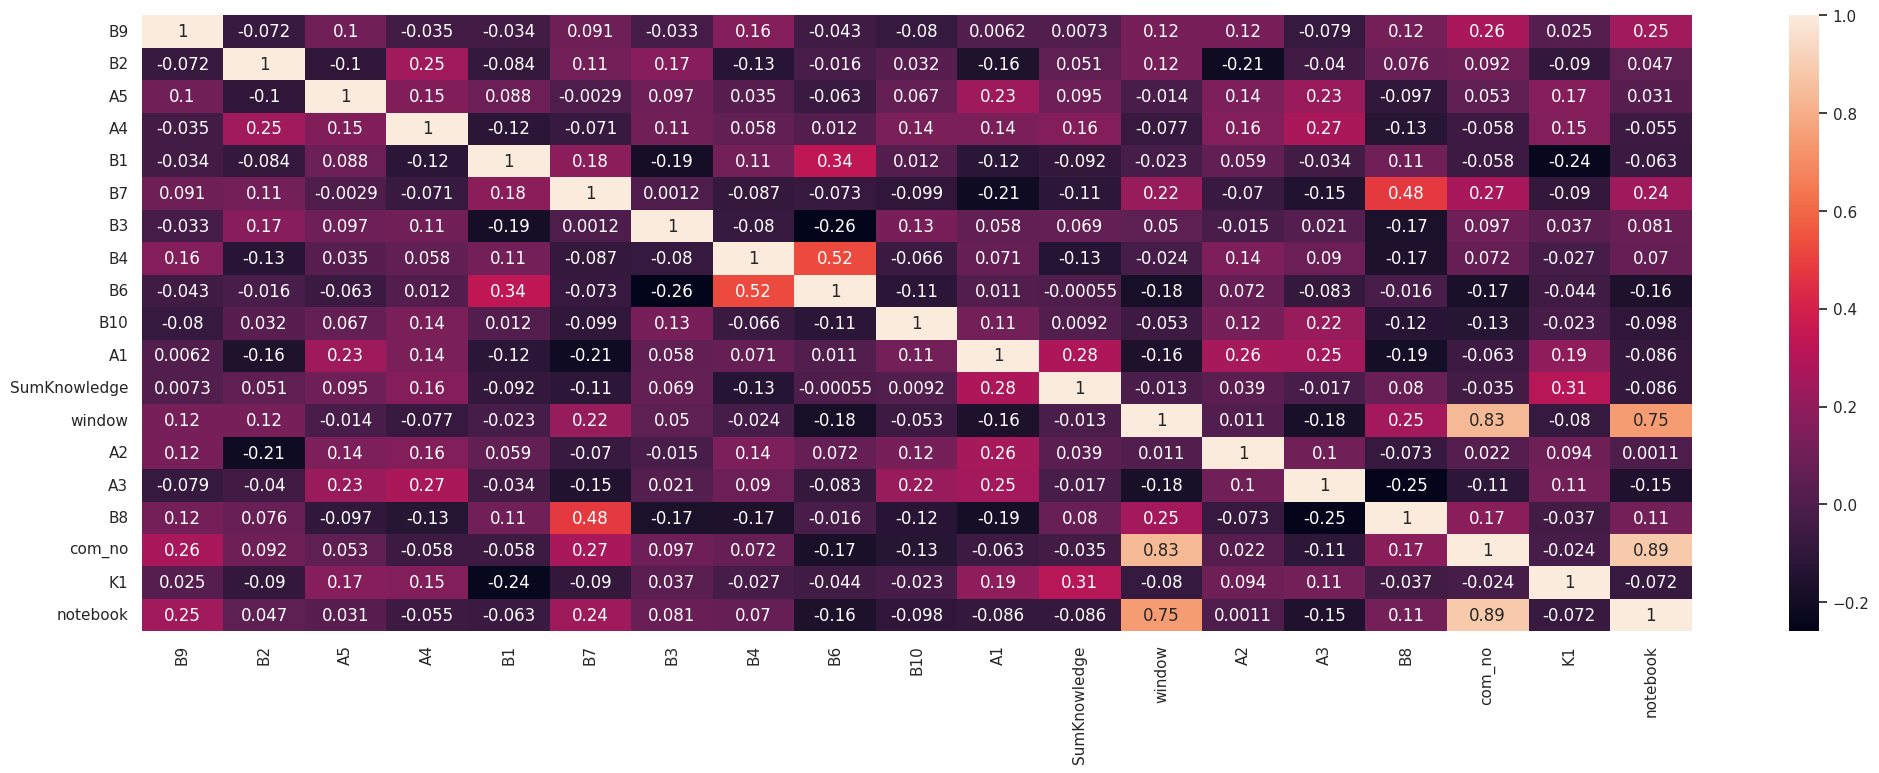

In [ ]:
plt.figure(figsize=(25, 8))
corr = feature_mi.corr()
sns.heatmap(corr, annot = True)
plt.show()

In [ ]:
# Bartlett's test of sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(feature_mi)
chi_square_value, p_value

print("Chi-square=",round(chi_square_value,2))
print("P-value=",round(p_value,2))

Chi-square= 2317.16
P-value= 0.0


In [ ]:
# KMO
kmo_all, kmo_model = calculate_kmo(feature_mi)
print("KMO=",round(kmo_model,4))

KMO= 0.6338


/usr/local/lib/python3.10/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [ ]:
# Number of factors
n_variables = len(feature_mi.columns)
factor_model = FactorAnalyzer(n_factors=n_variables, rotation=None)
factor_model.fit(feature_mi)

FactorAnalyzer(n_factors=19, rotation=None, rotation_kwargs={})

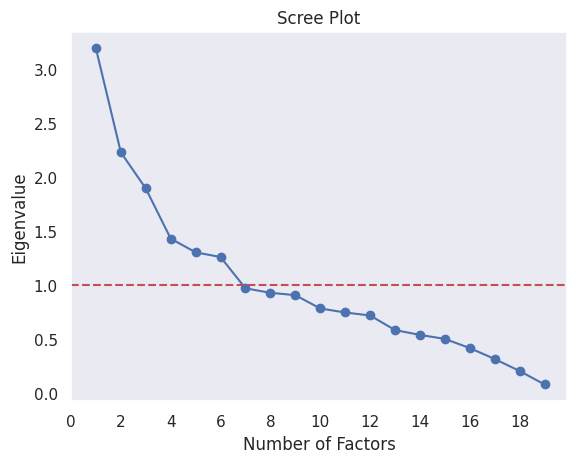

In [ ]:
eigenvalues, _ = factor_model.get_eigenvalues()
# count eigenvalues > 1
number_of_factors = sum(eigenvalues > 1)

# -- Scree plot --
plt.scatter(range(1,feature_mi.shape[1]+1),eigenvalues)
plt.plot(range(1,feature_mi.shape[1]+1),eigenvalues)
plt.title('Scree Plot')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.xticks(np.arange(0,len(feature_mi.columns)+1, step=2))
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()

In [ ]:
number_of_factors

6

In [ ]:
# Extraction Sums of Squared Loadings
vv, pv, cv = factor_model.get_factor_variance()
extract_tb = pd.DataFrame({"Component" : np.arange(1,len(feature_mi.columns)+1, step=1),
                           "Eigenvalues" : eigenvalues,
                           "% of variance" : vv,
                           "Cumulative factor variances" : cv})
extract_tb

Component  Eigenvalues  % of variance  Cumulative factor variances
0           1     3.192865       3.043975                     0.160209
1           2     2.229836       1.847065                     0.257423
2           3     1.895273       1.575672                     0.340353
3           4     1.430366       1.016886                     0.393874
4           5     1.303557       0.896856                     0.441077
5           6     1.259765       0.828862                     0.484701
6           7     0.969879       0.557621                     0.514049
7           8     0.928350       0.431769                     0.536774
8           9     0.906570       0.414873                     0.558610
9          10     0.783085       0.308183                     0.574830
10         11     0.746075       0.288134                     0.589995
11         12     0.718088       0.223720                     0.601769
12         13     0.583147       0.156916                     0.610028
13         14     0.538244       0.116174                     0.616142
14         15     0.501312       0.105439                     0.621692
15         16     0.416271       0.041404                     0.623871
16         17     0.314756       0.014264                     0.624622
17         18     0.203462       0.004897                     0.624879
18         19     0.079100       0.000000                     0.624879

In [ ]:
# communalities
communalities = factor_model.get_communalities()
communalities = pd.DataFrame(communalities, index=feature_mi.T.index, columns=['communalities'])
communalities.sort_values(by=['communalities'], ascending=False)

communalities
com_no             0.995001
window             0.944125
notebook           0.924697
B6                 0.833554
B4                 0.716935
B8                 0.666609
B1                 0.642553
B7                 0.613132
A1                 0.599291
SumKnowledge       0.598730
A4                 0.560570
B2                 0.556234
A3                 0.536809
A2                 0.500826
K1                 0.488461
B3                 0.471605
A5                 0.461214
B9                 0.450157
B10                0.312206

In [ ]:
factor_model = FactorAnalyzer(n_factors=number_of_factors, rotation="varimax")
factor_model.fit(feature_mi)

FactorAnalyzer(n_factors=6, rotation='varimax', rotation_kwargs={})

In [ ]:
# Rotation Sums of Squared Loadings
eigenvalues, _ = factor_model.get_eigenvalues()
vv, pv, cv = factor_model.get_factor_variance()
rotation_tb = pd.DataFrame({"Component" : np.arange(1,number_of_factors+1, step=1),
                          #  "Eigenvalues" : eigenvalues,
                           "% of variance" : vv,
                           "Cumulative factor variances" : cv})
rotation_tb

Component  % of variance  Cumulative factor variances
0          1       2.650326                     0.139491
1          2       1.512528                     0.219098
2          3       1.167350                     0.280537
3          4       1.153678                     0.341257
4          5       0.990802                     0.393404
5          6       0.940036                     0.442880

In [ ]:
# Rotation Sums of Squared Loadings
eig = pd.DataFrame({"Component" : np.arange(1,len(feature_mi.columns)+1, step=1),
                    "Eigenvalues" : eigenvalues})
eig

Component  Eigenvalues
0           1     3.192865
1           2     2.229836
2           3     1.895273
3           4     1.430366
4           5     1.303557
5           6     1.259765
6           7     0.969879
7           8     0.928350
8           9     0.906570
9          10     0.783085
10         11     0.746075
11         12     0.718088
12         13     0.583147
13         14     0.538244
14         15     0.501312
15         16     0.416271
16         17     0.314756
17         18     0.203462
18         19     0.079100

In [ ]:
# Check loadings of Rotation
loadings = pd.DataFrame(factor_model.loadings_)
loadings.rename(columns = lambda x: 'Factor-' + str(x + 1), inplace=True)
loadings.index = feature_mi.columns
loadings

Factor-1  Factor-2  Factor-3  Factor-4  Factor-5  Factor-6
B9            0.272318  0.061904  0.041693  0.081719  0.064506 -0.138193
B2            0.025892 -0.069788 -0.110323  0.082639 -0.029366  0.788078
A5            0.072552  0.003999  0.438212  0.032795  0.134809 -0.074175
A4           -0.041304  0.042338  0.391007 -0.066416  0.197278  0.373822
B1           -0.075036  0.320470  0.072907  0.299034 -0.282215 -0.107088
B7            0.208669 -0.053927 -0.055744  0.575808 -0.159335  0.060525
B3            0.089882 -0.244936  0.120759 -0.158456  0.046816  0.214243
B4            0.120303  0.569056  0.125511 -0.176134 -0.081154 -0.077789
B6           -0.150908  0.979528 -0.127444  0.015745  0.027839  0.054380
B10          -0.105331 -0.112591  0.311584 -0.067618 -0.061744  0.093685
A1           -0.036995  0.043567  0.392087 -0.182344  0.378208 -0.130433
SumKnowledge -0.034316 -0.036150  0.036383  0.051901  0.613336  0.084188
window        0.787198 -0.093337 -0.119077  0.142112 -0.055824  0.092606
A2            0.070398  0.143823  0.355278 -0.017196  0.120736 -0.182149
A3           -0.121276 -0.021334  0.528411 -0.162995 -0.000201  0.054280
B8            0.125822 -0.041749 -0.247927  0.748178  0.101912 -0.019979
com_no        0.993940 -0.035380 -0.028125  0.072257 -0.016882  0.062557
K1           -0.013485 -0.052086  0.127369 -0.067837  0.504306 -0.043904
notebook      0.903945 -0.040903 -0.057287  0.012676 -0.091520  0.027736

In [ ]:
def color_factor_importance(val):
    if np.abs(val) > 0.4:
        color = 'green'
    elif np.abs(val) > 0.3 and np.abs(val) <= 0.4:
        color = 'blue'
    else: 
        color = 'red'
    return 'color: %s' % color

loadings.style.applymap(color_factor_importance)

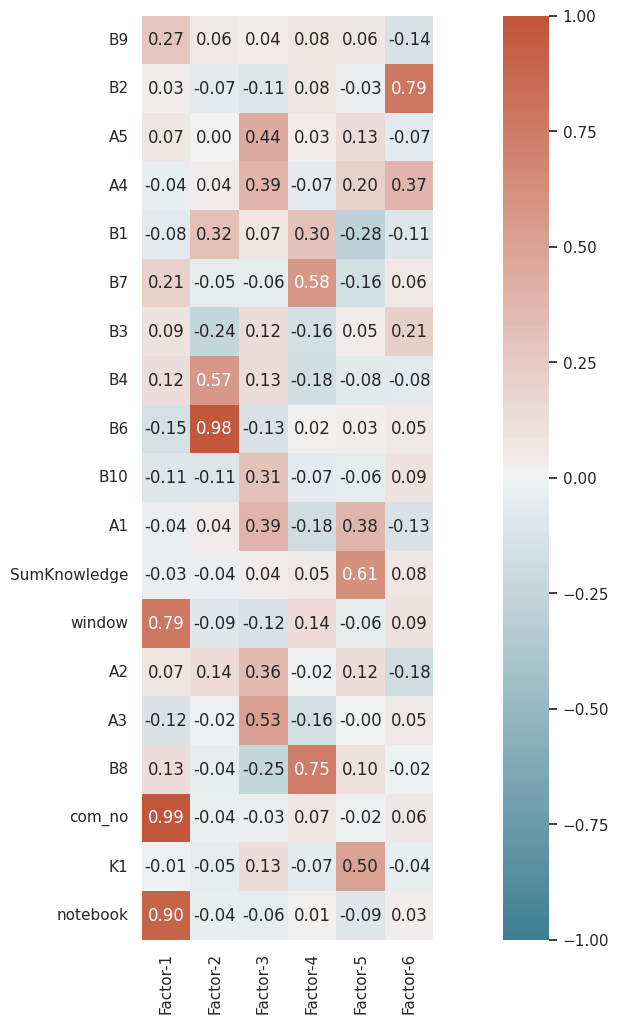

In [ ]:
plt.figure(figsize=(18,12))

# plot the heatmap for correlation matrix
ax = sns.heatmap(loadings, 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 20, n=200),
                 square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

In [ ]:
feature_mi.shape

(420, 19)

In [ ]:
feature_mi_latent = factor_model.transform(feature_mi)
feature_mi_latent.shape

(420, 6)

In [ ]:
pd.DataFrame(feature_mi_latent).head(5)

0         1         2         3         4         5
0  0.346969 -0.638094  0.639606  1.842307 -0.074074 -0.149958
1 -2.112787  1.881508 -0.094589 -0.612826 -0.033121 -0.173955
2  1.785473  1.441847 -0.256346 -0.245899  0.546788  0.050492
3 -0.757077  0.367845  1.152610 -0.562753  1.103942  0.204375
4  0.350697 -0.718526 -1.337422  0.624233  0.507625 -0.509652

# **5. Modelling**

หลังจากทำ EFA แล้วได้เพิ่มอีก 3 dataset **" รวมเป็น 6 dataset!!! "**

***feature_all***

In [ ]:
# feature_all
print(len(feature_all.columns))
feature_all.columns

35


Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'K1', 'A1',
       'A2', 'A3', 'A4', 'A5', 'com_no', 'desktop', 'notebook', 'window',
       'macos', 'linux', 'andriod', 'SumKnowledge', 'C1_1', 'C1_2', 'R1_0',
       'R1_1', 'R2_1', 'R2_2', 'R2_3', 'R2_4', 'R2_5', 'R3_0', 'R3_1'],
      dtype='object')

In [ ]:
feature_all_train, feature_all_test, labelR5new_all_train, labelR5new_all_test = train_test_split(feature_all,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

***feature_spearman***

In [ ]:
# feature_spearman
print(len(feature_spearman.columns))
feature_spearman.columns

24


Index(['B1', 'B8', 'B7', 'R2_5', 'window', 'B6', 'com_no', 'notebook', 'B9',
       'B4', 'A2', 'K1', 'R3_0', 'R2_2', 'C1_1', 'A1', 'linux', 'SumKnowledge',
       'B5', 'A3', 'R2_1', 'B3', 'B10', 'R2_4'],
      dtype='object')

In [ ]:
feature_spearman_train, feature_spearman_test, labelR5new_spearman_train, labelR5new_spearman_test = train_test_split(feature_spearman,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

***feature_mi***

In [ ]:
# feature_mi
print(len(feature_mi.columns))
feature_mi.columns

19


Index(['B9', 'B2', 'A5', 'A4', 'B1', 'B7', 'B3', 'B4', 'B6', 'B10', 'A1',
       'SumKnowledge', 'window', 'A2', 'A3', 'B8', 'com_no', 'K1', 'notebook'],
      dtype='object')

In [ ]:
feature_mi_train, feature_mi_test, labelR5new_mi_train, labelR5new_mi_test = train_test_split(feature_mi,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

***feature_all_latent***

In [ ]:
# feature_all_latent
print("feature_all get >>",len(pd.DataFrame(feature_all_latent).columns),"factors")
pd.DataFrame(feature_all_latent).head(5)

feature_all get >> 14 factors


0         1         2         3         4         5         6   \
0  0.922987  1.087504  0.185551 -0.572140 -0.802959  0.425256 -1.250820   
1 -2.082733  0.657569 -1.469332 -0.339567  1.279466 -0.148133  0.068205   
2  1.996156  0.919827  0.390526 -0.281519  1.695405  0.109070 -0.098484   
3 -0.942124  0.921566  0.676063 -0.622552 -0.179829  1.553928 -0.367433   
4  0.554606  1.133923  0.578394 -0.222313 -0.652580 -1.016661 -0.406398   

         7         8         9         10        11        12        13  
0 -0.227037 -0.260897 -0.659856  0.215298  0.280316 -0.462386 -1.198999  
1 -0.253801 -0.298584  1.743347 -0.305657  0.837902 -0.522305  0.533356  
2 -0.710983 -0.948548  2.038445  0.101348  0.227991  0.262247  0.488249  
3 -0.474123 -0.473094 -0.422471  0.753542  0.395442 -0.715041  0.569716  
4 -0.188835 -0.499052 -0.144503 -0.644251 -1.263332  0.238557  0.039672

In [ ]:
feature_all_latent_train, feature_all_latent_test, labelR5new_all_latent_train, labelR5new_all_latent_test = train_test_split(feature_all_latent,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

***feature_spearman_latent***

In [ ]:
# feature_spearman_latent
print("feature_spearman get >>",len(pd.DataFrame(feature_spearman_latent).columns),"factors")
pd.DataFrame(feature_spearman_latent).head(5)

feature_spearman get >> 8 factors


0         1         2         3         4         5         6  \
0  0.293627 -0.833711 -0.273435  1.791435  0.369634 -0.288792 -0.429920   
1 -2.166433  1.123154  0.205031 -1.037174 -0.851882 -0.539792  0.573637   
2  1.799700  1.515652  0.478062 -0.284686 -1.045897 -0.193884  0.891180   
3 -0.619585 -0.519078  0.476571 -0.408816  1.466186 -0.314865 -0.152223   
4  0.463451 -0.597103  0.436230  0.691155 -0.939497 -0.251936 -0.152089   

          7  
0  0.238024  
1  0.938013  
2  0.635576  
3  0.607132  
4 -1.531658

In [ ]:
feature_spearman_latent_train, feature_spearman_latent_test, labelR5new_spearman_latent_train, labelR5new_spearman_latent_test = train_test_split(feature_spearman_latent,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

***feature_mi_latent***

In [ ]:
# feature_mi_latent
print("feature_mi get >>",len(pd.DataFrame(feature_mi_latent).columns),"factors")
pd.DataFrame(feature_mi_latent).head(5)

feature_mi get >> 6 factors


0         1         2         3         4         5
0  0.346969 -0.638094  0.639606  1.842307 -0.074074 -0.149958
1 -2.112787  1.881508 -0.094589 -0.612826 -0.033121 -0.173955
2  1.785473  1.441847 -0.256346 -0.245899  0.546788  0.050492
3 -0.757077  0.367845  1.152610 -0.562753  1.103942  0.204375
4  0.350697 -0.718526 -1.337422  0.624233  0.507625 -0.509652

In [ ]:
feature_mi_latent_train, feature_mi_latent_test, labelR5new_mi_latent_train, labelR5new_mi_latent_test = train_test_split(feature_mi_latent,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

# 5.1. Baseline model

**Baseline model from feature_all**

In [ ]:
# Create model
svc = SVC()
knn = KNeighborsClassifier()
mlp = MLPClassifier(random_state=42)
tree = DecisionTreeClassifier()
lr = LogisticRegression(random_state=42)

models = [svc, knn, mlp, tree, lr]

In [ ]:
# --------------------------------------------------------------------
# === Accuracy of Baseline model :: feature_all ( 35 factors) ===
# --------------------------------------------------------------------

#Accuracy of train set 75%
cv_accuracies_train, accuracy_train,precission_train,recall_train,f1score_train = cv_comparison(models,feature_all_train,labelR5new_all_train,10)
display(cv_accuracies_train)

#Accuracy of test set 25%
cv_accuracies_test, accuracy_test,precission_test,recall_test,f1score_test = cv_comparison(models,feature_all_test,labelR5new_all_test,10)
display(cv_accuracies_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.6571  0.6412         0.6337         0.6095              0.5974
Precission  0.6551  0.6188         0.6146         0.5900              0.5768
Recall      0.6549  0.6388         0.6313         0.6095              0.5970
F1          0.6451  0.6085         0.6048         0.5825              0.5710

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.5036  0.4859         0.5112         0.4930              0.4975
Precission  0.4852  0.4496         0.4720         0.4511              0.4623
Recall      0.4867  0.4750         0.5011         0.4875              0.4927
F1          0.4593  0.4356         0.4612         0.4564              0.4616

In [ ]:
# --------------------------------------------------------------------
# === Accuracy of Baseline model :: feature_spearman ( 24 factors) ===
# --------------------------------------------------------------------

#Accuracy of train set 75%
cv_accuracies_train, accuracy_train,precission_train,recall_train,f1score_train = cv_comparison(models,feature_spearman_train,labelR5new_spearman_train,10)
display(cv_accuracies_train)

#Accuracy of test set 25%
cv_accuracies_test, accuracy_test,precission_test,recall_test,f1score_test = cv_comparison(models,feature_spearman_test,labelR5new_spearman_test,10)
display(cv_accuracies_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.6259  0.5986         0.5875         0.5779              0.5685
Precission  0.6306  0.5837         0.5726         0.5533              0.5463
Recall      0.6237  0.5962         0.5850         0.5751              0.5657
F1          0.6081  0.5669         0.5585         0.5490              0.5395

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.4782  0.4973         0.5155         0.4932              0.4933
Precission  0.4634  0.4720         0.4841         0.4512              0.4505
Recall      0.4800  0.5050         0.5256         0.4933              0.4940
F1          0.4410  0.4594         0.4741         0.4414              0.4416

In [ ]:
# --------------------------------------------------------------------
# === Accuracy of Baseline model :: feature_mi ( 19 factors) ===
# --------------------------------------------------------------------

#Accuracy of train set 75%
cv_accuracies_train, accuracy_train,precission_train,recall_train,f1score_train = cv_comparison(models,feature_mi_train,labelR5new_mi_train,10)
display(cv_accuracies_train)

#Accuracy of test set 25%
cv_accuracies_test, accuracy_test,precission_test,recall_test,f1score_test = cv_comparison(models,feature_mi_test,labelR5new_mi_test,10)
display(cv_accuracies_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.5872  0.5794         0.5641         0.5581              0.5443
Precission  0.5579  0.5602         0.5453         0.5388              0.5238
Recall      0.5809  0.5756         0.5607         0.5497              0.5368
F1          0.5587  0.5437         0.5310         0.5195              0.5054

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.4846  0.4214         0.4367         0.4514              0.4585
Precission  0.4286  0.3793         0.3887         0.4096              0.4142
Recall      0.4633  0.4067         0.4267         0.4442              0.4520
F1          0.4136  0.3655         0.3794         0.3875              0.3948

In [ ]:
# ----------------------------------------------------------------------
# === Accuracy of Baseline model :: feature_all_latent ( 14 factors) ===
# ----------------------------------------------------------------------

#Accuracy of train set 75%
cv_accuracies_train, accuracy_train,precission_train,recall_train,f1score_train = cv_comparison(models,feature_all_latent_train,labelR5new_all_latent_train,10)
display(cv_accuracies_train)

#Accuracy of test set 25%
cv_accuracies_test, accuracy_test,precission_test,recall_test,f1score_test = cv_comparison(models,feature_all_latent_test,labelR5new_all_latent_test,10)
display(cv_accuracies_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.6092  0.5952         0.5978         0.5690              0.5541
Precission  0.6150  0.5966         0.5980         0.5702              0.5513
Recall      0.6081  0.5945         0.5971         0.5721              0.5566
F1          0.5979  0.5751         0.5804         0.5550              0.5391

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.4318  0.4314         0.4512         0.4464              0.4396
Precission  0.3980  0.3930         0.4158         0.4208              0.4136
Recall      0.4167  0.4250         0.4478         0.4450              0.4400
F1          0.3904  0.3898         0.4122         0.4143              0.4070

In [ ]:
# --------------------------------------------------------------------------
# === Accuracy of Baseline model :: feature_spearman_latent ( 8 factors) ===
# --------------------------------------------------------------------------

#Accuracy of train set 75%
cv_accuracies_train, accuracy_train,precission_train,recall_train,f1score_train = cv_comparison(models,feature_spearman_latent_train,labelR5new_spearman_latent_train,10)
display(cv_accuracies_train)

#Accuracy of test set 25%
cv_accuracies_test, accuracy_test,precission_test,recall_test,f1score_test = cv_comparison(models,feature_spearman_latent_test,labelR5new_spearman_latent_test,10)
display(cv_accuracies_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.5683  0.5494         0.5430         0.5463              0.5323
Precission  0.5506  0.5197         0.5117         0.5213              0.5085
Recall      0.5654  0.5483         0.5418         0.5442              0.5305
F1          0.5382  0.5169         0.5128         0.5200              0.5049

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.4309  0.4400         0.4527         0.4423              0.4474
Precission  0.3943  0.3788         0.3918         0.3876              0.3907
Recall      0.4133  0.4233         0.4356         0.4325              0.4367
F1          0.3783  0.3799         0.3909         0.3922              0.3946

In [ ]:
len(pd.DataFrame(feature_mi_latent).columns)

6

In [ ]:
# --------------------------------------------------------------------------
# === Accuracy of Baseline model :: feature_mi_latent ( 6 factors) ===
# --------------------------------------------------------------------------

#Accuracy of train set 75%
cv_accuracies_train, accuracy_train,precission_train,recall_train,f1score_train = cv_comparison(models,feature_mi_latent_train,labelR5new_mi_latent_train,10)
display(cv_accuracies_train)

#Accuracy of test set 25%
cv_accuracies_test, accuracy_test,precission_test,recall_test,f1score_test = cv_comparison(models,feature_mi_latent_test,labelR5new_mi_latent_test,10)
display(cv_accuracies_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.5494  0.5352         0.5431         0.5320              0.5075
Precission  0.5217  0.5075         0.5181         0.5188              0.4922
Recall      0.5469  0.5339         0.5409         0.5329              0.5078
F1          0.5178  0.5043         0.5126         0.5038              0.4772

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM     kNN  MLPClassifier  DecissionTree  LogisticRegression
Accuracy    0.4873  0.4482         0.4612         0.4500              0.4516
Precission  0.4427  0.4082         0.4181         0.3920              0.3918
Recall      0.4867  0.4500         0.4622         0.4317              0.4353
F1          0.4403  0.4013         0.4146         0.3975              0.3975

# 5.2. Hyperparameter Tuning

**Hyperparameter tuning of SVM baseline model**

In [ ]:
def cv_comparison_tuning(models, X, y, cv):
  cv_accuracies = pd.DataFrame()
  accuracy = []
  precission = []
  recall = []
  f1score = []

  for model in models:
    acc = np.round(cross_val_score(model, X, y, scoring='accuracy', cv=cv),4)
    accuracy.append(acc)
    accuracy_avg = round(np.mean(accuracy), 4)

    pc = np.round(cross_val_score(model, X, y, scoring='precision_macro', cv=cv),4)
    precission.append(pc)
    precission_avg = round(np.mean(precission), 4)

    rc = np.round(cross_val_score(model, X, y, scoring='recall_macro', cv=cv),4)
    recall.append(rc)
    recall_avg = round(np.mean(recall), 4)

    f1 = np.round(cross_val_score(model, X, y, scoring='f1_macro', cv=cv),4) 
    # f1 for binary model (not sure to use f1_micro)
    f1score.append(f1)
    f1score_avg = round(np.mean(f1score), 4)

    cv_accuracies[str(model)] = [accuracy_avg,precission_avg,recall_avg,f1score_avg]

  cv_accuracies.index = ['Accuracy','Precission','Recall', 'F1']
  cv_accuracies.columns = ["SVM"]
  return cv_accuracies, accuracy,precission,recall,f1score

***feature_all***

In [ ]:
feature_all_train, feature_all_test, labelR5new_all_train, labelR5new_all_test = train_test_split(feature_all,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

In [ ]:
svc = SVC()
param_grid = {'C':[0.1,1,100,1000],
              'gamma':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear']}
svc_ramdom = RandomizedSearchCV(estimator = svc,
                                param_distributions = param_grid,
                                n_iter = 200,
                                cv = 10,
                                verbose = 2,
                                random_state = 42,
                                n_jobs = -1)
svc_ramdom.fit(feature_all_train,labelR5new_all_train)
svc_ramdom.best_params_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 64 is smaller than n_iter=200. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'kernel': 'rbf', 'gamma': 1, 'C': 100}

In [ ]:
# Optimal model
svc_opt = SVC(kernel='rbf',gamma=1,C=100)

models_opt = [svc_opt]

# Accuracy of Train set(75%)
cv_accuracies_train,accuracy_train,precission_train,recall_train,f1score_train = cv_comparison_tuning(models_opt,feature_all_train,
                                                                                               labelR5new_all_train,10)
display(cv_accuracies_train)

# Accuracy of Test Set(25%)
cv_accuracies_test,accuracy_test,precission_test,recall_test,f1score_test = cv_comparison_tuning(models_opt,feature_all_test,
                                                                                          labelR5new_all_test,10)
display(cv_accuracies_test)

SVM
Accuracy    0.7110
Precission  0.7385
Recall      0.7057
F1          0.7075

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM
Accuracy    0.5709
Precission  0.5279
Recall      0.5500
F1          0.5089

***feature_spearman***

In [ ]:
feature_spearman_train, feature_spearman_test, labelR5new_spearman_train, labelR5new_spearman_test = train_test_split(feature_spearman,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

In [ ]:
svc = SVC()
param_grid = {'C':[0.1,1,100,1000],
              'gamma':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear']}
svc_ramdom = RandomizedSearchCV(estimator = svc,
                                param_distributions = param_grid,
                                n_iter = 200,
                                cv = 10,
                                verbose = 2,
                                random_state = 42,
                                n_jobs = -1)
svc_ramdom.fit(feature_spearman_train,labelR5new_spearman_train)
svc_ramdom.best_params_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 64 is smaller than n_iter=200. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'kernel': 'poly', 'gamma': 100, 'C': 0.1}

In [ ]:
# Optimal model
svc_opt = SVC(kernel='poly',gamma=100,C=0.1)

models_opt = [svc_opt]

# Accuracy of Train set(75%)
cv_accuracies_train,accuracy_train,precission_train,recall_train,f1score_train = cv_comparison_tuning(models_opt,feature_spearman_train,
                                                                                               labelR5new_spearman_train,10)
display(cv_accuracies_train)

# Accuracy of Test Set(25%)
cv_accuracies_test,accuracy_test,precission_test,recall_test,f1score_test = cv_comparison_tuning(models_opt,feature_spearman_test,
                                                                                          labelR5new_spearman_test,10)
display(cv_accuracies_test)

SVM
Accuracy    0.6797
Precission  0.6670
Recall      0.6773
F1          0.6584

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM
Accuracy    0.5136
Precission  0.4827
Recall      0.5067
F1          0.4747

***feature_mi***

In [ ]:
feature_mi_train, feature_mi_test, labelR5new_mi_train, labelR5new_mi_test = train_test_split(feature_mi,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

In [ ]:
svc = SVC()
param_grid = {'C':[0.1,1,100,1000],
              'gamma':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear']}
svc_ramdom = RandomizedSearchCV(estimator = svc,
                                param_distributions = param_grid,
                                n_iter = 200,
                                cv = 10,
                                verbose = 2,
                                random_state = 42,
                                n_jobs = -1)
svc_ramdom.fit(feature_mi_train,labelR5new_mi_train)
svc_ramdom.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 64 is smaller than n_iter=200. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 64 candidates, totalling 640 fits


{'kernel': 'rbf', 'gamma': 1, 'C': 100}

In [ ]:
# Optimal model
svc_opt = SVC(kernel='rbf',gamma=1,C=100)

models_opt = [svc_opt]

# Accuracy of Train set(75%)
cv_accuracies_train,accuracy_train,precission_train,recall_train,f1score_train = cv_comparison_tuning(models_opt,feature_mi_train,
                                                                                               labelR5new_mi_train,10)
display(cv_accuracies_train)

# Accuracy of Test Set(25%)
cv_accuracies_test,accuracy_test,precission_test,recall_test,f1score_test = cv_comparison_tuning(models_opt,feature_mi_test,
                                                                                          labelR5new_mi_test,10)
display(cv_accuracies_test)

SVM
Accuracy    0.7206
Precission  0.7060
Recall      0.7154
F1          0.7013

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM
Accuracy    0.5773
Precission  0.5717
Recall      0.5700
F1          0.5399

***feature_all_latent***

In [ ]:
feature_all_latent_train, feature_all_latent_test, labelR5new_all_latent_train, labelR5new_all_latent_test = train_test_split(feature_all_latent,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

In [ ]:
svc = SVC()
param_grid = {'C':[0.1,1,100,1000],
              'gamma':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear']}
svc_ramdom = RandomizedSearchCV(estimator = svc,
                                param_distributions = param_grid,
                                n_iter = 200,
                                cv = 10,
                                verbose = 2,
                                random_state = 42,
                                n_jobs = -1)
svc_ramdom.fit(feature_all_latent_train,labelR5new_all_latent_train)
svc_ramdom.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 64 is smaller than n_iter=200. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 64 candidates, totalling 640 fits


{'kernel': 'rbf', 'gamma': 0.1, 'C': 100}

In [ ]:
# Optimal model
svc_opt = SVC(kernel='rbf',gamma=0.1 ,C=100)

models_opt = [svc_opt]

# Accuracy of Train set(75%)
cv_accuracies_train,accuracy_train,precission_train,recall_train,f1score_train = cv_comparison_tuning(models_opt,feature_all_latent_train,
                                                                                               labelR5new_all_latent_train,10)
display(cv_accuracies_train)

# Accuracy of Test Set(25%)
cv_accuracies_test,accuracy_test,precission_test,recall_test,f1score_test = cv_comparison_tuning(models_opt,feature_all_latent_test,
                                                                                          labelR5new_all_latent_test,10)
display(cv_accuracies_test)

SVM
Accuracy    0.6954
Precission  0.6881
Recall      0.6905
F1          0.6758

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM
Accuracy    0.5445
Precission  0.5337
Recall      0.5333
F1          0.5107

***feature_spearman_latent***

In [ ]:
feature_spearman_latent_train, feature_spearman_latent_test, labelR5new_spearman_latent_train, labelR5new_spearman_latent_test = train_test_split(feature_spearman_latent,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

In [ ]:
svc = SVC()
param_grid = {'C':[0.1,1,100,1000],
              'gamma':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear']}
svc_ramdom = RandomizedSearchCV(estimator = svc,
                                param_distributions = param_grid,
                                n_iter = 200,
                                cv = 10,
                                verbose = 2,
                                random_state = 42,
                                n_jobs = -1)
svc_ramdom.fit(feature_spearman_latent_train,labelR5new_spearman_latent_train)
svc_ramdom.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 64 is smaller than n_iter=200. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 64 candidates, totalling 640 fits


{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [ ]:
# Optimal model
svc_opt = SVC(kernel='rbf',gamma=1 ,C=1)

models_opt = [svc_opt]

# Accuracy of Train set(75%)
cv_accuracies_train,accuracy_train,precission_train,recall_train,f1score_train = cv_comparison_tuning(models_opt,feature_spearman_latent_train,
                                                                                               labelR5new_spearman_latent_train,10)
display(cv_accuracies_train)

# Accuracy of Test Set(25%)
cv_accuracies_test,accuracy_test,precission_test,recall_test,f1score_test = cv_comparison_tuning(models_opt,feature_spearman_latent_test,
                                                                                          labelR5new_spearman_latent_test,10)
display(cv_accuracies_test)

SVM
Accuracy    0.6571
Precission  0.6682
Recall      0.6514
F1          0.6475

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM
Accuracy    0.4382
Precission  0.3723
Recall      0.4100
F1          0.3587

***feature_mi_latent***

In [ ]:
feature_mi_latent_train, feature_mi_latent_test, labelR5new_mi_latent_train, labelR5new_mi_latent_test = train_test_split(feature_mi_latent,labelR5new_res,
                                                                                  test_size=0.25, random_state=42)

In [ ]:
svc = SVC()
param_grid = {'C':[0.1,1,100,1000],
              'gamma':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear']}
svc_ramdom = RandomizedSearchCV(estimator = svc,
                                param_distributions = param_grid,
                                n_iter = 200,
                                cv = 10,
                                verbose = 2,
                                random_state = 42,
                                n_jobs = -1)
svc_ramdom.fit(feature_mi_latent_train,labelR5new_mi_latent_train)
svc_ramdom.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 64 is smaller than n_iter=200. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 64 candidates, totalling 640 fits


{'kernel': 'rbf', 'gamma': 1, 'C': 100}

In [ ]:
# Optimal model
svc_opt = SVC(kernel='rbf',gamma=1 ,C=100)

models_opt = [svc_opt]

# Accuracy of Train set(75%)
cv_accuracies_train,accuracy_train,precission_train,recall_train,f1score_train = cv_comparison_tuning(models_opt,feature_mi_latent_train,
                                                                                               labelR5new_mi_latent_train,10)
display(cv_accuracies_train)

# Accuracy of Test Set(25%)
cv_accuracies_test,accuracy_test,precission_test,recall_test,f1score_test = cv_comparison_tuning(models_opt,feature_mi_latent_test,
                                                                                          labelR5new_mi_latent_test,10)
display(cv_accuracies_test)

SVM
Accuracy    0.6889
Precission  0.6759
Recall      0.6850
F1          0.6711

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

SVM
Accuracy    0.6391
Precission  0.6213
Recall      0.6300
F1          0.5944